# **LIBRERÍAS**

In [1]:
!pip install statsmodels==0.12.1
!pip install scikit-learn-extra
!pip install pyclustertend
!pip install dtaidistance
!pip install rdp

  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.1
    Uninstalling scikit-learn-1.1.1:
      Successfully uninstalled scikit-learn-1.1.1
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4573 sha256=242234259c8279e18ff0ec537a3ac9edb1fd1b6740d3f20b28676a820d02b7e8
  Stored in directory: c:\users\jomus\appdata\local\pip\cache\wheels\6f\c1\3a\4b9700d7bf5af51f83d533bf12b4ee6b00e40757a91cb86fdd
Successfully built rdp


In [3]:
import pandas as pd 
import numpy as np
#from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
#import math as mt
import statsmodels.api as sm
#import random
import seaborn as sns
import time as time
from scipy import stats as st 
sns.set()


from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from rdp import rdp

#from google.colab import files

In [4]:
#Para comprobar estacionaridad
from statsmodels.tsa.stattools import adfuller

#Necesito estas librerias para aplicar el K-means
from sklearn.cluster import KMeans, DBSCAN

from sklearn_extra.cluster import KMedoids

from sklearn.preprocessing import MinMaxScaler #scale, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import squareform



from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# **FUNCIONES**

In [5]:
#Código sacado de https://stackoverflow.com/questions/35713093/how-can-i-compare-two-lists-in-python-and-return-not-matches
#Retorna los activos que NO coinciden entre dos listas
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

In [6]:
#Edit: No recuerdo por qué hice una función para la distancia euclideana, pero supongo que en algun momento lo uso
def distancia_euclideana(serie1, serie2):
  distancia = ((serie1[0] - serie2[0])**2 + (serie1[1] - serie2[1])**2)**(0.5)
  return distancia

In [7]:
#Función para calcularla distancia entre modelos GARCH
#serie1 y serie2 son listas que contienen sus alfa y beta correspondientes del modelo GARCH estimado
def distancia_garch(serie_1, serie_2):  
  distancia = ((serie_1[0]**2) / (1 - serie_1[1]**2)    +   (serie_2[0]**2) / (1 - serie_2[1]**2)     -     (2*serie_1[0]*serie_2[0]) / (1 - serie_1[1]*serie_2[1]))**(1/2)
  return distancia

In [8]:
#Esta sección la saque de la documentación de Scipy para crear el dendrograma

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)    

In [ ]:
#Versión 6 (final)
#Este código se diseñó a medida que se realizaban los clusters
#En particular admite para 2, 3, 4 y 6 clusters (que así se dieron mis resultados)
#Admite los colores: red, blue, green, purple, aqua y orange #Nota: Hasta ahora siempre los he utilizado en ese orden... probar si al cambiarlo falla
#Cómo hay tantas cosas que mostrar, tuve que ser cuidadoso con tratar de mostrar todo de la forma más condensada y legible posible (Mediante colores, formas, bordes, casos especiales (La leyenda se me complicó también))
#Tarea pendiente: Generalizar este código para que funcione con cualquier cantidad de clusters.
                

#Prometo algún día optimizarlo uwu
def graficos_clusters(datos, labelx, labely, clusters, colores, titulo, name_file, download):
  fig, ax = plt.subplots(figsize = (15,10), facecolor = "white")
  
  
  #PRIMERO VOY A REORDENAR LAS LISTAS. EL OBJETIVO ES MOSTRAR ADEMÁS LOS CASOS ESPECIALES QUE FUERON CRIPTOMONEDAS Y SEGURO DEBIL AL MISMO TIEMPO
  criptomonedas_seguro = set(criptomonedas)&set(seguro_debil)
  solo_seguros = seguro_debil.copy()                                           #Eliminar de los seguros débiles aquellos que son criptomonedas (para no graficar dos veces y no se vea feo)
  solo_criptomonedas = criptomonedas.copy()                                   #Lo mismo para las criptomonedas, sacar aquellos casos especiales que además fueron seguros débiles    
  for j in criptomonedas_seguro:
    solo_seguros.remove(j)
    solo_criptomonedas.remove(j)  

  #Las coberturas fuertes son casos especiales, intentaré graficarlas una por una para que se vean bien en los gráficos
  #Las creo como listas porque necesito usar la funcion set para encontrar la coincidencia del activo con su cluster
  HEX = ["HEX-USD"]                                
  ZM = ["ZM=F"]
  ZR = ["ZR=F"]

  #De las listas anteriores, debo eliminar las que contengan alguno de estos tres activos
  criptomonedas_seguro.remove(HEX[0]) #HEX no está en la lista criptomonedas porque de esa lista ya se eliminaron las criptos que además son seguros, por ende falta eliminarlo de criptomonedas_seguro                   
  solo_seguros.remove(ZR[0])    #De la lista solo_seguros, se eliminaron las que son criptomonedas y seguros. Pero no se eliminó ZR=F, que es cobertura y seguro
  #ZM = F no es ni seguro ni criptomoneda, solo cobertura. En pasos posteriores habra una lista que se llama "el resto", de ahí tendré que eliminar "ZM=F"

  #Debo ordenar las coberturas de modo que en la leyenda se muestre primero las coberturas que pertenecen al cluster rojo, y luego los verdes (HEX (La cripto) tiene que ir a los extremos)
  #Nota: enrealidad es izquierda, al medio o derecha porque hay casos en los que hay 3 clusters, pero como ya lo había definido y tendría que cambiar todo lo deje así, perdón uwu
  
  #Si la cobertura está en el cluster rojo, toma el valor 0 y va a la izquierda
  #Si la cobertura está en el cluster azul, toma el valor 1 y va al medio
  #Si la cobertura está en el cluster verde, toma el valor 2 y va a la derecha
  posicion1 = 0
  posicion2 = 0 
  posicion3 = 0          
 
 
  for i in range(len(clusters)):
    criptomonedas_cluster = list(set(clusters[i])&set(solo_criptomonedas))
    criptomonedas_seguro_cluster = list(set(criptomonedas_seguro)&set(clusters[i]))
    seguros_cluster = list(set(clusters[i])&set(solo_seguros))


    especiales = criptomonedas_cluster + seguros_cluster + criptomonedas_seguro_cluster
    resto_del_cluster = returnNotMatches(clusters[i], especiales)[0]
    
    temporal = list(set(resto_del_cluster)&set(ZM))
    if len(temporal) == 1:
      resto_del_cluster.remove(ZM[0])
    
    #Los separé en base a los colores para plotear cada linea como un objeto, y poder mostrar en la leyenda todos los objetos
    #(Cada linea de la leyenda comparte dos marcadores iguales, pero con distintos colores en base a la cantidad de clusters)
    if colores[i] == "red":
      #Resto de los activos (Los que no son cripto, seguro ni cobertura)
      rcr = plt.scatter(datos[datos.columns[0]][resto_del_cluster], datos[datos.columns[1]][resto_del_cluster], color = colores[i], marker = "o", s = 250, label = "Cluster " + str(i+1), alpha = 0.3)   
      #seguros débiles
      scr = plt.scatter(datos[datos.columns[0]][seguros_cluster], datos[datos.columns[1]][seguros_cluster], color = colores[i], s = 175, marker = "P", edgecolors= "black", linewidth = 2, alpha = 0.7)
      #criptomonedas
      ccr = plt.scatter(datos[datos.columns[0]][criptomonedas_cluster], datos[datos.columns[1]][criptomonedas_cluster], color = "yellow", marker = "X", s = 150, edgecolors= colores[i], linewidth = 2, alpha = 1) 
      #criptomonedas y refugios débiles
      cscr = plt.scatter(datos[datos.columns[0]][criptomonedas_seguro_cluster], datos[datos.columns[1]][criptomonedas_seguro_cluster], color = "goldenrod", marker = "P", s = 200, edgecolors = "maroon", linewidth = 2.5, alpha = 1)
    
    if colores[i] == "blue":
      #Resto de los activos (Los que no son cripto, seguro ni cobertura)
      rcb = plt.scatter(datos[datos.columns[0]][resto_del_cluster], datos[datos.columns[1]][resto_del_cluster], color = colores[i], marker = "o", s = 250, label = "Cluster " + str(i+1), alpha = 0.3)   
      #seguros débiles      
      scb = plt.scatter(datos[datos.columns[0]][seguros_cluster], datos[datos.columns[1]][seguros_cluster], color = colores[i], s = 175, marker = "P", edgecolors= "black", linewidth = 2, alpha = 0.7)    
      #criptomonedas
      ccb = plt.scatter(datos[datos.columns[0]][criptomonedas_cluster], datos[datos.columns[1]][criptomonedas_cluster], color = "yellow", marker = "X", s = 150, edgecolors= colores[i], linewidth = 2, alpha = 1)     
      #criptomonedas y refugios débiles
      cscb = plt.scatter(datos[datos.columns[0]][criptomonedas_seguro_cluster], datos[datos.columns[1]][criptomonedas_seguro_cluster], color = "goldenrod", marker = "P", s = 200, edgecolors = "darkblue", linewidth = 2.5, alpha = 1)    
        


    if colores[i] == "green":
      #Resto de los activos (Los que no son cripto, seguro ni cobertura)
      rcg = plt.scatter(datos[datos.columns[0]][resto_del_cluster], datos[datos.columns[1]][resto_del_cluster], color = colores[i], marker = "o", s = 250, label = "Cluster " + str(i+1), alpha = 0.3)   
      #seguros débiles      
      scg = plt.scatter(datos[datos.columns[0]][seguros_cluster], datos[datos.columns[1]][seguros_cluster], color = colores[i], s = 175, marker = "P", edgecolors= "black", linewidth = 2, alpha = 0.7)    
      #criptomonedas
      ccg = plt.scatter(datos[datos.columns[0]][criptomonedas_cluster], datos[datos.columns[1]][criptomonedas_cluster], color = "yellow", marker = "X", s = 150, edgecolors= colores[i], linewidth = 2)     
      #criptomonedas y refugios débiles
      cscg = plt.scatter(datos[datos.columns[0]][criptomonedas_seguro_cluster], datos[datos.columns[1]][criptomonedas_seguro_cluster], color = "goldenrod", marker = "P", s = 200, edgecolors = "darkgreen", linewidth = 2.5, alpha = 1)    


    if colores[i] == "purple":
      #Resto de los activos (Los que no son cripto, seguro ni cobertura)
      rcp = plt.scatter(datos[datos.columns[0]][resto_del_cluster], datos[datos.columns[1]][resto_del_cluster], color = colores[i], marker = "o", s = 250, label = "Cluster " + str(i+1), alpha = 0.3)   
      #seguros débiles      
      scp = plt.scatter(datos[datos.columns[0]][seguros_cluster], datos[datos.columns[1]][seguros_cluster], color = colores[i], s = 175, marker = "P", edgecolors= "black", linewidth = 2, alpha = 0.7)    
      #criptomonedas
      ccp = plt.scatter(datos[datos.columns[0]][criptomonedas_cluster], datos[datos.columns[1]][criptomonedas_cluster], color = "yellow", marker = "X", s = 150, edgecolors= colores[i], linewidth = 2)     
      #criptomonedas y refugios débiles
      cscp = plt.scatter(datos[datos.columns[0]][criptomonedas_seguro_cluster], datos[datos.columns[1]][criptomonedas_seguro_cluster], color = "goldenrod", marker = "P", s = 200, edgecolors = "indigo", linewidth = 2.5, alpha = 1)    


    if colores[i] == "aqua":
      #Resto de los activos (Los que no son cripto, seguro ni cobertura)
      rca = plt.scatter(datos[datos.columns[0]][resto_del_cluster], datos[datos.columns[1]][resto_del_cluster], color = colores[i], marker = "o", s = 250, label = "Cluster " + str(i+1), alpha = 0.3)   
      #seguros débiles      
      sca = plt.scatter(datos[datos.columns[0]][seguros_cluster], datos[datos.columns[1]][seguros_cluster], color = colores[i], s = 175, marker = "P", edgecolors= "black", linewidth = 2, alpha = 0.7)    
      #criptomonedas
      cca = plt.scatter(datos[datos.columns[0]][criptomonedas_cluster], datos[datos.columns[1]][criptomonedas_cluster], color = "yellow", marker = "X", s = 150, edgecolors= colores[i], linewidth = 2)     
      #criptomonedas y refugios débiles
      csca = plt.scatter(datos[datos.columns[0]][criptomonedas_seguro_cluster], datos[datos.columns[1]][criptomonedas_seguro_cluster], color = "goldenrod", marker = "P", s = 200, edgecolors = "darkcyan", linewidth = 2.5, alpha = 1)    


    if colores[i] == "orange":
      #Resto de los activos (Los que no son cripto, seguro ni cobertura)
      rco = plt.scatter(datos[datos.columns[0]][resto_del_cluster], datos[datos.columns[1]][resto_del_cluster], color = colores[i], marker = "o", s = 250, label = "Cluster " + str(i+1), alpha = 0.3)   
      #seguros débiles      
      sco = plt.scatter(datos[datos.columns[0]][seguros_cluster], datos[datos.columns[1]][seguros_cluster], color = colores[i], s = 175, marker = "P", edgecolors= "black", linewidth = 2, alpha = 0.7)    
      #criptomonedas
      cco = plt.scatter(datos[datos.columns[0]][criptomonedas_cluster], datos[datos.columns[1]][criptomonedas_cluster], color = "yellow", marker = "X", s = 150, edgecolors= colores[i], linewidth = 2)     
      #criptomonedas y refugios débiles
      csco = plt.scatter(datos[datos.columns[0]][criptomonedas_seguro_cluster], datos[datos.columns[1]][criptomonedas_seguro_cluster], color = "goldenrod", marker = "P", s = 200, edgecolors = "darkorange", linewidth = 2.5, alpha = 1)    




#COBERTURAS FUERTES
#SE GRÁFICÓ CADA UNA DE ELLAS DEBIDO A LOS CASOS ESPECIALES
#HEX ES COBERTURA FUERTE, SEGURO DÉBIL Y CRIPTOMONEDAS
#ZR=f ES COBERTURA FUERTE Y SEGURO DÉBIL
#zm=f ES SÓLO COBERTURA FUERTE


   
    temporal = list(set(ZR)&set(clusters[i]))
    if colores[i] == "red" and len(temporal) == 1:
      zr = plt.scatter(datos[datos.columns[0]][ZR], datos[datos.columns[1]][ZR], color = "red", marker = "d", s = 400, edgecolor = "black", linewidth = 3)
      posicion1 = 0    
    if colores[i] == "blue" and len(temporal) == 1:
      zr = plt.scatter(datos[datos.columns[0]][ZR], datos[datos.columns[1]][ZR], color = "blue", marker = "d", s = 400, edgecolor = "black", linewidth = 3)
      posicion1 = 1
    if colores[i] == "green" and len(temporal) == 1:
      zr = plt.scatter(datos[datos.columns[0]][ZR], datos[datos.columns[1]][ZR], color = "green", marker = "d", s = 400, edgecolor = "black", linewidth = 3)
      posicion1 = 2    
    if colores[i] == "purple" and len(temporal) == 1:
      zr = plt.scatter(datos[datos.columns[0]][ZR], datos[datos.columns[1]][ZR], color = "purple", marker = "d", s = 400, edgecolor = "black", linewidth = 3)
      posicion1 = 3
    if colores[i] == "aqua" and len(temporal) == 1:
      zr = plt.scatter(datos[datos.columns[0]][ZR], datos[datos.columns[1]][ZR], color = "aqua", marker = "d", s = 400, edgecolor = "black", linewidth = 3)
      posicion1 = 4
    if colores[i] == "orange" and len(temporal) == 1:
      zr = plt.scatter(datos[datos.columns[0]][ZR], datos[datos.columns[1]][ZR], color = "orange", marker = "d", s = 400, edgecolor = "black", linewidth = 3)
      posicion1 = 5




    temporal = list(set(ZM)&set(clusters[i]))
    if colores[i] == "red" and len(temporal) == 1:
      zm = plt.scatter(datos[datos.columns[0]][ZM], datos[datos.columns[1]][ZM], color = "red", marker = "d", s = 400, edgecolor = "black", linewidth = 2)
      posicion2 = 0   
    if colores[i] == "blue" and len(temporal) == 1:
      zm = plt.scatter(datos[datos.columns[0]][ZM], datos[datos.columns[1]][ZM], color = "blue", marker = "d", s = 400, edgecolor = "black", linewidth = 2)
      posicion2 = 1
    if colores[i] == "green" and len(temporal) == 1:
      zm = plt.scatter(datos[datos.columns[0]][ZM], datos[datos.columns[1]][ZM], color = "green", marker = "d", s = 400, edgecolor = "black", linewidth = 2)
      posicion2 = 2
    if colores[i] == "purple" and len(temporal) == 1:
      zm = plt.scatter(datos[datos.columns[0]][ZM], datos[datos.columns[1]][ZM], color = "purple", marker = "d", s = 400, edgecolor = "black", linewidth = 2)
      posicion2 = 3
    if colores[i] == "aqua" and len(temporal) == 1:
      zm = plt.scatter(datos[datos.columns[0]][ZM], datos[datos.columns[1]][ZM], color = "aqua", marker = "d", s = 400, edgecolor = "black", linewidth = 2)
      posicion2 = 4
    if colores[i] == "orange" and len(temporal) == 1:
      zm = plt.scatter(datos[datos.columns[0]][ZM], datos[datos.columns[1]][ZM], color = "orange", marker = "d", s = 400, edgecolor = "black", linewidth = 2)
      posicion2 = 5



    temporal = list(set(HEX)&set(clusters[i]))
    if colores[i] == "red" and len(temporal) == 1:
      hex = plt.scatter(datos[datos.columns[0]][HEX], datos[datos.columns[1]][HEX], color = "goldenrod", marker = "d", s = 400, edgecolor = "maroon", linewidth = 3)
      posicion3 = 0
    if colores[i] == "blue" and len(temporal) == 1:
      hex = plt.scatter(datos[datos.columns[0]][HEX], datos[datos.columns[1]][HEX], color = "goldenrod", marker = "d", s = 400, edgecolor = "darkblue", linewidth = 3)
      posicion3 = 1
    if colores[i] == "green" and len(temporal) == 1:
      hex = plt.scatter(datos[datos.columns[0]][HEX], datos[datos.columns[1]][HEX], color = "goldenrod", marker = "d", s = 400, edgecolor = "darkgreen", linewidth = 3)
      posicion3 = 2
    if colores[i] == "purple" and len(temporal) == 1:
      hex = plt.scatter(datos[datos.columns[0]][HEX], datos[datos.columns[1]][HEX], color = "goldenrod", marker = "d", s = 400, edgecolor = "indigo", linewidth = 3)
      posicion3 = 3
    if colores[i] == "aqua" and len(temporal) == 1:
      hex = plt.scatter(datos[datos.columns[0]][HEX], datos[datos.columns[1]][HEX], color = "goldenrod", marker = "d", s = 400, edgecolor = "darkcyan", linewidth = 3)
      posicion3 = 4
    if colores[i] == "orange" and len(temporal) == 1:
      hex = plt.scatter(datos[datos.columns[0]][HEX], datos[datos.columns[1]][HEX], color = "goldenrod", marker = "d", s = 400, edgecolor = "darkorange", linewidth = 3)
      posicion3 = 5


  lista_orden_inicial = ["ZR=F", "ZM=F", "HEX-USD"]
  tupla_coberturas_inicial = [zr, zm, hex]
  posicion_inicial = [posicion1, posicion2, posicion3]
  coberturas_ordenadas = sorted(enumerate(posicion_inicial), key=lambda i: i[1])
  orden_coberturas = [lista_orden_inicial[coberturas_ordenadas[0][0]], lista_orden_inicial[coberturas_ordenadas[1][0]], lista_orden_inicial[coberturas_ordenadas[2][0]]]
  tupla_coberturas = [tupla_coberturas_inicial[coberturas_ordenadas[0][0]], tupla_coberturas_inicial[coberturas_ordenadas[1][0]], tupla_coberturas_inicial[coberturas_ordenadas[2][0]]]
  tupla_coberturas = tuple(tupla_coberturas)
  
  #Nota: Las siguientes dos lineas las utilicé solo para trend season
  plt.xlim(0, 0.6)
  plt.ylim(0.8, 1.05)

  if len(colores) == 6:
    l = plt.legend([(rcr, rcb, rcg, rcp, rca, rco), (ccr, ccb, ccg, ccp, cca, cco), (scr, scb, scg, scp, sca, sco), (cscr, cscb, cscg, cscp, csca, csco), tupla_coberturas], ["Divesificadores", "Criptomonedas", "Seguros Débiles", "Seguros Débiles y Criptomonedas", orden_coberturas[0] + ", " + orden_coberturas[1] + ", " + orden_coberturas[2]],
                   scatterpoints = 1, fontsize = 20, loc = "best", handler_map={tuple: HandlerTuple(ndivide=None)})

  if len(colores) == 4:
    l = plt.legend([(rcr, rcb, rcg, rcp), (ccr, ccb, ccg, ccp), (scr, scb, scg, scp), (cscr, cscb, cscg, cscp), tupla_coberturas], ["Divesificadores", "Criptomonedas", "Seguros Débiles", "Seguros Débiles y Criptomonedas", orden_coberturas[0] + ", " + orden_coberturas[1] + ", " + orden_coberturas[2]],
                   scatterpoints = 1, fontsize = 15, loc = "best", handler_map={tuple: HandlerTuple(ndivide=None)})
  
  if len(colores) == 3:
    l = plt.legend([(rcr, rcb, rcg), (ccr, ccb, ccg), (scr, scb, scg), (cscr, cscb, cscg), tupla_coberturas], ['Diversificadores', "Criptomonedas", "Seguros Débiles", "Seguros Débiles y Criptomonedas", orden_coberturas[0] + ", " + orden_coberturas[1] + ", " + orden_coberturas[2]], 
              scatterpoints = 1, fontsize = 15, loc = "best", handler_map={tuple: HandlerTuple(ndivide=None)})
  if len(colores) == 2:
    l = plt.legend([(rcr, rcb), (ccr, ccb), (scr, scb), (cscr, cscb), tupla_coberturas], ['Diversificadores', "Criptomonedas", "Seguros Débiles", "Seguros Débiles y Criptomonedas", orden_coberturas[0] + ", " + orden_coberturas[1] + ", " + orden_coberturas[2]], 
              scatterpoints = 1, fontsize = 15, loc = "best", handler_map={tuple: HandlerTuple(ndivide=None)})
    
  
  
  plt.grid()
  plt.title(titulo, fontsize = 20)
  plt.xlabel(labelx, fontsize = 20)
  plt.ylabel(labely, fontsize = 20)
  

  if download == True:
    plt.savefig(name_file + ".png", bbox_inches = "tight")
    files.download(name_file +".png")
  else:
    pass
  plt.show()

In [9]:
#Necesito calcular el SSE para cuando utilizo clustering aglomerativo (Inertia solo está disponible para kmeans y kmedoids uwu)
#NOTA: comprobé que el código estuviese bien implementado comparándolo con la funcion Kmeans.inertia_ ... Me dió exactamente el mismo resultado :)
def SSE_euclideana(data, labels):

  n_clusters = np.unique(labels)                                                #Lista que contiene la cantidad de clusters que hay, ej [0,1,2,3,4,5,6] (7 clusters)
  clusters = []                                                                 #Lista de listas. Cada una de las listas que la conforman consiste en los activos que pertenecen a ese cluster
  
  for i in n_clusters:                                                          #Para cada uno de los clusters que hay...
    cluster_k = []                                                              #Guardar en esta lista...
    for j in range(len(labels)):                                                #Aquellos activos que pertenezcan a dicho cluster
      if labels[j] == i:
        cluster_k.append(j)                                                     #Lo que guardo en la lista es el índice de aquellos activos que pertenecen al mismo cluster

    clusters.append(cluster_k)

  #Ahora para cada cluster se calcula la suma de la distancia al cuadrado del punto al centroide
  
  SSE = []                                                                      #Calcular el SSE para cada cluster, guardar en esta lista y el SSE total será la suma de esta lista
  for i in range(len(clusters)):
    
    df = data.iloc[clusters[i]]                                                 #Toma los datos de aquellos que pertenecen al mismo cluster
    
    #Calcula el centroide del cluster
    centroide_x = sum(df[df.columns[0]])/len(df)
    centroide_y = sum(df[df.columns[1]])/len(df)
    centroide = [centroide_x, centroide_y]

    
    #Calcular la distancia de cada punto del cluster a su centroide al cuadrado
    SSE_cluster = 0
    for j in range(len(df)):
      SSE_cluster = SSE_cluster + (distancia_euclideana(centroide, list(df.iloc[j])))**2

    SSE.append(SSE_cluster)

  SSE_total = sum(SSE)

  return SSE_total

In [10]:
def Hubert_Normalized(data, metrica, C):
  
  distance_matrix = []
  for i in range(len(data)-1):
    for j in range(i+1, len(data)):
      if metrica == "euclideana":
        distance_matrix.append(distancia_euclideana(data.iloc[i], data.iloc[j]))
      if metrica == "GARCH":
        distance_matrix.append(distancia_garch(data.iloc[i], data.iloc[j]))
  
  distance_matrix = squareform(distance_matrix)

  df_matrix = pd.DataFrame(columns = [i for i in list(data.index)])
  for i in range(len(distance_matrix)):
    df_matrix.loc[i] = distance_matrix[i]
  df_matrix.index = data.index

  


  #Lo siguiente que necesito es la matriz Y(i,j) de coincidencias para cada par de combinacion posible de N
  #Por ejemplo, para el activo [0] "BHP", se evalua respecto a todos los otros activos si ambos pertenecen al mismo cluster o no
  #SI AMBOS PERTENECEN A DISTINTOS CLUSTERS, TOMA Y(i,j) TOMA EL VALOR 1
  #OTHERWISE --> 0
  #PD: La matriz Y(i,j) es simétrica 




  y_matrix = []
  for i in range(len(data)-1):
    for j in range(i+1, len(data)):
      name_i = data.index[i]
      name_j = data.index[j]

      conjunto = [name_i, name_j]
      comparten_cluster_o_no = []

      #Evalua para cada Cluster (Ci) si ambos activos coinciden en uno de los N clusters
      for k in range(len(C)):
        comparten_cluster = len(set(C[k])&set(conjunto))           #Si llegasen a compartir cluster esto valdría 2

        if comparten_cluster == 2:                                              #Cómo comparten cluster, la coincidencia entre i y j toma el valor 0
          #Están en el mismo cluster (0)
          comparten_cluster_o_no.append(0)
        else:                                                                   #Como no comparten cluster toma el valor 1
          comparten_cluster_o_no.append(1)
      y_matrix.append(min(comparten_cluster_o_no))          #Si comparten cluster, la lista "comparten cluster o no" sería tipo: [0,1,1]  y como comparten cluster, se toma el valor mínimo (0)
                                                                    #En caso que no compartan cluster, la lista sería tipo [1,1,1], y como no comparten cluster, tambien puedo tomar el valor mínimo (1)      
  y_matrix = squareform(y_matrix)


  #Pasándo la lista de listas a dataframe
  matriz_coincidencia = pd.DataFrame(columns = [i for i in list(data.index)])
  for i in range(len(y_matrix)):
    matriz_coincidencia.loc[i] = y_matrix[i]
  matriz_coincidencia.index = data.index



  #Necesito ahora calcular un par de cosillas
  #Primero, la media de la matriz de distancias y de la matriz de coincidencias
  suma_distancias = 0
  suma_coincidencias = 0
  for i in range(len(df_matrix)):
    suma_distancias = suma_distancias + sum(df_matrix[df_matrix.columns[i]])
    suma_coincidencias = suma_coincidencias + sum(matriz_coincidencia[matriz_coincidencia.columns[i]])
 #Las matrices son simétricas por ende:
  media_parcial_distancias = suma_distancias/2
  media_parcial_coincidencias = suma_coincidencias/2
  N = len(data)   #Total de vectores
  M = N*(N-1)/2             #Total posibles combinaciones
  media_distancias = media_parcial_distancias/M
  media_coincidencias = media_parcial_coincidencias/M



  #Ahora lo mismo pero calcular la varianza de cada una

  varianza_distancias_parcial = 0
  varianza_coincidencias_parcial = 0

  for i in range(len(df_matrix)-1):
    for j in range(i+1, len(df_matrix)):
      varianza_distancias_parcial = varianza_distancias_parcial + (df_matrix.iloc[i][j]**2 - media_distancias**2)
      varianza_coincidencias_parcial = varianza_coincidencias_parcial + (matriz_coincidencia.iloc[i][j]**2 - media_coincidencias**2)

  varianza_distancias = varianza_distancias_parcial / M
  varianza_coincidencias = varianza_coincidencias_parcial / M



  #Ahora que tengo todo eso calculado, tengo que calcular es coeficiente normalizado de Hubert
  hubert_parcial = 0
  for i in range(len(data)-1):
    for j in range(i+1, len(data)):
      hubert_parcial = hubert_parcial + (df_matrix.iloc[i][j] - media_distancias)*(matriz_coincidencia.iloc[i][j] - media_distancias) #mira el perla acabo de encontrar este error conchadetumadreeeeeeeeeeeeeeeee

  hubert_parcial = hubert_parcial / M
  estadistico_hubert_normalizado = hubert_parcial /((varianza_distancias**(1/2)) * (varianza_coincidencias**(1/2)))

  return estadistico_hubert_normalizado

In [11]:
#data: ret_var_scaled, skew_kurt_scaled ó trend_season
#r: número de simulaciones de MonteCarlo (típicamente = 100)
#k: el K de K-Means (tiene que ser el mismo que se utilizó en la aplicación sobre los datos originales)

#NOTA: Este código considera solo la distancia euclideana

def MonteCarlo_Hubert_Kmeans(data, r, k):
  
  huberts = []
  for i in range(r):
    #Genera un dataframe con vectores aleatorios (siguen una distribución uniforme bajo el mismo rango que los datos originales)
    aleatoria1 = [np.random.uniform(min(data[data.columns[0]]), max(data[data.columns[0]])) for i in range(len(data))]
    aleatoria2 = [np.random.uniform(min(data[data.columns[1]]), max(data[data.columns[1]])) for i in range(len(data))]

    #Lo deposito en un dataframe
    df_aleatorio = pd.DataFrame()
    df_aleatorio["random1"] = aleatoria1
    df_aleatorio["random2"] = aleatoria2

    #Aplica K-Means
    
    modelo_kmeans = KMeans(n_clusters= k, n_init=25, random_state=123)
    modelo_kmeans = modelo_kmeans.fit(X = df_aleatorio)
    
    #Crea un dataframe con los resultados de K-Means (cada fila indica el vector y el cluster al que pertenece)
    clusters_kmeans = pd.DataFrame()
    clusters_kmeans["clusters"] = modelo_kmeans.labels_
    clusters_kmeans.index = df_aleatorio.index
    
    
    #Necesito separar los vectores en base a los clusters a los que pertenecen
    #i.e, Juntar todos los vectores que pertenecen al cluster "n" en una lista
    #Todos los vectores que pertenecen al cluster "n+1" en otra lista
    #Hacer una lista que contenga esas listas. --> para utilizar la función de Hubert Normalized

    #Uso diccionarios para hacerlo de forma general.
    #Crea "K" listas (cada una contendrá los elementos que pertenecen al mismo cluster)
    numero_de_clusters = [i for i in range(k)]
    listas = {}
    for i in numero_de_clusters:
      listas["cluster" + str(i)] = []

    #Agrega los elementos a sus listas (clusters) correspondientes
    for i in range(len(modelo_kmeans.labels_)):
      x = modelo_kmeans.labels_[i]
      listas["cluster" + str(x)].append(clusters_kmeans.index[i])

    #Pasa los elementos del diccionario a una lista de listas.
    total_clusters = []
    for i in range(k):
      total_clusters.append(tuple(listas.items())[i][1])

    x = Hubert_Normalized(df_aleatorio, "euclideana", total_clusters)
    huberts.append(x)

  return huberts

In [12]:
#NOTA: TUVE QUE HACER OTRA FUNCIÓN ESPECÍFICAMENTE PARA EL CASO DE DBSCAN
#ES IDÉNTICA A "HUBERT_NORMALIZED"
#SÓLO QUE TUVE QUE HACER UNAS PEQUEÑAS MODIFICACIONES POR EL TEMA DE LOS "OUTLIERS"


def Hubert_Normalized_DBSCAN(data, metrica, C):
  
  distance_matrix = []
  y_matrix = []
  for i in range(len(data)-1):
    for j in range(i+1, len(data)):
      
      ######################################## ESTA PARTE ES PARA CALCULAR LA MATRIZ "Y"#############################
      #Lo siguiente que necesito es la matriz Y(i,j) de coincidencias para cada par de combinacion posible de N
      #Por ejemplo, para el activo [0] "BHP", se evalua respecto a todos los otros activos si ambos pertenecen al mismo cluster o no
      #En el caso de que dos activos pertenezcan distintos clusters el elemento i,j toma el valor 1
      #Otherwise: 0
      #PD: La matriz Y(i,j) es simétrica  
      name_i = data.index[i]
      name_j = data.index[j]
      #Evalua para cada Cluster (Ci) si ambos activos coinciden en uno de los N clusters
      for k in range(len(C)):
        if (name_i in C[k]) == True:
          index_i = k
        if (name_j in C[k]) == True:
          index_j = k



      
      if index_i == index_j:
        
        #Caso en que sean outliers
        if (index_i and index_j) == 0:
          y_matrix.append(0)
        #Caso en que ambos pertenecen al mismo cluster
        else:
          y_matrix.append(0)
      #Ambos están en diferentes clusters
      if index_i != index_j:
        y_matrix.append(1)

      ###################################### LA PARTE QUE SIGUE ES PARA CALCULAR LA MATRIZ DE DISTANCIAS########################################     
      if metrica == "euclideana":
        distance_matrix.append(distancia_euclideana(data.iloc[i], data.iloc[j]))
      if metrica == "GARCH":
        distance_matrix.append(distancia_garch(data.iloc[i], data.iloc[j]))
  
  distance_matrix = squareform(distance_matrix)  
  y_matrix = squareform(y_matrix)

  df_matrix = pd.DataFrame(columns = [i for i in list(data.index)])  
  matriz_coincidencia = pd.DataFrame(columns = [i for i in list(data.index)])

  for i in range(len(distance_matrix)):
    df_matrix.loc[i] = distance_matrix[i]
    matriz_coincidencia.loc[i] = y_matrix[i] 
  df_matrix.index = data.index
  matriz_coincidencia.index = data.index
  


  #Necesito ahora calcular un par de cosillas
  #Primero, la media de la matriz de distancias y de la matriz de coincidencias
  suma_distancias = 0
  suma_coincidencias = 0
  for i in range(len(df_matrix)):
    suma_distancias = suma_distancias + sum(df_matrix[df_matrix.columns[i]])
    suma_coincidencias = suma_coincidencias + sum(matriz_coincidencia[matriz_coincidencia.columns[i]])
 #Las matrices son simétricas por ende:
  media_parcial_distancias = suma_distancias/2
  media_parcial_coincidencias = suma_coincidencias/2
  N = len(data)   #Total de vectores
  M = N*(N-1)/2             #Total posibles combinaciones
  media_distancias = media_parcial_distancias/M
  media_coincidencias = media_parcial_coincidencias/M



  #Ahora lo mismo pero calcular la varianza de cada una

  varianza_distancias_parcial = 0
  varianza_coincidencias_parcial = 0

  for i in range(len(df_matrix)-1):
    for j in range(i+1, len(df_matrix)):
      varianza_distancias_parcial = varianza_distancias_parcial + (df_matrix.iloc[i][j]**2 - media_distancias**2)
      varianza_coincidencias_parcial = varianza_coincidencias_parcial + (matriz_coincidencia.iloc[i][j]**2 - media_coincidencias**2)

  varianza_distancias = varianza_distancias_parcial / M
  varianza_coincidencias = varianza_coincidencias_parcial / M

  
  #Ahora que tengo todo eso calculado, tengo que calcular es coeficiente normalizado de Hubert
  hubert_parcial = 0
  for i in range(len(data)-1):
    for j in range(i+1, len(data)):
      hubert_parcial = hubert_parcial + (df_matrix.iloc[i][j] - media_distancias)*(matriz_coincidencia.iloc[i][j] - media_distancias) 

  hubert_parcial = hubert_parcial / M
  estadistico_hubert_normalizado = hubert_parcial /((varianza_distancias**(1/2)) * (varianza_coincidencias**(1/2)))

  return estadistico_hubert_normalizado

In [13]:
#NOTA: ESTA FUNCIÓN UTILIZA ÚNICAMENTE LA DISTANCIA EUCLIDEANA
#MIN_SAMPLES SIEMPRE ES = 4 COMO FUE EL CASO DE LA INVESTIGACIÓN

def MonteCarlo_Hubert_DBSCAN(data, r, radio):
  huberts = []
  for i in range(r):
    #Genera un dataframe con vectores aleatorios (siguen una distribución uniforme bajo el mismo rango que los datos originales)
    aleatoria1 = [np.random.uniform(min(data[data.columns[0]]), max(data[data.columns[0]])) for i in range(len(data))]
    aleatoria2 = [np.random.uniform(min(data[data.columns[1]]), max(data[data.columns[1]])) for i in range(len(data))]

    df_aleatorio = pd.DataFrame()
    df_aleatorio["random1"] = aleatoria1
    df_aleatorio["random2"] = aleatoria2

    #Calcular la matriz de distancia del dataframe aleatorio
    
    modelo_dbscan = DBSCAN(
                        eps          = radio,
                        min_samples  = 4,
                        metric       = 'euclidean',
                    )

    modelo_dbscan.fit(X=df_aleatorio)
    
    
    clusters_DBSCAN = pd.DataFrame()
    clusters_DBSCAN["clusters"] = modelo_dbscan.labels_
    clusters_DBSCAN.index = df_aleatorio.index


    total_clusters = []
    cantidad_de_clusters = len(np.unique(modelo_dbscan.labels_))
    for j in range(cantidad_de_clusters):
      total_clusters.append([])

    for j in range(-1, cantidad_de_clusters - 1):                               #Parte desde menos uno para considerar los outliers
      for k in range(len(clusters_DBSCAN)):
        if clusters_DBSCAN["clusters"][k] == j:
          total_clusters[j+1].append(clusters_DBSCAN.index[k])



    x = Hubert_Normalized(df_aleatorio, "euclideana", total_clusters)
    huberts.append(x)

  return huberts

In [14]:
#COEFICIENTE DE CORRELACIÓN COFENÉTICA
#Data: rer_var_scaled, skew_kurt_scaled, trend_season, alfa_beta
#metodo: linkage single, complete, average
#metrica: medida de distancia, euclideana o GARCH

def CCPC(data, metodo, metrica):

  if metrica == "euclideana":

    distance_matrix = []
    for i in range(len(data)):
      distancia_i_j = []
      for j in range(len(data)):
        if j < i:
          distancia_i_j.append(distance_matrix[j][i])
        else:
          distancia_i_j.append(distancia_euclideana(data.iloc[i], data.iloc[j]))

      distance_matrix.append(distancia_i_j)

  if metrica == "GARCH":

    distance_matrix = []
    for i in range(len(data)):
      distancia_i_j = []
      for j in range(len(data)):
        if j < i:
          distancia_i_j.append(distance_matrix[j][i])
        else:
          distancia_i_j.append(distancia_garch(data.iloc[i], data.iloc[j]))

      distance_matrix.append(distancia_i_j)



  #Convierte la matriz que era una lista de listas en un dataframe
  df_matrix = pd.DataFrame(columns = [i for i in range(len(data))])
  for i in range(len(distance_matrix)):
    df_matrix.loc[i] = distance_matrix[i]

  cdm = squareform(df_matrix)     #Convierte la matriz de distancia en la matriz condensada
  Z = linkage(cdm, method = metodo)
  CCPC = cophenet(Z, cdm)[0]            #Calcula el coeficiente de correlación cofenetica (entre la matríz cofenetica y la matriz de distancia)
  return CCPC

In [15]:
#data: corresponde a los datos utilizados (ret_var_scaled, skew_kurt_scaled)   (Creo que para Garch tendré que hacer un caso aparte)    #Tal vez se pueda omitir, solo lo uso para saber el largo de los datos (por ahora)
#distance_matrix: matriz de distancia en su forma original (NxN)
#r: Número de iteraciones que se simulará el Monte Carlo (en el libro usaban 100)
#method: Single, Complete, Average, Ward 

def MonteCarlo_CCPC(data, r, metodo, metrica):
  
  CCPC = []
  for i in range(r):                                                       #en cada r(i) se crea un dataset sintético y se calcula el CPCC
    
    if metrica == "euclideana":

      #Genera un dataframe con vectores aleatorios (siguen una distribución uniforme bajo el mismo rango que los datos originales)
      aleatoria1 = [np.random.uniform(min(data[data.columns[0]]), max(data[data.columns[0]])) for i in range(len(data))]
      aleatoria2 = [np.random.uniform(min(data[data.columns[1]]), max(data[data.columns[1]])) for i in range(len(data))]

      df_aleatorio = pd.DataFrame()
      df_aleatorio["random1"] = aleatoria1
      df_aleatorio["random2"] = aleatoria2

      #Calcular la matriz de distancia del dataframe aleatorio
      distance_matrix = []
      for i in range(len(df_aleatorio)):
        distancia_i_j = []
        for j in range(len(df_aleatorio)):
          if j < i:
            distancia_i_j.append(distance_matrix[j][i])
          else:
            distancia_i_j.append(distancia_euclideana(df_aleatorio.iloc[i], df_aleatorio.iloc[j]))

        distance_matrix.append(distancia_i_j)



    if metrica == "GARCH":
      #Los datos aleatorios se deben generar bajo el area de los datos originales X. En el caso del dataframe Alfa_beta, La suma de ambas variables debe ser menor a 1
      #Por lo tanto se generan vectores aleatorios pero cumpliendo con la condicion de que la suma de ambos sean menores a 1
      aleatoria1 = []
      aleatoria2 = []
      for i in range(len(data)):
        x = np.random.uniform(min(data[data.columns[0]]), max(data[data.columns[0]]))
        y = np.random.uniform(0, 1-x)
        aleatoria1.append(x)
        aleatoria2.append(y)

      df_aleatorio = pd.DataFrame()
      df_aleatorio["random1"] = aleatoria1
      df_aleatorio["random2"] = aleatoria2      

    #Calcular la matriz de distancia del dataframe aleatorio

      distance_matrix = []
      for i in range(len(df_aleatorio)):
        distancia_i_j = []
        for j in range(len(df_aleatorio)):
          if j < i:
            distancia_i_j.append(distance_matrix[j][i])
          else:
            distancia_i_j.append(distancia_garch(df_aleatorio.iloc[i], df_aleatorio.iloc[j]))

        distance_matrix.append(distancia_i_j)



    #Convierte la matriz que era una lista de listas en un dataframe
    df_matrix = pd.DataFrame(columns = [i for i in range(len(df_aleatorio))])
    for i in range(len(distance_matrix)):
      df_matrix.loc[i] = distance_matrix[i]
       
    
    
    cdm = squareform(df_matrix)     #Convierte la matriz de distancia en la matriz condensada
    Z = linkage(cdm, method = metodo)
    CCPC_i = cophenet(Z, cdm)[0]            #Calcula el coeficiente de correlación cofenetica (entre la matríz cofenetica y la matriz de distancia)
    CCPC.append(CCPC_i)


  return CCPC     #Retorna los coeficiente de correlación cofenética de cada simulación, la idea es utilizar esto para graficarlo y ver la función de densidad de probabilidad (Y testear la hipótesis de datos aleatorios)

# **CARGANDO DATOS + LIMPIEZA**

In [16]:
files.upload()

NameError: name 'files' is not defined

In [25]:
basic_materials = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\basic_materials.csv', index_col = "Date")
communication_services = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\communication_services.csv', index_col = "Date")
consumer_cyclical = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\consumer_cyclical.csv', index_col = "Date")
consumer_defensive = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\consumer_defensive.csv', index_col = "Date")
crypto = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\crypto.csv', index_col = "Date")
bonds = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\bonds.csv', index_col = "Date")
currencies = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\currencies.csv', index_col = "Date")
energy_services = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\energy_services.csv', index_col = "Date")
financial_services = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\financial_services.csv', index_col = "Date")
futures = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\futures.csv', index_col = "Date")
healthcare = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\healthcare.csv', index_col = "Date")
indices = pd.read_csv(r'C:\Users\jomus\ObneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\indices.csv', index_col = "Date")
industrial_services = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\industrial_services.csv', index_col = "Date")
real_estate = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\real_estate.csv', index_col = "Date")
technology = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\technology.csv', index_col = "Date")
utilities = pd.read_csv(r'C:\Users\jomus\OneDrive\Escritorio\Time_Series_Clustering_TESIS\Data_by_sector\utilities.csv', index_col = "Date")



#Lista que contiene todos los DataFrames . . . MENOS LA DE LOS ÍNDICES 
df_sector = [basic_materials, communication_services, consumer_cyclical, consumer_defensive, energy_services, financial_services, healthcare, industrial_services, real_estate, technology, utilities, futures, currencies, bonds, crypto]
df_sector_str = ["basic_materials", "communication_services", "consumer_cyclical", "consumer_defensive", "energy_services", "financial_services", "healthcare", "industrial_services", "real_state", "technology", "utilities", "futures", "currencies", "bonds", "crypto"]

In [30]:
#Uniendo los DataFrames
activos = pd.merge(df_sector[0], df_sector[1], left_index = True, right_index = True, how = "outer")
for i in range(2, len(df_sector)):
  activos = pd.merge(activos, df_sector[i], left_index = True, right_index = True, how = "outer")

#Incorporando el S&P 500
sp = pd.DataFrame()
sp["^GSPC"] = indices["^GSPC"]
activos = pd.merge(sp, activos, left_index = True, right_index = True, how = "outer")

In [31]:
#EN EL DATAFRAME "ACTIVOS" SE ELIMINARAN LOS VALORES DE LOS FINES DE SEMANA PARA LA ESTIMACIÓN DE LA CORRELACIÓN DINÁMICA RESPECTO AL S&P500
#PERO NECESITO UNA COPIA QUE SÍ CONTENGA ESTOS DATOS PARA LA EXTRACCIÓN DE CARACTERÍSTICAS Y PARA LA EXTRACCIÓN DE LOS COEFICIENTES DEL MODELO GARCH.
activos_original = activos.copy()

In [32]:
#Voy a mapear los datos para ver que tantos valores Nan Hay.
counter = []
for i in activos.columns:
  count = 0
  for j in range(len(activos)):
    if np.isnan(activos[i][j]) == True:
      count = count + 1
  counter.append(count)

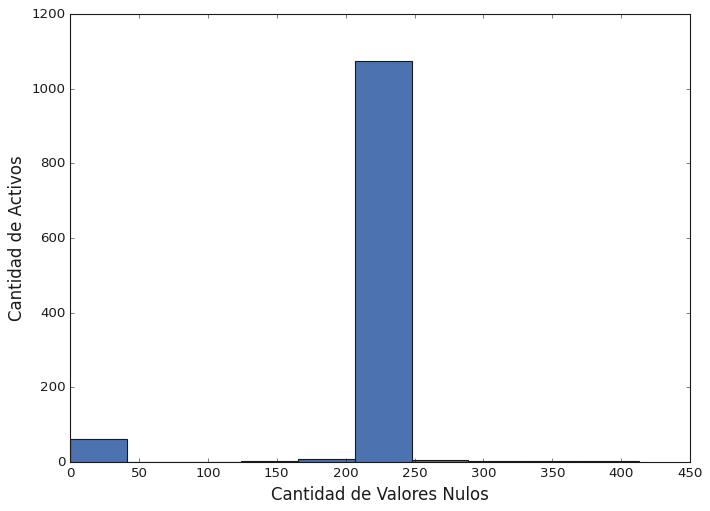

In [37]:
plt.style.use(plt.style.available[3])
fig, ax = plt.subplots(figsize = (10,7), facecolor = "White")
plt.hist(counter)
plt.xlabel("Cantidad de Valores Nulos", fontsize = 15)
plt.ylabel("Cantidad de Activos", fontsize = 15)

#plt.savefig("Histograma_valores_nulos.png", bbox_inches = "tight")
plt.show()

In [34]:
#Quiero conocer en qué índices se encuentran los valores NaN del S&P 500
indices_nan_sp = []
for i in range(len(activos)):
  if np.isnan(activos["^GSPC"][i]) == True:
    indices_nan_sp.append(i)

In [35]:
#Los activos que me sirven son aquellos que tengan los mismos valores NaN's que el S&P 500 ó que tengan menos valores NaN's pero siempre y cuando esos valores coincidan con los del S&P 500
activos_que_sirven = []

for i in activos.columns[1:]:         #El primero no se considera porque es el S&P 500
  indices_nan_activo = []
  for j in range(len(activos)):
    if np.isnan(activos[i][j]) == True:
      indices_nan_activo.append(j)

  if len(set(indices_nan_activo)&set(indices_nan_sp)) == len(indices_nan_activo):
    activos_que_sirven.append(i)

In [ ]:
activos_que_no_sirven = returnNotMatches(activos_que_sirven, activos.columns)[1]  #Los activos que NO me sirven, son la diferencia entre los que me sirven y el total de activos
activos_que_no_sirven = activos_que_no_sirven[1:]                                 #Lo anterior considera el S&P 500 (Primer elemento de la lista), ese obviamente es necesario... es el que manda
activos = activos.drop(activos_que_no_sirven, axis = 1)                           #Eliminar
activos = activos.dropna()                                                        #Se eliminan los valores nulos, y por ende, los fines de semana.


#Se elimina el petróleo debido a que en un momento de la pandemia, el precio llegó a ser negativo. Algo totalmente inesperado.
#Posteriormente debo obtener los retornos logaritmicos, y no existe el logaritmo de un negativo.
activos = activos.drop("CL=F", axis = 1)


#SE ELIMINAN TAMBIÉN DE ESTE DATAFRAME AQUELLO ACTIVOS QUE NO SE UTILIZARÁN.
activos_original = activos_original.drop(activos_que_no_sirven, axis = 1)
activos_original = activos_original.drop("CL=F", axis = 1)

In [ ]:
#SE CREA UN DATAFRAME QUE EN CONTIENE LOS RETORNOS LOGARITMICOS DE LAS SERIES
log_df = pd.DataFrame()
for i in range(len(activos.columns)):
  log_df[activos.columns[i]] = np.log(activos[activos.columns[i]]).diff().dropna()
log_df = log_df*100
log_df

^GSPC       BHP       BBL       LIN       RIO    CTA-PB  \
Date                                                                     
2020-01-02  0.834390  0.383105  0.699540 -1.019733  0.888884  2.672524   
2020-01-03 -0.708491 -0.675975 -0.976448 -2.634775 -1.768749  1.517954   
2020-01-06  0.352715 -0.110052 -0.149437 -0.424749 -0.665029 -0.872184   
2020-01-07 -0.280718  0.000000  0.277332  0.215048 -0.102708  1.088402   
2020-01-08  0.489047  0.494270  0.785154  1.242069  0.869645  0.731662   
...              ...       ...       ...       ...       ...       ...   
2021-11-23  0.165576  2.756904  2.791746  0.154557  2.908432  0.231051   
2021-11-24  0.229122 -0.090081  0.073884 -0.912557 -0.141077 -1.077146   
2021-11-26 -2.298701 -1.910711 -1.826023 -2.062372 -2.252630 -0.371250   
2021-11-29  1.311384  2.772166  2.451831  0.053016  0.973899  0.000000   
2021-11-30 -1.914338  0.410165  0.876877 -0.813928 -0.397995  0.000000   

                VALE    CTA-PA       SHW       APD  ...    ZIL-USD  WAXP-USD  \
Date                                                ...                        
2020-01-02  1.876224  1.294557 -2.023627 -1.651944  ...  -2.054944 -0.042299   
2020-01-03 -1.196721 -0.313895 -1.302499 -2.248855  ...   3.563403  4.004566   
2020-01-06 -1.135091 -0.410629 -0.184410 -0.044263  ...   6.684762  2.686989   
2020-01-07  0.682605  0.000000 -0.542834  0.424063  ...  -0.889448  5.792756   
2020-01-08 -0.075615  0.759489  1.579300  0.540737  ...  -2.439657 -3.645257   
...              ...       ...       ...       ...  ...        ...       ...   
2021-11-23  2.021905  0.000000 -0.705923  0.496220  ...   1.155681 -0.998615   
2021-11-24  1.746078 -0.319663  0.161706 -0.388712  ...  -1.482220 -2.468704   
2021-11-26 -2.711491  0.319663 -1.449390 -1.420187  ...  -8.679302 -9.230845   
2021-11-29  0.564288  0.000000  3.339831 -0.782930  ...  11.892227  5.041381   
2021-11-30 -0.564288 -0.811799 -0.913580 -1.351110  ...  -4.348315 -8.483651   

              OMG-USD    ICX-USD    VGX-USD    BNT-USD    SNX-USD     SC-USD  \
Date                                                                           
2020-01-02  -1.871692  -3.178223  41.201276 -21.660329  -9.124766  -3.284108   
2020-01-03   5.375136   2.961094   4.085497   6.983209   2.634999   5.715840   
2020-01-06   8.552144   9.729873 -10.738509   3.898809 -21.881487   5.690814   
2020-01-07  -1.645748  -3.725018   7.720671  -1.813211  10.051069   1.896788   
2020-01-08  -1.343381  -2.409471  -4.464516  -1.576338  -8.602700  -0.628271   
...               ...        ...        ...        ...        ...        ...   
2021-11-23   2.777233  -3.747221  -5.684082   4.016047   1.245320  -2.102052   
2021-11-24  -3.355849  -4.462705  -4.597059  -1.757115  -3.773330  -2.869911   
2021-11-26 -12.520436 -16.503423 -19.662160  -5.487736  -7.296864  27.286323   
2021-11-29  10.122612   4.207293   9.243106   6.510238   6.207915   0.158171   
2021-11-30  -2.369318  -1.774947  11.113555   1.288242  -2.696355 -10.018688   

              ZEN-USD   BTG-USD  
Date                             
2020-01-02 -18.830501 -3.596033  
2020-01-03   7.200091  5.355289  
2020-01-06  -9.147533  6.891259  
2020-01-07   9.436595  2.490946  
2020-01-08   8.201431  4.938336  
...               ...       ...  
2021-11-23   6.973466  0.645400  
2021-11-24   6.364150 -1.605649  
2021-11-26 -11.862038 -4.386185  
2021-11-29  11.743901  4.397205  
2021-11-30  -0.241683 -0.816122  

[483 rows x 1127 columns]

In [ ]:
#EN CASO DE QUERER DESCARGAR EL ARCHIVO
#RECOMENDADO, PORQUE EN PROCEDIMIENTOS POSTERIORES, ESTE DATAFRAME SE CARGA DIRECTAMENTE Y SE UTILIZA BAJO EL NOMBRE DE  "log_return"

#log_df.to_csv("LogReturns2.csv")
#files.download("LogReturns2.csv")

# **COMPROBANDO ESTACIONARIEDAD**

In [ ]:
#Cargar el archivo "LogReturns2.csv"
files.upload()

In [ ]:
log_return = pd.read_csv("LogReturns2.csv", index_col = "Date").drop("Unnamed: 0", axis = 1)

In [ ]:
#Se procederá a evaluar si las series de tiempo son o no estacionarias mediante el test Augmented Dickey Fuller
#H0: La serie de tiempo NO es estacionaria
#H1: La serie de tiempo SÍ es estacionaria


test_estacionaria = pd.DataFrame()
estadistico_adf = []
pvalue_adf = []
cv_1 = []
cv_5 = []
cv_10 = []

for i in range(len(log_return.columns)):
  test = adfuller(log_return[log_return.columns[i]], autolag = "AIC")
  estadistico_adf.append(test[0])
  pvalue_adf.append(test[1])
  
  critical_values = list(test[4].values())
  cv_1.append(critical_values[0])
  cv_5.append(critical_values[1])
  cv_10.append(critical_values[2])

test_estacionaria["Estadístico"] = estadistico_adf
test_estacionaria["Pvalue"] = pvalue_adf
test_estacionaria["Cv 1%"] = cv_1
test_estacionaria["Cv 5%"] = cv_5
test_estacionaria["Cv 10%"] = cv_10



estacionaria_binary = []                                                        #Toma el valor 0 si la serie NO es estacionaria

                                                                                #Toma el valor 1 si la serie SÍ es estacionaria
for i in range(len(test_estacionaria)):
  if test_estacionaria["Pvalue"][i] <= 0.05:
    estacionaria_binary.append(1)
  if test_estacionaria["Pvalue"][i] > 0.05:
    estacionaria_binary.append(0)


test_estacionaria["Estacionaria"] = estacionaria_binary
test_estacionaria.index = log_return.columns


test_estacionaria

Estadístico        Pvalue     Cv 1%     Cv 5%    Cv 10%  Estacionaria
^GSPC      -5.979734  1.850763e-07 -3.444221 -2.867657 -2.570028             1
BHP        -7.223803  2.078158e-10 -3.444192 -2.867644 -2.570021             1
BBL        -7.272720  1.573047e-10 -3.444192 -2.867644 -2.570021             1
LIN        -6.159688  7.224390e-08 -3.444221 -2.867657 -2.570028             1
RIO        -7.467188  5.167300e-11 -3.444163 -2.867631 -2.570014             1
...              ...           ...       ...       ...       ...           ...
BNT-USD   -13.491878  3.094855e-25 -3.444018 -2.867568 -2.569980             1
SNX-USD    -5.408873  3.244842e-06 -3.444281 -2.867683 -2.570042             1
SC-USD     -8.295521  4.150280e-13 -3.444163 -2.867631 -2.570014             1
ZEN-USD   -23.713025  0.000000e+00 -3.443990 -2.867555 -2.569974             1
BTG-USD    -9.912087  3.149476e-17 -3.444076 -2.867593 -2.569994             1

[1127 rows x 6 columns]

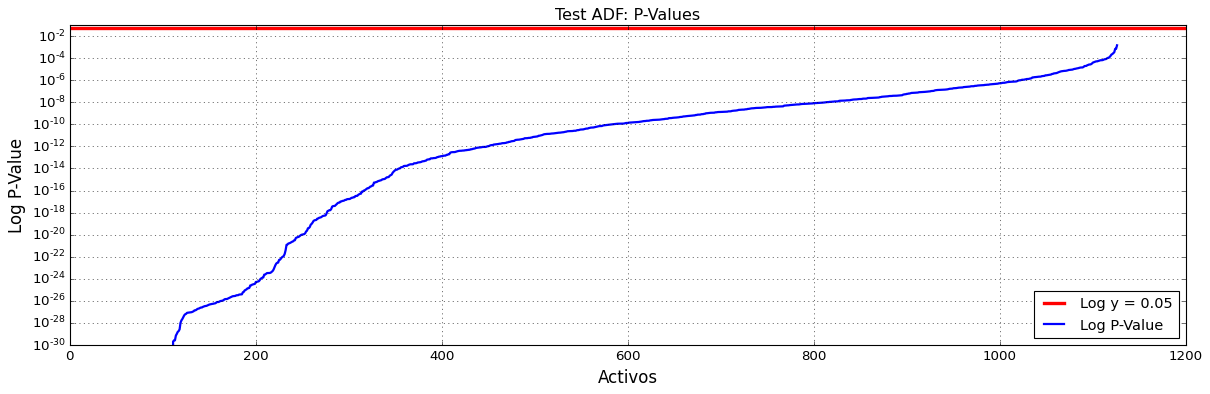

In [ ]:
#GRÁFICO PARA MOSTRAR QUE LOS P VALUES SON MENORES A 0.05 (LAS SERIES DE TIEMPO SON ESTACIONARIAS)
#PARA FINES ESTÉTICOS, SE ORDENARON LAS SERIES DE MENOR A MAYOR PVALUE
#TAMBIEN SE APLICÓ LA ESCALA LOGARITICA (SINO NO SE VEÍA NADA), LAS PRIMERAS 95 SERIES TIENEN UN PVALUE = 0 (POR ESO NO SE VEN)

lista = [*range(len(test_estacionaria))]
pvalues_sorted = sorted(test_estacionaria["Pvalue"], key= float)

plt.subplots(figsize = (18,5), facecolor = "white")
plt.axhline(y=0.05, color='r', linestyle='-', linewidth = 3, label = "Log y = 0.05")
plt.plot(lista, pvalues_sorted, linewidth = 2, label = "Log P-Value")
plt.semilogy()
plt.title("Test ADF: P-Values")
plt.xlabel("Activos", fontsize = 15)
plt.ylabel("Log P-Value", fontsize = 15)
plt.legend(loc = "lower right", edgecolor = "black", fontsize = 13)
plt.xlim(0, 1200)
plt.grid()

#plt.savefig("Pvalue_Test_ADF(LOG).png", bbox_inches = "tight")
#files.download("Pvalue_Test_ADF(LOG).png")

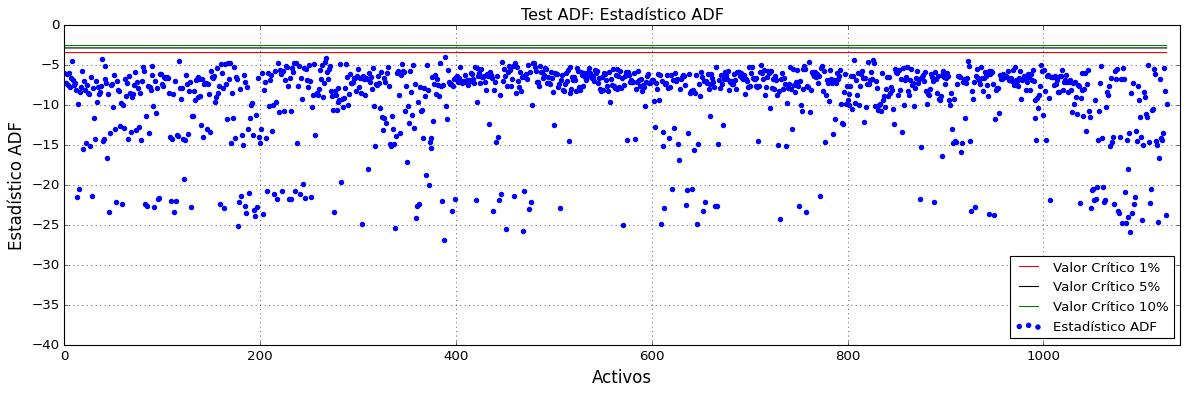

In [ ]:
#GRÁFICO PARA MOSTRAR QUE LOS ESTADÍSTICOS DEL TEST DE ADF SON MENORES A LOS VALORES CRÍTICOS (LAS SERIES DE TIEMPO SON ESTACIONARIAS)
#AQUÍ LOS DATOS SIGUEN EL ORDEN ORIGINAL, NO SEGÚN EL PVALUE
#TAMPOCO SE APLICA ESCALA LOGARÍTMICA

plt.subplots(figsize = (18,5), facecolor = "white")
plt.scatter(lista, test_estacionaria["Estadístico"], s = 15, color = "blue", label = "Estadístico ADF")
plt.plot(lista, test_estacionaria["Cv 1%"], label = "Valor Crítico 1%", color = "red")
plt.plot(lista, test_estacionaria["Cv 5%"], label = "Valor Crítico 5%", color = "black")
plt.plot(lista, test_estacionaria["Cv 10%"], label = "Valor Crítico 10%", color = "green")
plt.title("Test ADF: Estadístico ADF")
plt.legend(loc = "lower right", edgecolor = "black", fontsize = 12)
plt.xlabel("Activos", fontsize = 15)
plt.ylabel("Estadístico ADF", fontsize = 15)
plt.ylim(-40, 0)
plt.xlim(0, 1140)
plt.grid()
#plt.savefig("Estadístico_Test_ADF.png", bbox_inches = "tight")
#files.download("Estadístico_Test_ADF.png")


plt.show()

# **VALIDACIÓN MODELO DCC-GARCH**

Esta sección visualiza los resultados de los Test Ljung-Box y Adjusted Goodness of Fit del modelo DCC-GARCH (1,1), el cual se implementó en R mediante el paquete rugarch.

In [ ]:
#Cargar los archivos que aparecen en la siguiente celda!
files.upload()

In [ ]:
log_return = pd.read_csv("LogReturns2.csv", index_col = "Date").drop("Unnamed: 0", axis = 1)
sp_correlacion = pd.read_csv("sp_correlation2.csv", index_col = "Date").drop("Unnamed: 0", axis = 1)
data_residuales = pd.read_csv("data_residuales.csv", index_col= "Date").drop("Unnamed: 0", axis = 1)
test_good = pd.read_csv("goodness_test.csv", index_col = "nombres_prueba_2").drop("Unnamed: 0", axis = 1) #Test adjusted goodness of fit
box_test = pd.read_csv("ljung_test.csv", index_col= "nombres_prueba_2").drop("Unnamed: 0", axis = 1)     #Test Ljung-Box

#Arreglando los Index ya que en ambos el S&P 500 está como "sp500" y para alinearlo con los otros df, quiero que se llame "^GSPC", que es el ticker de yahoo finance
nombres = list(box_test.index)
nombres[0] = "^GSPC"
box_test.index = nombres
test_good.index = nombres

In [ ]:
#Evaluación de autocorrelación: Los activos deben tener un ljung-box > 0.05 para asegurar que no hay autocorrelación al lag 1 en los residuales estandarizados al cuadrado 
box_aprobado = []
box_rechazado = []
index_box_rechazado = []
for i in range(len(box_test)):
  if box_test.iloc[i][0] > 0.05:
    box_aprobado.append(box_test.index[i])
  else: 
    box_rechazado.append(box_test.index[i])
    index_box_rechazado.append(i)

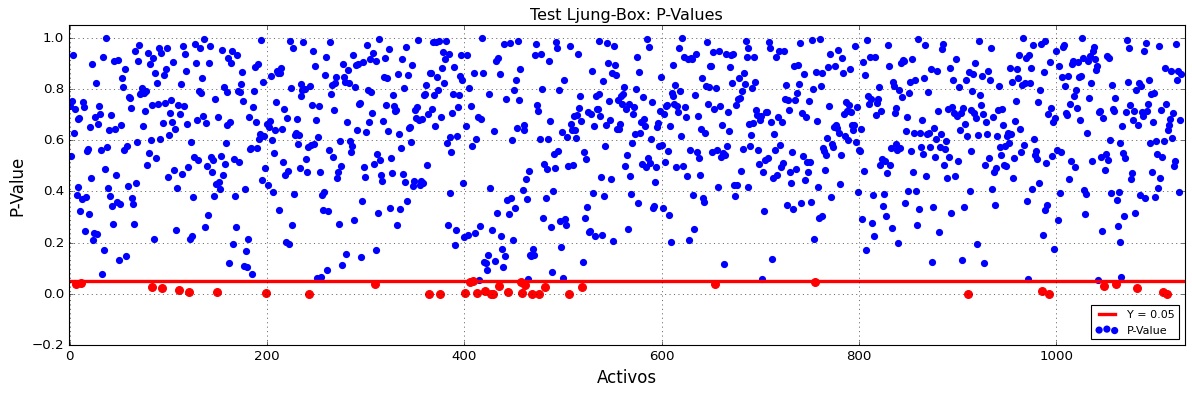

In [ ]:
#Test de Ljung Box... Si es mayor a 0.05 se acepta la hipótesis nula de que hay autocorrelación al primer lag.
lista = [*range(len(box_test))]
plt.style.use("classic")
fig, ax = plt.subplots(figsize = (18,5), facecolor = "white")
plt.scatter(lista, box_test["ljung_test"], linewidth = 2, label = "P-Value", color = "blue")
plt.scatter(index_box_rechazado, list(box_test.iloc[index_box_rechazado]["ljung_test"]), color = "r", s = 50)
plt.title("Test Ljung-Box: P-Values")
plt.axhline(y=0.05, color='r', linestyle='-', linewidth = 3, label = "Y = 0.05")
plt.legend(fontsize = 10, loc = "lower right")
plt.xlim(-1, 1130)
plt.ylim(-0.2, 1.05)
plt.xlabel("Activos", fontsize = 15)
plt.ylabel("P-Value", fontsize = 15)
plt.grid()

#plt.savefig("Ljung-Box_test.png", bbox_inches = "tight")
#files.download("Ljung-Box_test.png")
plt.show()

In [ ]:
#Evaluación de distribución: Los activos se evaluán mediante el "Adjusted Pearson Goodness of Fit". Si es mayor a 0.05, se acepta que los residuales estandarizados siguen una distribución student t
#Update... EEEEhhhh, creo que el test significa que el modelo está bien ajustado
gof_aprobado = []
gof_rechazado = []
for i in range(len(test_good)):
  if test_good["20"][i] > 0.05 and test_good["30"][i] > 0.05 and test_good["40"][i] > 0.05 and test_good["50"][i] > 0.05:
    gof_aprobado.append(test_good.index[i])
  else:
    gof_rechazado.append(test_good.index[i])
len(gof_aprobado)

1000

In [ ]:
index_20, index_30, index_40, index_50 = [], [], [], []
for i in range(len(test_good)):
  if test_good["20"][i] < 0.05:
    index_20.append(i)
  if test_good["30"][i] < 0.05:
    index_30.append(i)
  if test_good["40"][i] < 0.05:
    index_40.append(i)
  if test_good["50"][i] < 0.05:
    index_50.append(i)
index_gof_rechazados = [index_20, index_30, index_40, index_50]

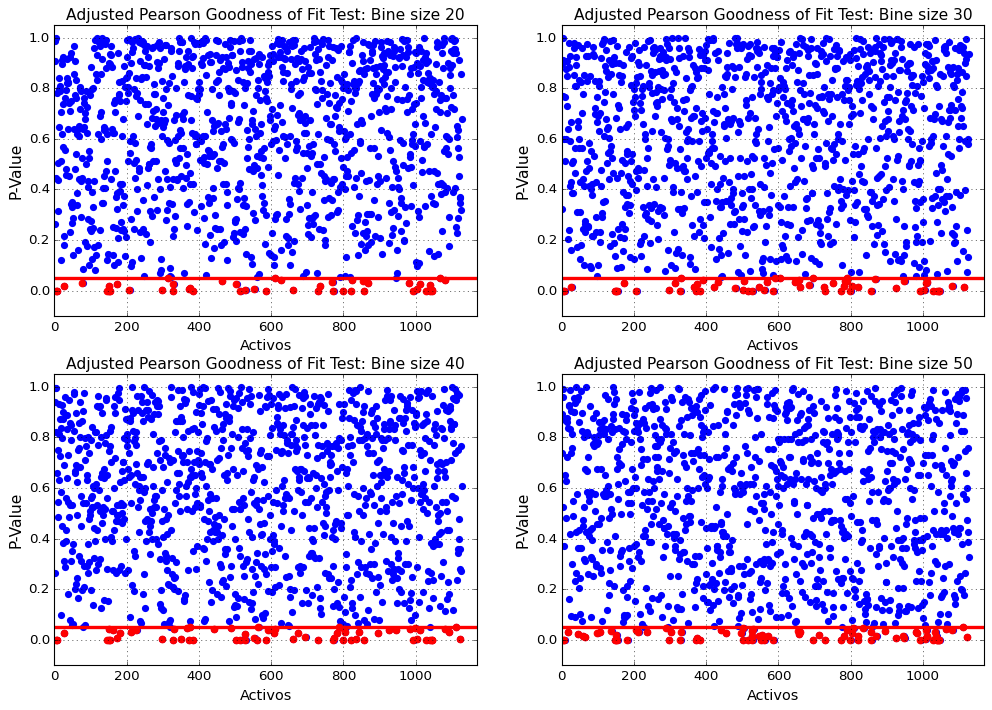

In [ ]:
lista = [*range(1,1128)]
fig, ax = plt.subplots(2,2,figsize = (15,10), facecolor = "white")
titulos = ["20", "30", "40", "50"]
indexador = 0
for i in range(2):
  for j in range(2):
    ax[i][j].scatter(lista, test_good[titulos[indexador]], color = "blue", linewidth = 2)
    ax[i][j].scatter(index_gof_rechazados[indexador], test_good.iloc[index_gof_rechazados[indexador]][titulos[indexador]], color = "red", s = 35)
    ax[i][j].axhline(y=0.05, color='r', linestyle='-', linewidth = 3, label = "Y = 0.05")
    ax[i][j].set_xlim(0, 1170)
    ax[i][j].set_ylim(-0.1, 1.05)
    ax[i][j].grid()
    ax[i][j].set_xlabel("Activos", fontsize = 13)
    ax[i][j].set_ylabel("P-Value", fontsize = 14)
    ax[i][j].set_title("Adjusted Pearson Goodness of Fit Test: Bine size " + titulos[indexador], fontsize = 14)

    indexador = indexador + 1


#plt.savefig("gof_test.png", bbox_inches = "tight")
#files.download("gof_test.png")

plt.show()

In [ ]:
#ELIMINO DE LOS DATAFRAME LOG_RETURN Y SP_CORRELACION AQUELLOS ACTIVOS QUE NO SON BIEN MODELADOS POR EL GARCH(1,1)
activos_que_sirven = list(set(box_aprobado)&set(gof_aprobado))
no_sirven = returnNotMatches(activos_que_sirven, log_return.columns)[1]
x = list(log_return.columns)

for i in no_sirven:
  x.remove(i)

log_return = log_return[x]
sp_correlacion = sp_correlacion[x[1:]]              #El dataframe de sp_correlacion no lleva al S&P 500 (Todas las correlaciones son respecto a él)
activos = activos.drop(no_sirven, axis = 1)
activos_original = activos_original.drop(no_sirven, axis = 1)

# **MODELO DE REGRESIÓN Y RESULTADOS**

In [ ]:
#NOTA: DEBIDO A QUE FINALICÉ CON LA LIMPIEZA DE ACTIVOS QUE NO SIRVEN
#HAY QUE ARREGLAR LA LISTA QUE CONTIENE LOS DATAFRAME DE LOS ACTIVOS SEPARADOS POR SECTOR.

for i in range(len(df_sector)):
  corrigiendo = list(set(df_sector[i].columns)&set(log_return.columns))
  df_sector[i] = df_sector[i][corrigiendo]

In [ ]:
for i in range(len(df_sector)):
  print(len(df_sector[i].columns), i)

85 0
84 1
92 2
83 3
71 4
70 5
85 6
89 7
73 8
87 9
77 10
15 11
0 12
1 13
51 14


In [ ]:
#EN LA CELDA ANTERIOR, SE OBSERVA QUE HAY UN SECTOR DONDE TODOS SUS ACTIVOS FUERON ELIMINADOS. (Ese sector corresponde a las monedas internacionales)
#PARA ELIMINAR POR COMPLETO LO ANTERIOR...
df_sector = df_sector[:12] + df_sector[13:]
df_sector_str.remove("currencies")

In [ ]:
#Esta linea por ahora no la utilizo, pero si la necesitaré más tarde :)
criptomonedas = list(df_sector[13].columns)

In [ ]:
resultados_modelo = []                                                          #Es un dataframe por cada activo. Contiene sus principales resultados (Coeficientes y Pvalues)
modelos = []                                                                    #Lista que contiene cada modelo (directo, crudo, el modelo en sí de statsmodels)
percentil_10 = np.percentile(log_return["^GSPC"], 10)                           #Obteniendo los threshold que corresponden a los ercentiles 10, 5 y 1 de la distribución de retornos del Sp500
percentil_5 = np.percentile(log_return["^GSPC"], 5)
percentil_1 = np.percentile(log_return["^GSPC"], 1)

#Creando las variables binarias. Cada una toma el valor 1 si el retorno en el instante t está dentro del respectivo percentil
p_10 = []
p_5 = []
p_1 = []
for i in range(1, len(log_return)):

  if log_return["^GSPC"][i] >= percentil_10:
    p_10.append(0)
  elif log_return["^GSPC"][i] < percentil_10:
    p_10.append(1)    


  if log_return["^GSPC"][i] >= percentil_5:
    p_5.append(0)
  elif log_return["^GSPC"][i] < percentil_5:
    p_5.append(1)


  if log_return["^GSPC"][i] >= percentil_1:
    p_1.append(0)
  elif log_return["^GSPC"][i] < percentil_1:
    p_1.append(1)



#Aplicando el modelo de regresion a cada uno de los activos
for i in range(1, len(log_return.columns)):
  #df_regresion es el dataframe que contiene las variables para realizar el modelo de regresión
  df_regresion = pd.DataFrame()
  df_regresion["correlacion"] = sp_correlacion[sp_correlacion.columns[i-1]]
  df_regresion["m1"] = p_10
  df_regresion["m2"] = p_5
  df_regresion["m3"] = p_1


  #Seteando el modelo de regresión
  y = df_regresion["correlacion"]                                               #Variable dependiente del modelo de regresión
  x1 = df_regresion[["m1", "m2", "m3"]]                                         #Variable independiente del modelo de regresión
  x = sm.add_constant(x1)                                                       #Añade la constante
  results = sm.OLS(y,x).fit()                                                   #Ajusta el modelo de Regresión.
  modelos.append(results)                                                       #agrega el modelo a la lista de modelos, para poder acceder a ellos en caso de ser necesario


  #Guardando los resultados en un dataframe (Este dataframe se añade a la lista de dataframes. Es decir, un DataFrame para cada activo que contiene los resultados del modelo)
  resultados = pd.DataFrame()
  resultados["parametros"] = results.params
  resultados["t values"] = results.tvalues
  resultados["p values"] = results.pvalues
  resultados.index = ["m0", "m1", "m2", "m3"]
  resultados.index.name = log_return.columns[i]
  resultados_modelo.append(resultados)

In [ ]:
#Este código es para identificar las clases en base a los resultados del modelo de regresión.

diversificador = []
cobertura_debil = []
cobertura_fuerte = []
seguro_debil = []
seguro_fuerte = []

index_diversificador = []
index_seguro_debil = []
index_seguro_fuerte = []
index_cobertura_debil = []
index_cobertura_fuerte = []


repeticiones = []                                                               #En esta lista iré guardando a cuantas categorías pertenece cada activo. (Yes, un activo puede pertenecer a más de una categoría)

for i in range(len(resultados_modelo)):
  count = 0
  
  #Es un diversificador si "m0" > 0 y es significativamente distinto de 0...    Si bien los diversificadores no son de interés, los buscamos igual para ver qué sucede    
  if resultados_modelo[i]["parametros"][0] > 0 and resultados_modelo[i]["p values"][0] < 0.05:
    diversificador.append(resultados_modelo[i].index.name)
    index_diversificador.append(i)
    count = count + 1
  
  #Es una cobertura débil si "m0" es igual a 0 (insignificativamente distinto de 0)
  if resultados_modelo[i]["p values"][0] > 0.05:
    cobertura_debil.append(resultados_modelo[i].index.name)
    index_cobertura_debil.append(i)
    count = count + 1

  #Es una cobertura fuerte si "m0" es negativo y significativamente distinto de 0:
  if resultados_modelo[i]["parametros"][0] < 0 and resultados_modelo[i]["p values"][0] < 0.05:
    cobertura_fuerte.append(resultados_modelo[i].index.name)
    index_cobertura_fuerte.append(i)
    count = count + 1

  #Es un refugio seguro débil si "m1, m2 y m3" no son significantemente distintos a 0
  if resultados_modelo[i]["p values"][1] > 0.05 and resultados_modelo[i]["p values"][2] > 0.05 and resultados_modelo[i]["p values"][3] > 0.05:
    seguro_debil.append(resultados_modelo[i].index.name)
    index_seguro_debil.append(i)
    count = count + 1

  #Es un refugio seguro fuerte si "m1, m2, m3" son negativos y significativamente distintos de 0
  if resultados_modelo[i]["parametros"][1] < 0 and resultados_modelo[i]["p values"][1] < 0.05 and resultados_modelo[i]["parametros"][2] < 0 and resultados_modelo[i]["p values"][2] < 0.05 and resultados_modelo[i]["parametros"][3] < 0 and resultados_modelo[i]["p values"][3] < 0.05 :
    seguro_fuerte.append(resultados_modelo[i].index.name)
    index_seguro_fuerte.append(i)
    count = count + 1
  repeticiones.append(count)

lista_clases = [diversificador, seguro_debil, seguro_fuerte, cobertura_debil, cobertura_fuerte] 

In [ ]:
#ESTA SECCIÓN CREA UN DATAFRAME CON LOS RESULTADOS NECESARIOS DE LA CELDA ANTERIOR.
#i.e, LOS PARAMETROS DEL MODELO DE REGRESIÓN JUNTO CON SUS RESPECTIVOS P-VALUES.

coeficientes_modelo_regresion = pd.DataFrame(columns = ["m0", "p-value(m0)", "m1", "p-value(m1)", "m2", "p-value(m2)", "m3", "p-value(m3)"])  
name = []
numero_columnas = [*range(0,963,1)]

for i in numero_columnas:

  valores = []
  valores.append(resultados_modelo[i]["parametros"][0])
  valores.append(resultados_modelo[i]["p values"][0])
  valores.append(resultados_modelo[i]["parametros"][1])
  valores.append(resultados_modelo[i]["p values"][1])
  valores.append(resultados_modelo[i]["parametros"][2])
  valores.append(resultados_modelo[i]["p values"][2])
  valores.append(resultados_modelo[i]["parametros"][3])
  valores.append(resultados_modelo[i]["p values"][3])
  name.append(resultados_modelo[i].index.name)

  new_row = {"m0": round(valores[0], 6), "p-value(m0)": round(valores[1], 6), "m1": round(valores[2], 6), "p-value(m1)": round(valores[3], 6), "m2": round(valores[4], 6), "p-value(m2)": round(valores[5], 6), "m3": round(valores[6], 6), "p-value(m3)": round(valores[7], 6)}
  coeficientes_modelo_regresion = coeficientes_modelo_regresion.append(new_row, ignore_index = True)

coeficientes_modelo_regresion.index = name
coeficientes_modelo_regresion

m0  p-value(m0)        m1  p-value(m1)        m2  p-value(m2)  \
BHP      0.611673          0.0 -0.000245     0.991586  0.087467     0.009324   
BBL      0.595595          0.0  0.003440     0.877698  0.089249     0.005879   
LIN      0.695204          0.0  0.026940     0.201792  0.048924     0.108541   
RIO      0.545267          0.0  0.016936     0.404631  0.090390     0.002164   
SHW      0.526040          0.0  0.048036     0.041013  0.070305     0.038329   
...           ...          ...       ...          ...       ...          ...   
VGX-USD  0.200153          0.0  0.002370     0.747392  0.011304     0.287493   
SNX-USD  0.188871          0.0  0.034039     0.050565 -0.026202     0.296523   
SC-USD   0.229533          0.0  0.000590     0.676861  0.005248     0.010483   
ZEN-USD  0.204350          0.0  0.034576     0.046013  0.020194     0.418763   
BTG-USD  0.166959          0.0  0.018265     0.364703  0.062899     0.030947   

               m3  p-value(m3)  
BHP      0.059265     0.284680  
BBL      0.064273     0.228195  
LIN      0.069556     0.166962  
RIO      0.078109     0.107304  
SHW      0.001049     0.985029  
...           ...          ...  
VGX-USD  0.055761     0.001566  
SNX-USD  0.019543     0.637145  
SC-USD   0.005714     0.090883  
ZEN-USD  0.073853     0.073741  
BTG-USD  0.075876     0.114577  

[963 rows x 8 columns]

In [ ]:
print(len(diversificador))
print(len(seguro_debil))
print(len(seguro_fuerte))
print(len(cobertura_debil))
print(len(cobertura_fuerte)) 

960
299
0
0
3


In [ ]:
#En esta sección se ilustran algunos activos que no son seguros fuertes pero cumplen con más de alguna condición.

casi_seguros_fuerte = []
for i in range(len(resultados_modelo)):
  if round(resultados_modelo[i]["parametros"][1], 5) < 0 and round(resultados_modelo[i]["parametros"][2], 5) < 0 and round(resultados_modelo[i]["parametros"][3], 5) < 0:
    casi_seguros_fuerte.append(resultados_modelo[i].index.name)
casi_seguros_fuerte


casi_seguros_fuerte_2 = []
for i in range(len(resultados_modelo)):
  if round(resultados_modelo[i]["parametros"][1], 5) < 0 and resultados_modelo[i]["p values"][1] < 0.05 or round(resultados_modelo[i]["parametros"][2], 5) < 0 and resultados_modelo[i]["p values"][2] < 0.05 or round(resultados_modelo[i]["parametros"][3], 5) < 0 and resultados_modelo[i]["p values"][3] < 0.05:
    casi_seguros_fuerte_2.append(resultados_modelo[i].index.name)
casi_seguros_fuerte_2


casi_seguros_fuertes = casi_seguros_fuerte + casi_seguros_fuerte_2              #OJITO: Una es casi_seguros_fuerteS, y otra es casi_seguro_fuerte.
casi_seguros_fuertes = list(dict.fromkeys(casi_seguros_fuertes))                #Hay un elemento que se repite (GILD)
casi_seguros_fuertes

['KL', 'RGLD', 'ZM', 'GILD', 'TDOC', 'GOLD', 'DPZ', 'GC=F']

In [ ]:
coeficientes_modelo_regresion.loc[casi_seguros_fuertes]

m0  p-value(m0)        m1  p-value(m1)        m2  p-value(m2)  \
KL    0.267209          0.0 -0.005751     0.850184 -0.045928     0.296417   
RGLD  0.290983          0.0 -0.011903     0.592767 -0.058739     0.067977   
ZM    0.115204          0.0 -0.041587     0.145032 -0.056549     0.169849   
GILD  0.297950          0.0 -0.001517     0.767295 -0.015998     0.031089   
TDOC  0.192782          0.0 -0.008869     0.706658 -0.052257     0.124990   
GOLD  0.234171          0.0  0.008304     0.650377 -0.053371     0.044063   
DPZ   0.144624          0.0  0.004967     0.312898 -0.018487     0.009494   
GC=F  0.073116          0.0  0.009141     0.270520 -0.033438     0.005397   

            m3  p-value(m3)  
KL   -0.000527     0.994211  
RGLD -0.000314     0.995273  
ZM   -0.031287     0.645311  
GILD -0.002870     0.814365  
TDOC -0.064524     0.251103  
GOLD -0.016173     0.711216  
DPZ   0.035584     0.002533  
GC=F -0.030932     0.118089

# **VISUALIZACIÓN DE RESULTADOS**

COBERTURAS DÉBILES

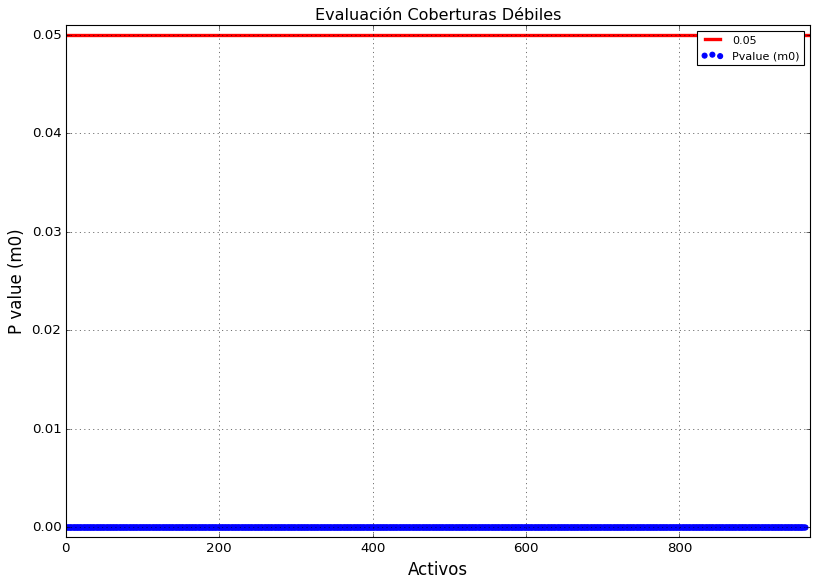

In [ ]:
#ESTA SECCIÓN DE CÓDIGO ES LA QUE UTILICÉ PARA EL GRÁFICO QUE MUESTRA LOS RESULTADOS DE LAS COBERTURAS DÉBILES

lista = [*range(1,964,1)]
plt.subplots(figsize = (12,8), facecolor = "white")
plt.scatter(lista, coeficientes_modelo_regresion["p-value(m0)"], linewidth = 1, label = "Pvalue (m0)", color = "blue")
plt.axhline(y=0.05, color='r', linestyle='-', linewidth = 3, label = "0.05")

plt.xlabel("Activos", fontsize = 15)
plt.ylabel("P value (m0)", fontsize = 15)
plt.title("Evaluación Coberturas Débiles")

plt.legend(loc = "upper right", edgecolor = "black", fontsize = 10)
plt.xlim(0, 970)
plt.ylim(-0.001, 0.051)
plt.grid()

#plt.savefig("Coberturas_debiles.png", bbox_inches = "tight")
#files.download("Coberturas_debiles.png")

plt.show()

COBERTURAS FUERTES

In [ ]:
coeficientes_modelo_regresion.loc[cobertura_fuerte]

m0  p-value(m0)        m1  p-value(m1)        m2  p-value(m2)  \
ZR=F    -0.019215          0.0  0.000000     0.671824  0.000000     0.531392   
ZM=F    -0.006178          0.0 -0.000000     0.475189  0.000000     0.329784   
HEX-USD -0.016395          0.0  0.004195     0.677223 -0.014026     0.335229   

               m3  p-value(m3)  
ZR=F     0.000000     0.731281  
ZM=F     0.000000     0.003461  
HEX-USD -0.033723     0.160857

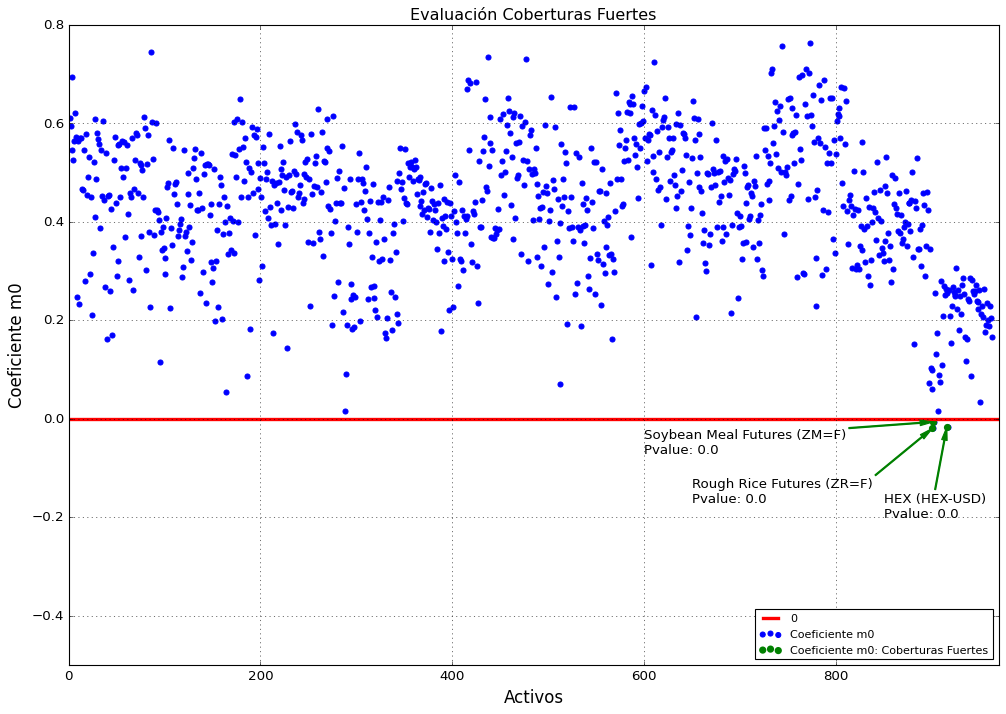

In [ ]:
#ESTA SECCIÓN DE CÓDIGO ES LA QUE UTILICÉ PARA EL GRÁFICO QUE MUESTRA LOS RESULTADOS DE LAS COBERTURAS FUERTES

lista = [*range(1,964,1)]
plt.subplots(figsize = (15,10), facecolor = "white")
plt.scatter(lista, coeficientes_modelo_regresion["m0"], linewidth = 1, label = "Coeficiente m0", color = "blue")
plt.scatter(index_cobertura_fuerte, coeficientes_modelo_regresion["m0"].iloc[index_cobertura_fuerte], linewidth = 2, label = "Coeficiente m0: Coberturas Fuertes", color = "Green")
plt.axhline(y=0, color='r', linestyle='-', linewidth = 3, label = "0")



plt.annotate("Rough Rice Futures (ZR=F)\nPvalue: 0.0 ", xy=(901, -0.019215), xytext=(650, -0.17), arrowprops=dict(width = 1, headwidth = 5, facecolor = "green", edgecolor = "green"))
plt.annotate("Soybean Meal Futures (ZM=F)\nPvalue: 0.0", xy=(902, -0.006178), xytext=(600, -0.07), arrowprops=dict(width = 1, headwidth = 5, facecolor = "green", edgecolor = "green"))
plt.annotate("HEX (HEX-USD)\nPvalue: 0.0", xy=(916, -0.016395), xytext=(850, -0.2), arrowprops=dict(width = 1, headwidth = 5, facecolor = "green", edgecolor = "green"))

plt.xlabel("Activos", fontsize = 15)
plt.ylabel("Coeficiente m0", fontsize = 15)
plt.title("Evaluación Coberturas Fuertes")

plt.legend(loc = "lower right", edgecolor = "black", fontsize = 10)
plt.xlim(0, 970)
plt.ylim(-0.5, 0.8)
plt.grid()

#plt.savefig("Coberturas_fuertes.png", bbox_inches = "tight")
#files.download("Coberturas_fuertes.png")

plt.show()

In [ ]:
tabla_coberturas_fuertes = pd.DataFrame()
m0 = list(coeficientes_modelo_regresion.loc[cobertura_fuerte]["m0"])
Pvaluem0 = list(coeficientes_modelo_regresion.loc[cobertura_fuerte]["p-value(m0)"])

tabla_coberturas_fuertes["Cobertura Fuerte (m0)"] = m0
tabla_coberturas_fuertes["Pvalue(m0)"] = Pvaluem0
tabla_coberturas_fuertes.index = ["Rough Rice Futures (ZR=F)", "Soybean Meal Futures (ZM=F)", "HEX (HEX-USD)"]
tabla_coberturas_fuertes.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &  Cobertura Fuerte (m0) &  Pvalue(m0) \\\\\n\\midrule\nRough Rice Futures (ZR=F)   &              -0.019215 &         0.0 \\\\\nSoybean Meal Futures (ZM=F) &              -0.006178 &         0.0 \\\\\nHEX (HEX-USD)               &              -0.016395 &         0.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

SEGUROS DÉBILES

In [ ]:
#Voy a crear una lista que contenga aquellos activos que no fueron refugios debiles
not_seguro_debil = list(log_return.columns[1:]) 
for i in seguro_debil:
  not_seguro_debil.remove(i)

#SEGURO_DEBIL --> LISTA CON ACTIVOS QUE SON SEGUROS DÉBILES
#NOT_SEGURO_DEBIL --> LISTA CON ACTIVOS QUE NO SON SEGUROS DÉBILES

In [ ]:
#Lista: seguro_debil ó not_seguro_debil
#rango_menor: desde qué elemento de la "Lista" se va a mostrar
#rango_mayor: hasta qué elemento de la "Lista" se va a mostrar
#download: Si se quiere descargar el gráfico "True", else, "False"
#name_file: nombre del archivo que se va a descargar (sin .png)

def plot_seguros_debiles(lista, rango_menor, rango_mayor, download, name_file):

  eje_x = [*range(1, rango_mayor - rango_menor + 1, 1)]                             #El eje x es una lista de numeros del 1 hasta la cantidad de elementos que se van a mostrar
  fig, ax = plt.subplots(figsize = (28,7), facecolor = "white")

  plt.scatter(eje_x, coeficientes_modelo_regresion["p-value(m1)"][lista[rango_menor : rango_mayor]], marker = "o", s = 40, label = "Pvalue m1", color = "red", alpha = 0.8)     #Plot el PValue del coef m1
  plt.scatter(eje_x, coeficientes_modelo_regresion["p-value(m2)"][lista[rango_menor : rango_mayor]], marker = "^", s = 40, label = "Pvalue m2", color = "blue", alpha = 0.8)     #Plot el PValue del coef m2
  plt.scatter(eje_x, coeficientes_modelo_regresion["p-value(m3)"][lista[rango_menor : rango_mayor]], marker = "s", s = 30, label = "Pvalue m3", color = "green", alpha = 0.8)     #Plot el PValue del coef m2

  #Seteando el eje x con los nombres de los activos que le corresponden
  ax.set_xticks(eje_x)
  ax.set_xticklabels(lista[rango_menor: rango_mayor], rotation = 90, fontsize = 14, color = "black")

  plt.axhline(y=0.05, color='black', linestyle='-', linewidth =  1, label = "0.05")
  plt.xlabel("Activos", fontsize = 15)
  plt.ylabel("Pvalues", fontsize = 15)


  plt.legend(loc = "upper right", edgecolor = "black", fontsize = 12, framealpha = 0.3)
  plt.xlim(0, rango_mayor - rango_menor + 1)
  plt.ylim(-0.2, 1.2)
  plt.grid()
  

  #Descargar imagen
  if download == True:
    plt.savefig(name_file + ".png", bbox_inches = "tight")
    files.download(name_file + ".png")
  
  plt.show()                

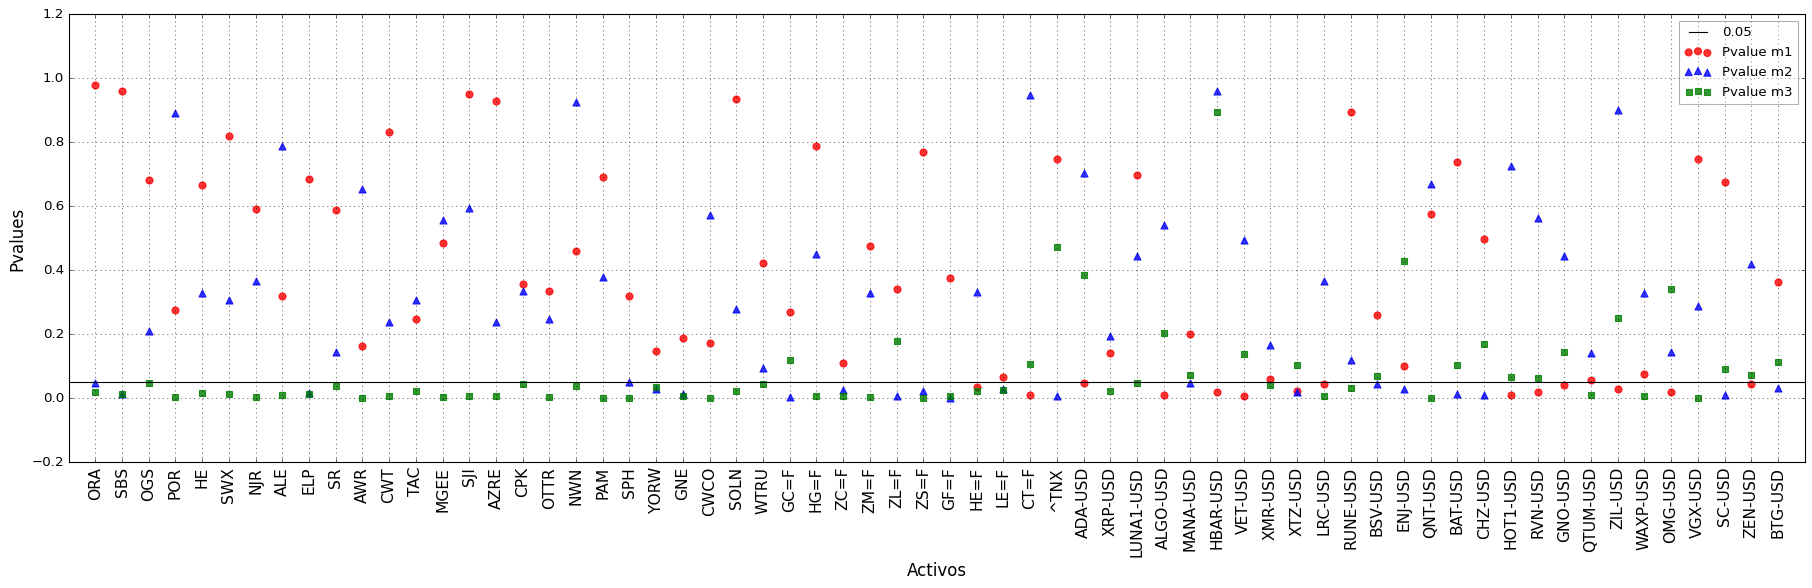

In [ ]:
plot_seguros_debiles(not_seguro_debil, 600, len(not_seguro_debil), False, "whatever")

SEGUROS FUERTES (Es la misma lógica que en los seguros débiles)

In [ ]:
#Ningún activo fue considerado como seguro fuerte
#Pero hubo casos que casi lo fueron (no lo fueron porque no cumplieron estrictamente con las 6 condiciones)
#Esos activos serán separados y se mostrarán sus resultados en una tabla para hablar específicamente de ellos
#El resto de los activos mostraré sus resultados al igual que para los seguros débiles

not_seguro_fuerte = list(log_return.columns[1:]) 
for i in casi_seguros_fuertes:
  not_seguro_fuerte.remove(i)

#NOTA: hay activos que fueron CAAASIII seguros fuertes. Esos activos fueron importantes, y se mostrarán en una tabla para hablar de ellos

In [ ]:
#En este caso se elimina la variable lista porque solo se mostrarán los "not_seguro_fuerte"
#rango_menor: desde qué elemento de la "Lista" se va a mostrar
#rango_mayor: hasta qué elemento de la "Lista" se va a mostrar
#download: Si se quiere descargar el gráfico "True", else, "False"
#name_file: nombre del archivo que se va a descargar (sin .png)

def plot_not_seguros_fuertes(rango_menor, rango_mayor, download, name_file):

  eje_x = [*range(1, rango_mayor - rango_menor + 1, 1)]                             #El eje x es una lista de numeros del 1 hasta la cantidad de elementos que se van a mostrar
  fig, ax = plt.subplots(figsize = (28,7), facecolor = "white")

  plt.scatter(eje_x, coeficientes_modelo_regresion["m1"][not_seguro_fuerte[rango_menor : rango_mayor]], marker = "o", s = 40, label = "Coeficiente m1", color = "red", alpha = 0.8)     #Plot Coeficiente m1
  plt.scatter(eje_x, coeficientes_modelo_regresion["m2"][not_seguro_fuerte[rango_menor : rango_mayor]], marker = "^", s = 40, label = "Coeficiente m2", color = "blue", alpha = 0.8)     #Plot Coeficiente m2
  plt.scatter(eje_x, coeficientes_modelo_regresion["m3"][not_seguro_fuerte[rango_menor : rango_mayor]], marker = "s", s = 30, label = "Coeficiente m3", color = "green", alpha = 0.8)     #Plot Coeficiente m3

  #Seteando el eje x con los nombres de los activos que le corresponden
  ax.set_xticks(eje_x)
  ax.set_xticklabels(not_seguro_fuerte[rango_menor: rango_mayor], rotation = 90, fontsize = 14, color = "black")

  plt.axhline(y=0., color='black', linestyle='-', linewidth =  1)
  plt.xlabel("Activos", fontsize = 15)
  plt.ylabel("coeficientes", fontsize = 15)


  plt.legend(loc = "upper right", edgecolor = "black", fontsize = 12, framealpha = 0.3)
  plt.xlim(0, rango_mayor - rango_menor + 1)
  plt.grid()
  

  #Descargar imagen
  if download == True:
    plt.savefig(name_file + ".png", bbox_inches = "tight")
    files.download(name_file + ".png")
  
  plt.show()   

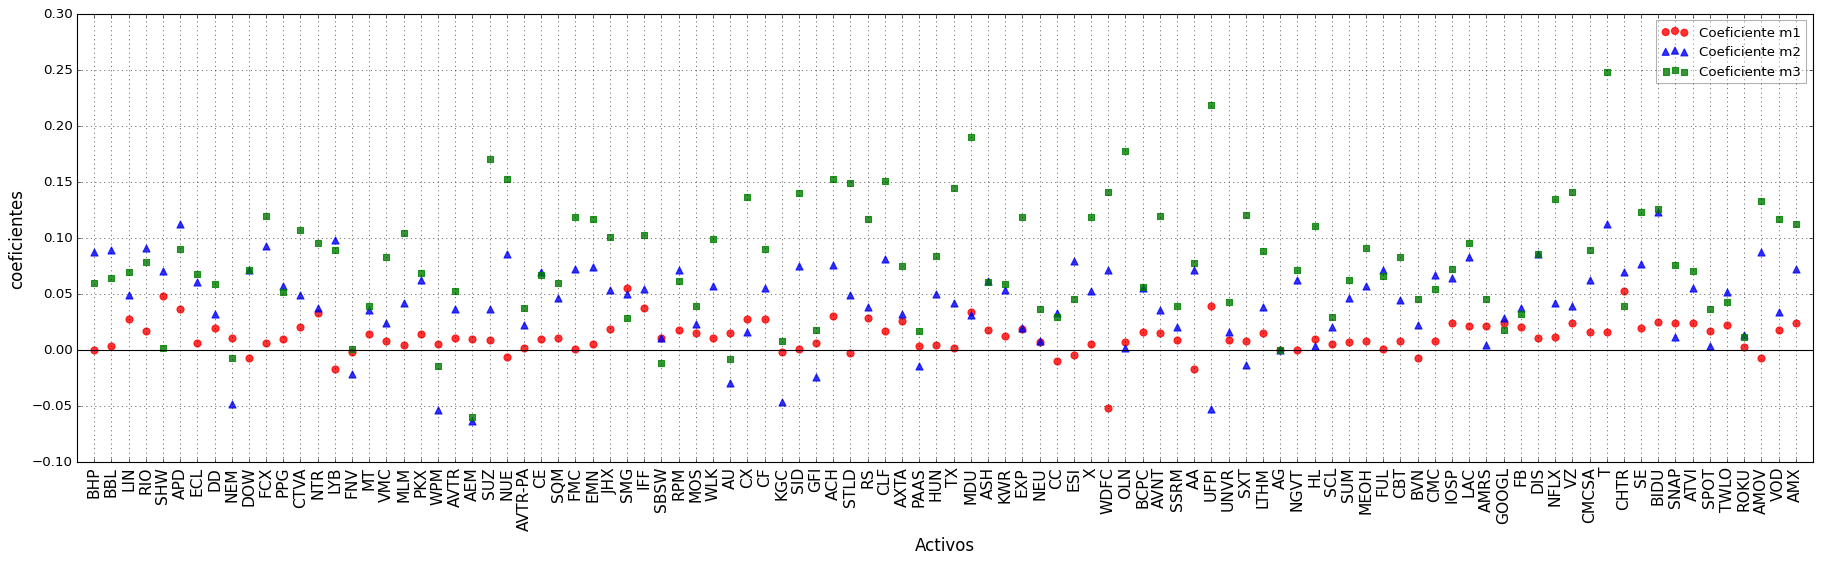

In [ ]:
plot_not_seguros_fuertes(0, 100, False, "whatever")

In [ ]:
#Tabla que muestra los activos que estuvieron más cerca de ser refugios seguros Fuertes

tabla_casi_seguro_fuerte = pd.DataFrame()
tabla_casi_seguro_fuerte["Cuantil 10% (m1)"] = coeficientes_modelo_regresion["m1"][casi_seguros_fuertes]
tabla_casi_seguro_fuerte["Pvalue (m1)"] = coeficientes_modelo_regresion["p-value(m1)"][casi_seguros_fuertes]
tabla_casi_seguro_fuerte["Cuantil 5% (m2)"] = coeficientes_modelo_regresion["m2"][casi_seguros_fuertes]
tabla_casi_seguro_fuerte["Pvalue (m2)"] = coeficientes_modelo_regresion["p-value(m2)"][casi_seguros_fuertes]
tabla_casi_seguro_fuerte["Cuantil 1% (m3)"] = coeficientes_modelo_regresion["m3"][casi_seguros_fuertes]
tabla_casi_seguro_fuerte["Pvalue (m3)"] = coeficientes_modelo_regresion["p-value(m3)"][casi_seguros_fuertes]
tabla_casi_seguro_fuerte.index = ["Kirkland Lake Gold Ltd. (KL)", "Royal Gold, Inc. (RGLD)", "Zoom Video Communications, Inc. (ZM)", "Gilead Sciences, Inc. (GILD)" ,"Teladoc Health, Inc. (TDOC)", "Barrick Gold Corporation (GOLD)", "Domino's Pizza, Inc. (DPZ)" ,"Gold Futures (GC=F)"]
#tabla_casi_seguro_fuerte.to_latex()
tabla_casi_seguro_fuerte

Cuantil 10% (m1)  Pvalue (m1)  \
Kirkland Lake Gold Ltd. (KL)                 -0.005751     0.850184   
Royal Gold, Inc. (RGLD)                      -0.011903     0.592767   
Zoom Video Communications, Inc. (ZM)         -0.041587     0.145032   
Gilead Sciences, Inc. (GILD)                 -0.001517     0.767295   
Teladoc Health, Inc. (TDOC)                  -0.008869     0.706658   
Barrick Gold Corporation (GOLD)               0.008304     0.650377   
Domino's Pizza, Inc. (DPZ)                    0.004967     0.312898   
Gold Futures (GC=F)                           0.009141     0.270520   

                                      Cuantil 5% (m2)  Pvalue (m2)  \
Kirkland Lake Gold Ltd. (KL)                -0.045928     0.296417   
Royal Gold, Inc. (RGLD)                     -0.058739     0.067977   
Zoom Video Communications, Inc. (ZM)        -0.056549     0.169849   
Gilead Sciences, Inc. (GILD)                -0.015998     0.031089   
Teladoc Health, Inc. (TDOC)                 -0.052257     0.124990   
Barrick Gold Corporation (GOLD)             -0.053371     0.044063   
Domino's Pizza, Inc. (DPZ)                  -0.018487     0.009494   
Gold Futures (GC=F)                         -0.033438     0.005397   

                                      Cuantil 1% (m3)  Pvalue (m3)  
Kirkland Lake Gold Ltd. (KL)                -0.000527     0.994211  
Royal Gold, Inc. (RGLD)                     -0.000314     0.995273  
Zoom Video Communications, Inc. (ZM)        -0.031287     0.645311  
Gilead Sciences, Inc. (GILD)                -0.002870     0.814365  
Teladoc Health, Inc. (TDOC)                 -0.064524     0.251103  
Barrick Gold Corporation (GOLD)             -0.016173     0.711216  
Domino's Pizza, Inc. (DPZ)                   0.035584     0.002533  
Gold Futures (GC=F)                         -0.030932     0.118089

In [ ]:
#ESTA TABLA RESUME LOS RESULTADOS DE LOS ACTIVOS REFUGIOS Y COBERTURAS SEGÚN EL SECTOR AL QUE PERTENECEN
refugios_debiles, refugios_fuertes, coberturas_debiles, coberturas_fuertes = [], [], [], []
por1, por2, por3, por4 = [], [], [], []

lista_suprema_resultados_oficiales = [seguro_debil, seguro_fuerte, cobertura_debil, cobertura_fuerte]       #lista que contiene las listas con los resultados finales (Pero necesito separarlas según el sector)
lista_suprema = [refugios_debiles, refugios_fuertes, coberturas_debiles, coberturas_fuertes]                #lista que contiene las listas con los resultados finales separados por sector al que pertenecen

lista_porcentajes = [por1, por2, por3, por4]
for i in range(len(lista_suprema)):
  for j in range(len(df_sector)):
    x = list(set(df_sector[j].columns)&set(lista_suprema_resultados_oficiales[i]))                          #Coincidencias entre cada etiqueta con cada uno de los sectores
    x = len(x)                                                                                              #Lo que me interesa son las cantidades
    porcentaje = round(x/len(df_sector[j].columns)*100,2)
    porcentaje = str(porcentaje) + "%"

    lista_porcentajes[i].append(porcentaje)
    x = str(x) + "/" + str(len(df_sector[j].columns))
    lista_suprema[i].append(x)


tabla_resultados_x_sector = pd.DataFrame()
tabla_resultados_x_sector["Refugios Seguros Débiles"] = lista_suprema[0]
tabla_resultados_x_sector["%0"] = lista_porcentajes[0]
tabla_resultados_x_sector["Refugios Seguros Fuertes"] = lista_suprema[1]
tabla_resultados_x_sector["%1"] = lista_porcentajes[1]
tabla_resultados_x_sector["Coberturas Débiles"] = lista_suprema[2]
tabla_resultados_x_sector["%2"] = lista_porcentajes[2]
tabla_resultados_x_sector["Coberturas Fuertes"] = lista_suprema[3]
tabla_resultados_x_sector["%3"] = lista_porcentajes[3]

nombre_tabla = ["Materiales Básicos", "Servicios de Comunicación" ,"Consumidor Cíclico", "Consumidor Defensivo", "Servicios de Energía", "Servicios Financieros", "Cuidado de la Salud", "Servicios Industriales", "Bienes Raíces", "Tecnología", "Servicios Básicos", "Futuros", "Bonos", "Criptomonedas"]
tabla_resultados_x_sector.index = nombre_tabla
tabla_resultados_x_sector.loc["TOTAL"] = ["299/963", "31.05%", "0/963", "0%", "0/963", "0%", "3/963", "0.32%"]
tabla_resultados_x_sector

Refugios Seguros Débiles      %0  \
Materiales Básicos                           29/85  34.12%   
Servicios de Comunicación                    28/84  33.33%   
Consumidor Cíclico                           32/92  34.78%   
Consumidor Defensivo                         24/83  28.92%   
Servicios de Energía                         16/71  22.54%   
Servicios Financieros                        24/70  34.29%   
Cuidado de la Salud                          27/85  31.76%   
Servicios Industriales                       26/89  29.21%   
Bienes Raíces                                10/73   13.7%   
Tecnología                                   38/87  43.68%   
Servicios Básicos                            16/77  20.78%   
Futuros                                       5/15  33.33%   
Bonos                                          0/1    0.0%   
Criptomonedas                                24/51  47.06%   
TOTAL                                      299/963  31.05%   

                          Refugios Seguros Fuertes    %1 Coberturas Débiles  \
Materiales Básicos                            0/85  0.0%               0/85   
Servicios de Comunicación                     0/84  0.0%               0/84   
Consumidor Cíclico                            0/92  0.0%               0/92   
Consumidor Defensivo                          0/83  0.0%               0/83   
Servicios de Energía                          0/71  0.0%               0/71   
Servicios Financieros                         0/70  0.0%               0/70   
Cuidado de la Salud                           0/85  0.0%               0/85   
Servicios Industriales                        0/89  0.0%               0/89   
Bienes Raíces                                 0/73  0.0%               0/73   
Tecnología                                    0/87  0.0%               0/87   
Servicios Básicos                             0/77  0.0%               0/77   
Futuros                                       0/15  0.0%               0/15   
Bonos                                          0/1  0.0%                0/1   
Criptomonedas                                 0/51  0.0%               0/51   
TOTAL                                        0/963    0%              0/963   

                             %2 Coberturas Fuertes      %3  
Materiales Básicos         0.0%               0/85    0.0%  
Servicios de Comunicación  0.0%               0/84    0.0%  
Consumidor Cíclico         0.0%               0/92    0.0%  
Consumidor Defensivo       0.0%               0/83    0.0%  
Servicios de Energía       0.0%               0/71    0.0%  
Servicios Financieros      0.0%               0/70    0.0%  
Cuidado de la Salud        0.0%               0/85    0.0%  
Servicios Industriales     0.0%               0/89    0.0%  
Bienes Raíces              0.0%               0/73    0.0%  
Tecnología                 0.0%               0/87    0.0%  
Servicios Básicos          0.0%               0/77    0.0%  
Futuros                    0.0%               2/15  13.33%  
Bonos                      0.0%                0/1    0.0%  
Criptomonedas              0.0%               1/51   1.96%  
TOTAL                        0%              3/963   0.32%

# **CARACTERÍSTICAS Y COEFICIENTES**

Cómo hay activos que poseen datos en los fines de semanas y otros que no, las características y coeficientes son calculadas de forma separada.

In [ ]:
#RETORNOS DE LOS ACTIVOS PERTENECIENTES AL MERCADO TRADICIONAL (SIN DATOS LOS FINES DE SEMANA)
return_tradicional = log_return[log_return.columns[:913]].copy()                
return_tradicional = return_tradicional.drop("^GSPC", axis = 1)                 #El S&P 500 no se considera dentro del análisis de clusters, solo para ver quienes son refugios o coberturas respecto a él.

In [ ]:
#RETORNOS DE LAS CRIPTOMONEDAS (DATOS EN LOS FINES DE SEMANA)
precios_criptomonedas = activos_original[activos_original.columns[913:]].copy() 

return_criptomonedas = pd.DataFrame()
for i in range(len(precios_criptomonedas.columns)):
  return_criptomonedas[precios_criptomonedas.columns[i]] = np.log(precios_criptomonedas[precios_criptomonedas.columns[i]]).diff().dropna()
return_criptomonedas = return_criptomonedas*100

In [ ]:
#SE CREA EL DATAFRAME "RETORNO MEDIO - VARIANZA" DE CADA ACTIVO

retorno_varianza = pd.DataFrame()
retorno_medio = []
varianza = []

#ACTIVOS TRADICIONALES
for i in range(len(return_tradicional.columns)):
  retorno_medio.append(return_tradicional[return_tradicional.columns[i]].mean())
  varianza.append(return_tradicional[return_tradicional.columns[i]].var())

#CRIPTOMONEDAS
for i in range(len(return_criptomonedas.columns)):
  retorno_medio.append(return_criptomonedas[return_criptomonedas.columns[i]].mean())
  varianza.append(return_criptomonedas[return_criptomonedas.columns[i]].var())

retorno_varianza["retorno_medio"] = retorno_medio
retorno_varianza["varianza"] = varianza
retorno_varianza.index = log_return.columns[1:]

retorno_varianza

retorno_medio   varianza
BHP           0.033890   6.885250
BBL           0.064610   7.922464
LIN           0.088973   3.852268
RIO           0.032898   6.032578
SHW           0.113670   4.525107
...                ...        ...
VGX-USD       0.797996  96.281943
SNX-USD       0.256477  61.217421
SC-USD        0.408459  58.865769
ZEN-USD       0.351263  59.975634
BTG-USD       0.335425  56.534438

[963 rows x 2 columns]

In [ ]:
#SE CREA EL DATAFRAME "SKEW_KURT" QUE CONTIENE LA ASIMETRÍA Y CURTOSIS DE LOS RETORNOS DE CADA ACTIVO

skew_kurt = pd.DataFrame()
skew = []
kurt = []

#ACTIVOS TRADICIONALES
for i in range(len(return_tradicional.columns)):
  skew.append(st.skew(return_tradicional[return_tradicional.columns[i]]))
  kurt.append(st.kurtosis(return_tradicional[return_tradicional.columns[i]]))

#CRIPTOMONEDAS
for j in range(len(return_criptomonedas.columns)):
  skew.append(st.skew(return_criptomonedas[return_criptomonedas.columns[j]]))
  kurt.append(st.kurtosis(return_criptomonedas[return_criptomonedas.columns[j]]))

skew_kurt["skew"] = skew
skew_kurt["curtosis"] = kurt
skew_kurt.index = log_return.columns[1:]
skew_kurt

skew   curtosis
BHP     -0.745964   8.778132
BBL     -0.906611  11.330003
LIN     -0.202766   7.350531
RIO      0.149348   5.240345
SHW     -1.369191  23.530431
...           ...        ...
VGX-USD  0.858795  10.282128
SNX-USD -0.622792   4.465004
SC-USD  -0.752033   9.087240
ZEN-USD -0.311519   7.538032
BTG-USD  1.175578  20.478786

[963 rows x 2 columns]

COEFICIENTES ALFA - BETA DE LOS MODELOS GARCH(1,1)

In [ ]:
#ESTE DATAFRAME CONTIENE LOS ALFA - BETA OBTENIDOS TRAS LA ESTIMACIÓN DE LA CORRELACIÓN DINÁMICA
alfa_beta = pd.read_csv("coeficientes_dccgarch2.csv", index_col = "nombres").drop("Unnamed: 0", axis = 1)
alfa_beta = alfa_beta[["alfa", "beta"]]

#EN ESE PROCEDIMIENTO, SE ESTIMÓ EL MODELO PARA TODOS LOS ACTIVOS QUE SATISFAJERON LA CANTIDAD DE VALORES NULOS
#HAY QUE CONSIDERAR SOLO LOS ACTIVOS QUE PASARON LA VALIDACIÓN DEL MODELO
alfa_beta = alfa_beta.loc[list(retorno_varianza.index)]

#FINALMENTE, SOLO SE EXTRAEN LOS ALFA Y BETA SE AQUELLOS ACTIVOS QUE NO POSEEN DATOS LOS FINES DE SEMANA
#PARA CRIPTOMONEDAS, SE ESTIMA DENUEVO EL MODELO CONSIDERANDO SUS VALORES DE LOS FINES DE SEMANA
alfa_beta_tradicional = alfa_beta.iloc[:912].copy()

In [ ]:
#ALFA Y BETA PARA CRIPTOMONEDAS CON TODOS SUS DATOS
alfa_beta_cripto = pd.read_csv("alfa_beta_criptomonedas.csv").drop("Unnamed: 0", axis = 1)
alfa_beta_cripto = alfa_beta_cripto.drop("nombres", axis = 1)
alfa_beta_cripto.index = return_criptomonedas.columns

#UNIENDO AMBOS DATAFRAMES
frames = [alfa_beta_tradicional, alfa_beta_cripto]
alfa_beta = pd.concat(frames)

# **DESCOMPOSICIÓN DE SERIES TEMPORALES: TREND - SEASON**

In [ ]:
#NECESITO UN DATAFRAME CON EL PRECIO DE LOS ACTIVOS TRADICIONALES EMPEZANDO DESDE EL PRIMER LUNES
precios_tradicional = activos[3:].copy()
precios_tradicional = precios_tradicional[precios_tradicional.columns[1:913]]   #El primero es el S&P500 y no se considera

In [ ]:
#PRECIOS DE LAS CRIPTOMONEDAS EMPEZANDO DESDE EL PRIMER LUNES
precios_criptomonedas = precios_criptomonedas[6:].copy()

In [ ]:
#TRANSFORMACIÓN BOX COX PARA CADA UNA DE LAS SERIES
parametro = list(np.arange(0, 1.05, 0.05))                #PARA CADA SERIE HAY QUE AJUSTAR UN PARÁMETRO DE TRANSFORMACIÓN. HAY QUE PROBAR CON VALORES ENTRE [0,1] DE FORMA QUE LOS RESIDUALES DE LA DESCOMPOSICIÓN DE LA SERIE TRANSFORMADA SEA LO MÁS NORMAL POSIBLE (MINIMIZANDO SHAPIRO WILKS)
resultados_box_cox = []

#ACTIVOS TRADICIONALES
for i in range(len(precios_tradicional.columns)):
  resultados_series = []
  resultados_series.append(precios_tradicional.columns[i])                       #Anota primero el nombre de la serie


  #Prueba para cada uno de los posibles parámetros
  for j in parametro:
    serie_transformada = []

    #Transforma la serie utilizando cada parámetro
    for k in range(len(precios_tradicional)):  
      Y_t_transformado = ((precios_tradicional[precios_tradicional.columns[i]][k]**j)-1)/j
      serie_transformada.append(Y_t_transformado)

    result = STL(serie_transformada, period = 5).fit()                           #El período se ajusta = 5 porque en el mercado tradicional, 5 días corresponden a una semana (la estación)
    residual = result.resid

    #Test de Normalidad para los residuales
    shapiro = st.shapiro(residual)[0]
    resultados_series.append(shapiro)
    
  resultados_box_cox.append(resultados_series)

In [ ]:
#MUESTRA LOS RESULTADOS DE SHAPIRO WILKS PARA CADA SERIE Y PARA CADA UNO DE LOS PARAMETROS PROBADOS

parametro_fixed = [round(i,3) for i in parametro]
columnas = ["activos"] + [str(i) for i in parametro_fixed]
df_shapiro = pd.DataFrame(columns = columnas)
for i in range(len(resultados_box_cox)):
  df_shapiro.loc[i] = resultados_box_cox[i]
df_shapiro.set_index('activos', inplace=True)
df_shapiro = df_shapiro.drop("0.0", axis = 1)
df_shapiro = df_shapiro.drop("1.0", axis = 1)
df_shapiro

0.05       0.1      0.15       0.2      0.25       0.3      0.35  \
activos                                                                         
BHP      0.954933  0.958626  0.962012  0.965136  0.968019  0.970621  0.972940   
BBL      0.942764  0.947959  0.952838  0.957436  0.961704  0.965663  0.969305   
LIN      0.935214  0.939009  0.942682  0.946238  0.949676  0.952982  0.956178   
RIO      0.968242  0.971364  0.974209  0.976750  0.979071  0.981117  0.982898   
SHW      0.895043  0.900536  0.905921  0.911182  0.916299  0.921262  0.926083   
...           ...       ...       ...       ...       ...       ...       ...   
LE=F     0.908344  0.910226  0.912073  0.913886  0.915730  0.917551  0.919325   
KC=F     0.975052  0.974262  0.973369  0.972364  0.971253  0.970069  0.968808   
CT=F     0.988349  0.988518  0.988534  0.988399  0.988175  0.987992  0.987817   
SB=F     0.987554  0.987964  0.988291  0.988539  0.988718  0.988786  0.988753   
^TNX     0.919762  0.923986  0.928087  0.932047  0.935826  0.939434  0.942843   

              0.4      0.45       0.5      0.55       0.6      0.65       0.7  \
activos                                                                         
BHP      0.975013  0.976885  0.978450  0.979774  0.980856  0.981951  0.982976   
BBL      0.972578  0.975560  0.978173  0.980440  0.982470  0.984284  0.985855   
LIN      0.959243  0.962168  0.964961  0.967622  0.970176  0.972616  0.974933   
RIO      0.984443  0.985695  0.986700  0.987414  0.987892  0.988390  0.988759   
SHW      0.930769  0.935313  0.939692  0.943901  0.947944  0.951791  0.955442   
...           ...       ...       ...       ...       ...       ...       ...   
LE=F     0.921048  0.922724  0.924379  0.926005  0.927587  0.929129  0.930633   
KC=F     0.967451  0.966174  0.964862  0.963465  0.961946  0.960306  0.958531   
CT=F     0.987560  0.987270  0.986864  0.986355  0.985705  0.984916  0.983992   
SB=F     0.988616  0.988408  0.988112  0.987810  0.987487  0.987192  0.986917   
^TNX     0.946126  0.949174  0.952002  0.954649  0.957114  0.959336  0.961429   

             0.75       0.8      0.85       0.9      0.95  
activos                                                    
BHP      0.983843  0.984537  0.985204  0.985654  0.985871  
BBL      0.987238  0.988451  0.989437  0.990295  0.990931  
LIN      0.977099  0.979120  0.980997  0.982717  0.984301  
RIO      0.989029  0.989236  0.989387  0.989346  0.989322  
SHW      0.958882  0.962146  0.965238  0.968252  0.971079  
...           ...       ...       ...       ...       ...  
LE=F     0.932100  0.933557  0.935009  0.936432  0.937815  
KC=F     0.956665  0.954702  0.952748  0.950690  0.948506  
CT=F     0.982958  0.981811  0.980552  0.979180  0.977705  
SB=F     0.986600  0.986204  0.985763  0.985270  0.984787  
^TNX     0.963338  0.964993  0.966461  0.967744  0.968804  

[912 rows x 19 columns]

In [ ]:
#SELECCIONA PARA CADA ACTIVO EL PARÁMETRO QUE MINIMIZA SHAPIRO WILKS
parametros_final_tradicional = []
for i in range(len(df_shapiro)):
  parametro_por_activo = []
  parametro_por_activo.append(df_shapiro.index[i])
  
  lista_parametros = list(df_shapiro.iloc[i])                                   #Lo convierto en lista para manipularlo como más me acomoda
  parametro_seleccionado = lista_parametros.index(min(lista_parametros))        #Busca el índice donde se encuentra el mínimo
  parametro_seleccionado = float(df_shapiro.columns[parametro_seleccionado])    #Busca el parámetro donde se encuentra el mínimo, y tómalo como float
  parametro_por_activo.append(parametro_seleccionado)                           
  parametros_final_tradicional.append(parametro_por_activo)

In [ ]:
#REPITE EL PROCEDIMIENTO PERO PARA LAS CRIPTOMONEDAS
#TRANSFORMACIÓN BOX COX PARA CADA UNA DE LAS SERIES
parametro = list(np.arange(0, 1.05, 0.05))                #PARA CADA SERIE HAY QUE AJUSTAR UN PARÁMETRO DE TRANSFORMACIÓN. HAY QUE PROBAR CON VALORES ENTRE [0,1] DE FORMA QUE LOS RESIDUALES DE LA DESCOMPOSICIÓN DE LA SERIE TRANSFORMADA SEA LO MÁS NORMAL POSIBLE (MINIMIZANDO SHAPIRO WILKS)
resultados_box_cox = []

#CRIPTOMONEDAS
for i in range(len(precios_criptomonedas.columns)):
  resultados_series = []
  resultados_series.append(precios_criptomonedas.columns[i])                       #Anota primero el nombre de la serie


  #Prueba para cada uno de los posibles parámetros
  for j in parametro:
    serie_transformada = []

    #Transforma la serie utilizando cada parámetro
    for k in range(len(precios_criptomonedas)):  
      Y_t_transformado = ((precios_criptomonedas[precios_criptomonedas.columns[i]][k]**j)-1)/j
      serie_transformada.append(Y_t_transformado)

    result = STL(serie_transformada, period = 7).fit()                           #El período se ajusta = 5 porque en el mercado tradicional, 5 días corresponden a una semana (la estación)
    residual = result.resid

    #Test de Normalidad para los residuales
    shapiro = st.shapiro(residual)[0]
    resultados_series.append(shapiro)
    
  resultados_box_cox.append(resultados_series)

In [ ]:
#MUESTRA LOS RESULTADOS DE SHAPIRO WILKS PARA CADA SERIE Y PARA CADA UNO DE LOS PARAMETROS PROBADOS

parametro_fixed = [round(i,3) for i in parametro]
columnas = ["activos"] + [str(i) for i in parametro_fixed]
df_shapiro = pd.DataFrame(columns = columnas)
for i in range(len(resultados_box_cox)):
  df_shapiro.loc[i] = resultados_box_cox[i]
df_shapiro.set_index('activos', inplace=True)
df_shapiro = df_shapiro.drop("0.0", axis = 1)
df_shapiro = df_shapiro.drop("1.0", axis = 1)
df_shapiro

In [ ]:
#SELECCIONA PARA CADA ACTIVO EL PARÁMETRO QUE MINIMIZA SHAPIRO WILKS
parametros_final_criptomonedas = []
for i in range(len(df_shapiro)):
  parametro_por_activo = []
  parametro_por_activo.append(df_shapiro.index[i])
  
  lista_parametros = list(df_shapiro.iloc[i])                                   #Lo convierto en lista para manipularlo como más me acomoda
  parametro_seleccionado = lista_parametros.index(min(lista_parametros))        #Busca el índice donde se encuentra el mínimo
  parametro_seleccionado = float(df_shapiro.columns[parametro_seleccionado])    #Busca el parámetro donde se encuentra el mínimo, y tómalo como float
  parametro_por_activo.append(parametro_seleccionado)                           
  parametros_final_criptomonedas.append(parametro_por_activo)

In [ ]:
#AHORA QUE CONOZCO LOS PARÁMETROS ÓPTIMOS, VUELVO A REPETIR EL PROCESO
#LA SERIE SE TRANSFORMA CON SU PARÁMETRO CORRESPONDIENTE Y LUEGO SE DESCOMPONE
#FINALMENTE SE CALCULA LA PRESENCIA DE ESTACIONALIDAD Y TENDENCIA.

#PRIMERO PARA EL CASO DE LOS ACTIVOS TRADICIONALES

name_activos = []
f_trend = []
f_season = []

for i in range(len(precios_tradicional.columns)):

  if parametros_final_tradicional[i][0] == precios_tradicional.columns[i]:      #Este if es solo para asegurarme que los activos correspondan. Just in case
    serie_transformada = []

    #Transformación para cada serie tradicional con su parámetro correspondiente
    for j in range(len(precios_tradicional)):
      Y_t_transformado = ((precios_tradicional[precios_tradicional.columns[i]][j]**parametros_final_tradicional[i][1]) - 1)/parametros_final_tradicional[i][1]
      serie_transformada.append(Y_t_transformado)

    #Una vez la serie se ha transformado, se descompone utilizando STL
    result = STL(serie_transformada, period = 5).fit()
    tendencia = result.trend
    season = result.seasonal
    residual = result.resid

    #Se calcula la presencia de la tendencia y estacionalidad
    f_trend_serie = max(0, 1 - (np.var(residual) / np.var(residual + tendencia) ))
    f_season_serie = max(0, 1 - (np.var(residual) / np.var(residual + season) ))

    name_activos.append(precios_tradicional.columns[i])
    f_trend.append(f_trend_serie)
    f_season.append(f_season_serie)

In [ ]:
#SAME BUT WITH CRIPTOMONEDAS

for i in range(len(precios_criptomonedas.columns)):

  if parametros_final_criptomonedas[i][0] == precios_criptomonedas.columns[i]:
    serie_transformada = []

    #TRANSFORMACIÓN PARA CADA SERIE DE CRIPTOMONEDA CON SU PARÁMETRO CORRESPONDIENTE
    for j in range(len(precios_criptomonedas)):
      Y_t_transformado = ((precios_criptomonedas[precios_criptomonedas.columns[i]][j]**parametros_final_criptomonedas[i][1]) - 1)/parametros_final_criptomonedas[i][1]
      serie_transformada.append(Y_t_transformado)

    #Una vez la serie se ha transformado, se descompone utilizando STL
    result = STL(serie_transformada, period = 7).fit()                          #En el caso de las criptomonedas se ajusta la periodicidad a 7 (cada semana es una estación)
    tendencia = result.trend
    season = result.seasonal
    residual = result.resid

    #Se calcula la presencia de la tendencia y estacionalidad
    f_trend_serie = max(0, 1 - (np.var(residual) / np.var(residual + tendencia) ))
    f_season_serie = max(0, 1 - (np.var(residual) / np.var(residual + season) ))

    name_activos.append(precios_criptomonedas.columns[i])
    f_trend.append(f_trend_serie)
    f_season.append(f_season_serie)

In [ ]:
trend_season = pd.DataFrame()
trend_season["season"] = f_season
trend_season["trend"] = f_trend
trend_season.index = name_activos

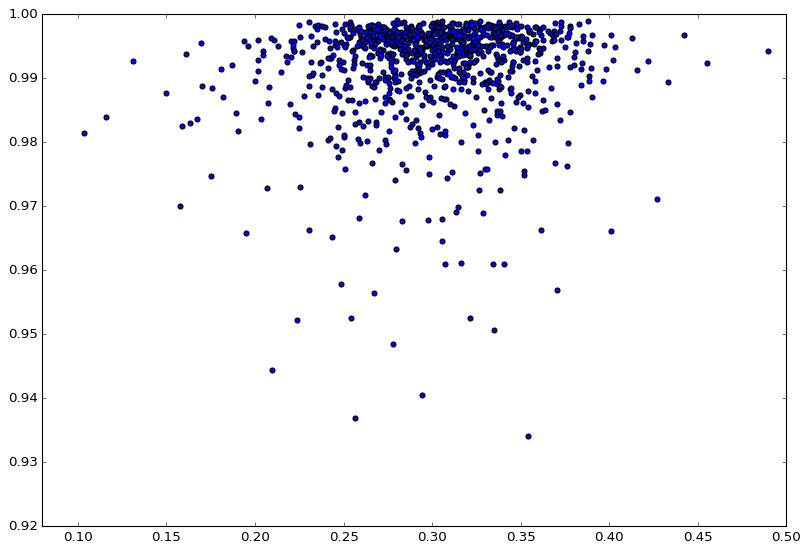

In [ ]:
fig,ax = plt.subplots(figsize = (12,8), facecolor = "white")
plt.scatter(trend_season["season"], trend_season["trend"])
plt.ylim(0.92,1)
plt.xlim(0.08,0.5)
plt.show()

In [ ]:
serie_transformada_temporal = []
for i in range(len(precios_tradicional)):
  Y_t_temporal = (precios_tradicional["BBL"][i]**0.05 - 1) / 0.05
  serie_transformada_temporal.append(Y_t_temporal)
result = STL(serie_transformada_temporal, period = 5).fit()

z = len(result.observed)
x = [*range(0, z, 1)]

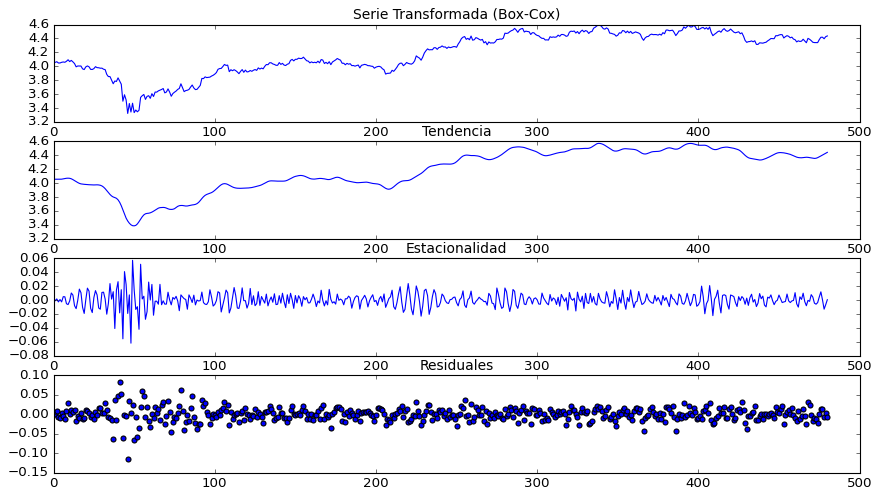

In [ ]:
fig, ax = plt.subplots(4, figsize = (13,7), facecolor = "white")
ax[0].plot(result.observed)
ax[0].set_title("Serie Transformada (Box-Cox)", fontsize = 12.5)
ax[1].plot(result.trend)
ax[1].set_title("Tendencia", fontsize = 12.5)
ax[2].plot(result.seasonal)
ax[2].set_title("Estacionalidad", fontsize = 12.5)
ax[3].scatter(x, result.resid)
ax[3].set_title("Residuales", fontsize = 12.5)
ax[3].set_xlim(0, 500)



#plt.savefig("Descomposición_serie_temporal.png", bbox_inches = "tight")
#files.download("Descomposición_serie_temporal.png")
plt.show()

# **DISTRIBUCIÓN DE VARIABLES Y NORMALIZACIÓN**

In [ ]:
#FUNCIÓN PARA OBSERVAR LOS HISTOGRAMAS DE LAS VARIABLES (PARA MÍ COMODIDAD)
#data: retorno_varianza, skew_kurt ó alfa_beta
#columna: 0 ó 1
#xlabel: Nombre del xlabel (nombre de la variable que se está visualizando)
#download: Si se desea descargar el histograma True. else, False.
#namefile: Nombre del archivo a descargar

def histograma(data, columna, xlabel, download, namefile):
  plt.subplots(facecolor = "white")
  plt.hist(data[data.columns[columna]])
  plt.ylabel("Frecuencia", fontsize = 15)
  plt.xlabel(xlabel, fontsize = 15)
  
  if download == True:
    plt.savefig(namefile + ".png", bbox_inches = "tight")
    files.download(namefile + ".png")
  else:
    pass
  plt.show()

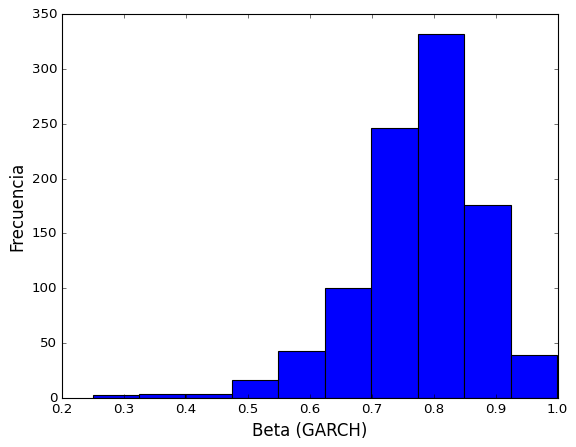

In [ ]:
histograma(alfa_beta, 1, "Beta (GARCH)", False, "Histograma_beta")

In [ ]:
#TEST DE NORMALIDAD DE SHAPIRO WILKS PARA TODAS LAS VARIABLES
#SE RESUME EN UNA TABLA

df_shapiro = pd.DataFrame(columns = ["Estadístico Shapiro-Wilks", "P-Value"])
df_shapiro.loc[0] = list(st.shapiro(retorno_varianza["retorno_medio"]))
df_shapiro.loc[1] =list(st.shapiro(retorno_varianza["varianza"]))

df_shapiro.loc[2] =list(st.shapiro(skew_kurt["skew"]))
df_shapiro.loc[3] =list(st.shapiro(skew_kurt["curtosis"]))

df_shapiro.loc[4] =list(st.shapiro(trend_season["trend"]))
df_shapiro.loc[5] =list(st.shapiro(trend_season["season"]))

df_shapiro.loc[6] =list(st.shapiro(alfa_beta["alfa"]))
df_shapiro.loc[7] =list(st.shapiro(alfa_beta["beta"]))

df_shapiro.index = ["Retorno Medio", "Varianza" ,"Asimetría" ,"Curtosis" ,"Presencia de Tendencia" ,"Presencia de Estacionalidad" ,"Alfa (GARCH)", "Beta (GARCH)"]
df_shapiro.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &  Estadístico Shapiro-Wilks &       P-Value \\\\\n\\midrule\nRetorno Medio               &                   0.814411 &  7.078014e-32 \\\\\nVarianza                    &                   0.595289 &  1.547034e-42 \\\\\nAsimetría                   &                   0.827315 &  5.679696e-31 \\\\\nCurtosis                    &                   0.585517 &  6.894388e-43 \\\\\nPresencia de Tendencia      &                   0.708331 &  7.308187e-38 \\\\\nPresencia de Estacionalidad &                   0.989134 &  1.475727e-06 \\\\\nAlfa (GARCH)                &                   0.957201 &  3.699528e-16 \\\\\nBeta (GARCH)                &                   0.949685 &  1.294224e-17 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
#ESCALAMIENTO DE LAS VARIABLES USANDO MINMAXSCALER (NORMALIZACIÓN)
#ALFA, BETA, TREND Y SEASON NO SE NORMALIZAN PORQUE POR DEFINICIÓN ESTÁN EN UN RANGO DE [0,1]
#Update... De hecho, sí las normalicé, pero el resultado era casi exactamente el mismo jajajaja

scaler_ret_var = MinMaxScaler()
scaler_skew_kurt = MinMaxScaler()

ret_var_normalized = scaler_ret_var.fit_transform(retorno_varianza) 
skew_kurt_normalized = scaler_skew_kurt.fit_transform(skew_kurt)

retorno_scaled = []
varianza_scaled = []

skew_scaled = []
kurt_scaled = []


for i in range(len(ret_var_normalized)):
  retorno_scaled.append(ret_var_normalized[i][0])
  varianza_scaled.append(ret_var_normalized[i][1])
  
  skew_scaled.append(skew_kurt_normalized[i][0])
  kurt_scaled.append(skew_kurt_normalized[i][1])


ret_var_scaled = pd.DataFrame()
skew_kurt_scaled = pd.DataFrame()

ret_var_scaled["retorno_scaled"] = retorno_scaled
ret_var_scaled["varianza_scaled"] = varianza_scaled


skew_kurt_scaled["skew_scaled"] = skew_scaled
skew_kurt_scaled["kurt_scaled"] = kurt_scaled

ret_var_scaled.index = retorno_varianza.index
skew_kurt_scaled.index = skew_kurt.index

# **RAW BASED CLUSTERING**

In [ ]:
#NECESITO LOS PRECIOS DE LOS ACTIVOS PERO EN UNA LISTA DE LISTA PARA UNA MEJOR MANIPULACIÓN
lista_activos = []

for i in activos.columns[1:]:
  lista_activos.append(list(activos[i]))

In [ ]:
#NORMALIZACIÓN DE LAS SERIES TEMPORALES (L2-NORM)

V2 = []
names = []

for i in range(len(lista_activos)):
  names.append(activos.columns[i+1])        #i+1 para no considerar el primero que es el S&P 500

  serie = lista_activos[i]
  media_serie = np.mean(serie)

  #Restar la media a cada punto de la serie original
  v_1 = []
  for j in range(len(serie)):
    v_1.append(serie[j] - media_serie)

  #Calular el L2_norm
  L_2 = [x**2 for x in serie]
  L_2 = (sum(L_2))**(1/2)

  #Dividir todos los puntos de v_1 por L_2
  v_2 = [x/L_2 for x in v_1]

  V2.append(v_2)


In [ ]:
#Ahora, se reducen las series a los puntos más importantes (eliminar el ruido)
#La idea es capturar la forma de la serie de tiempo utilizando menos puntos

index = [i for i in range(len(lista_activos[0]))]                               #Esta es solo una lista que va de 0,1,2,3,4... hasta len(lista_activos[0])  (i.e, la cantidad de dias)
rdp_activos = []

for i in range(len(V2)):
  points = np.column_stack((V2[i], index))
  points_rdp = rdp(points, epsilon = 0.003)
  rdp_activos.append(points_rdp)

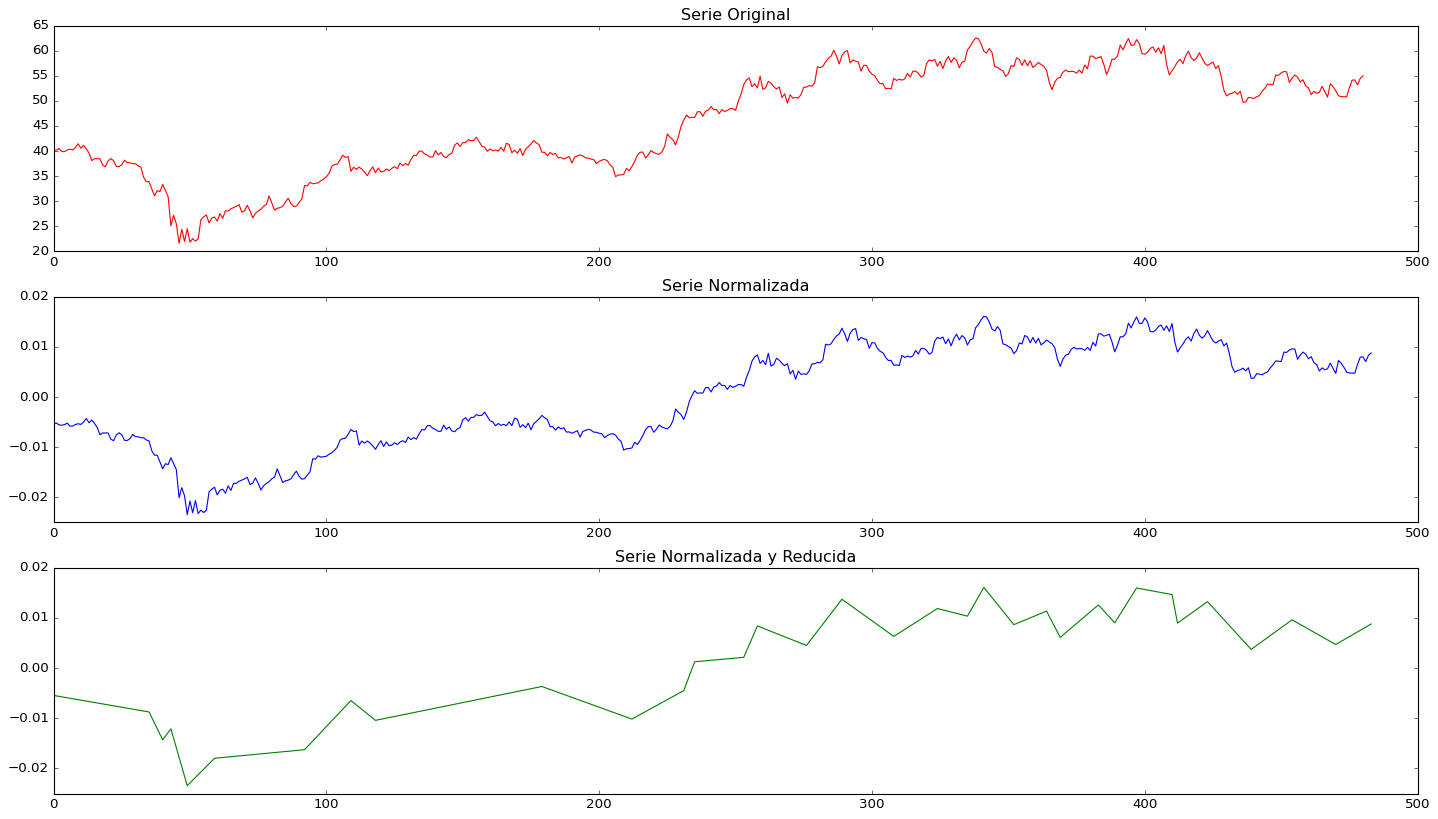

In [ ]:
fig, ax = plt.subplots(3, figsize = (22,12), facecolor = "white")
ax[0].plot(list(precios_tradicional[precios_tradicional.columns[1]]), color = "red", label = "Crudo")
ax[1].plot(V2[1], color = "blue", label = "Escalado")
ax[2].plot(rdp_activos[1][:, 1], rdp_activos[1][:, 0], color = "green", label = "RDP")


ax[0].set_title("Serie Original")
ax[1].set_title("Serie Normalizada")
ax[2].set_title("Serie Normalizada y Reducida")

#plt.savefig("Preprocesamiento_raw_data_based.png", bbox = "tight")
#files.download("Preprocesamiento_raw_data_based.png")
plt.show()

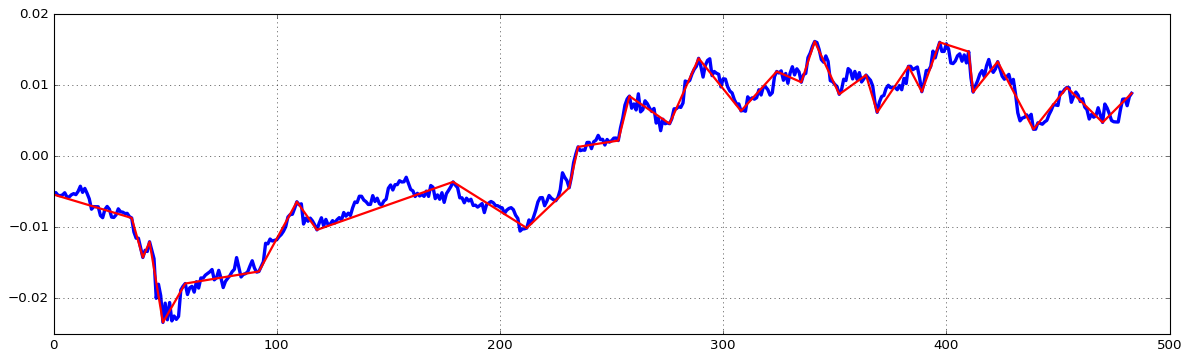

In [ ]:
fig, ax = plt.subplots(figsize = (18,5), facecolor = "white")
plt.plot(V2[1], color = "blue", label = "Escalado", linewidth = 3)
plt.plot(rdp_activos[1][:, 1], rdp_activos[1][:, 0], color = "red", label = "RDP", linewidth = 2)
plt.grid()
#plt.savefig("reduccion_ruido.png", bbox = "tight")
#files.download("reduccion_ruido.png")

plt.show()

In [ ]:
#NECESITO JUNTAR TODAS LAS SERIES DE TIEMPO (YA REDUCIDAS) EN UNA LISTA DE LISTAS
#NECESITO OTRA LISTA PERO CON LOS ÍNDICES DE DONDE SE ENCUENTRAN LOS PUNTOS MÁS IMPORTANTES (EL EJE X)
timeseries = []                                                                 #lista de listas --> series reducidas
xlabel_timeseries = []                                                          #lista de listas --> eje x

for i in range(len(rdp_activos)):
  timeseries.append(rdp_activos[i][:,0])
  xlabel_timeseries.append(rdp_activos[i][:,1])

In [ ]:
#CALCULO DE LA MATRIZ DE DISTANCIAS UTILIZANDO DYNAMIC TIME WARPING
start = time.time()
ds = dtw.distance_matrix_fast(timeseries)
print(time.time() - start)

4.560686349868774


In [ ]:
#CLUSTERING AGLOMERATIVO UTILIZANDO LA MATRIZ DE DISTANCIAS CALCULADAS DE LA CELDA ANTERIOR

cdm = squareform(ds)                                                            #Convierte la matriz de distancia en la matriz condensada
Z = linkage(cdm, method = "complete")                                           #Modelo Aglomerativo "complete"
CCPC_dtw = cophenet(Z, cdm)[0]                                                  #Calcula el coeficiente de correlación cofenetica (entre la matríz cofenetica y la matriz de distancia)
CCPC_dtw

0.8053255711817645

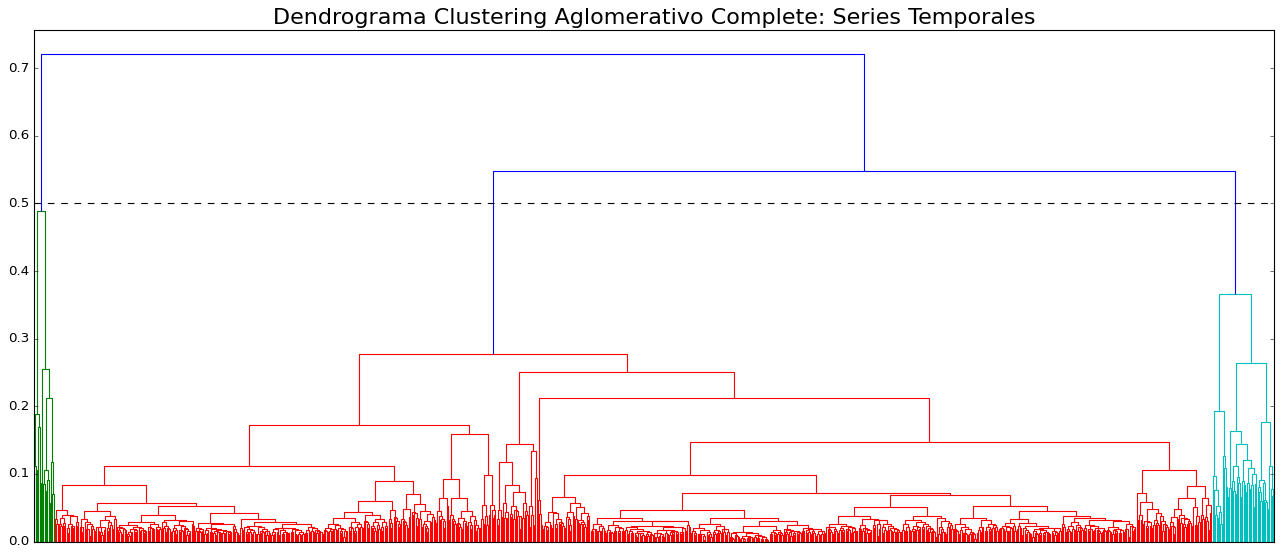

In [ ]:
agg = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage = 'complete', distance_threshold= 0.5)
agg.fit(ds) 
fig, ax = plt.subplots(figsize=(20, 8), facecolor = "white")
plot_dendrogram(agg, color_threshold = 0.5, no_labels = True)
plt.axhline(0.5, color = "black", linewidth = 1, linestyle = "--")
plt.title("Dendrograma Clustering Aglomerativo Complete: Series Temporales", fontsize = 20)
#plt.savefig("Dendrograma_raw_based.png", bbox_inches = "tight")
#files.download("Dendrograma_raw_based.png")
plt.show()

In [ ]:
#esta notación contiene el index de cada serie (siguiendo el orden que se ha seguido hasta ahora)
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
for i in range(len(agg.labels_)):
  if agg.labels_[i] == 0:
    cluster0.append(i)
  if agg.labels_[i] == 1:
    cluster1.append(i)
  if agg.labels_[i] == 2:
    cluster2.append(i)
  if agg.labels_[i] == 3:
    cluster3.append(i)
  if agg.labels_[i] == 4:
    cluster4.append(i)

In [ ]:
#esta notación contiene el nombre de cada serie perteneciente a cada cluster (siguiendo el orden again)
names = list(log_return.columns[1:].copy())
names_cluster0 = [names[i] for i in cluster0]
names_cluster1 = [names[i] for i in cluster1]
names_cluster2 = [names[i] for i in cluster2]
names_cluster3 = [names[i] for i in cluster3]
names_cluster4 = [names[i] for i in cluster4]

In [ ]:
#Esta notación contiene las series normalizadas y reducidas que se utilizarán para clusterizar
cluster00 = []
xlabel_cluster00 = []

cluster11 = []
xlabel_cluster11 = []

cluster22 = []
xlabel_cluster22 = []

cluster33 = []
xlabel_cluster33 = []

cluster44 = []
xlabel_cluster44 = []

for i in cluster0:
  cluster00.append(timeseries[i])
  xlabel_cluster00.append(xlabel_timeseries[i])

for i in cluster1:
  cluster11.append(timeseries[i])
  xlabel_cluster11.append(xlabel_timeseries[i])

for i in cluster2:
  cluster22.append(timeseries[i])
  xlabel_cluster22.append(xlabel_timeseries[i])

for i in cluster3:
  cluster33.append(timeseries[i])
  xlabel_cluster33.append(xlabel_timeseries[i])

for i in cluster4:
  cluster44.append(timeseries[i])
  xlabel_cluster44.append(xlabel_timeseries[i])

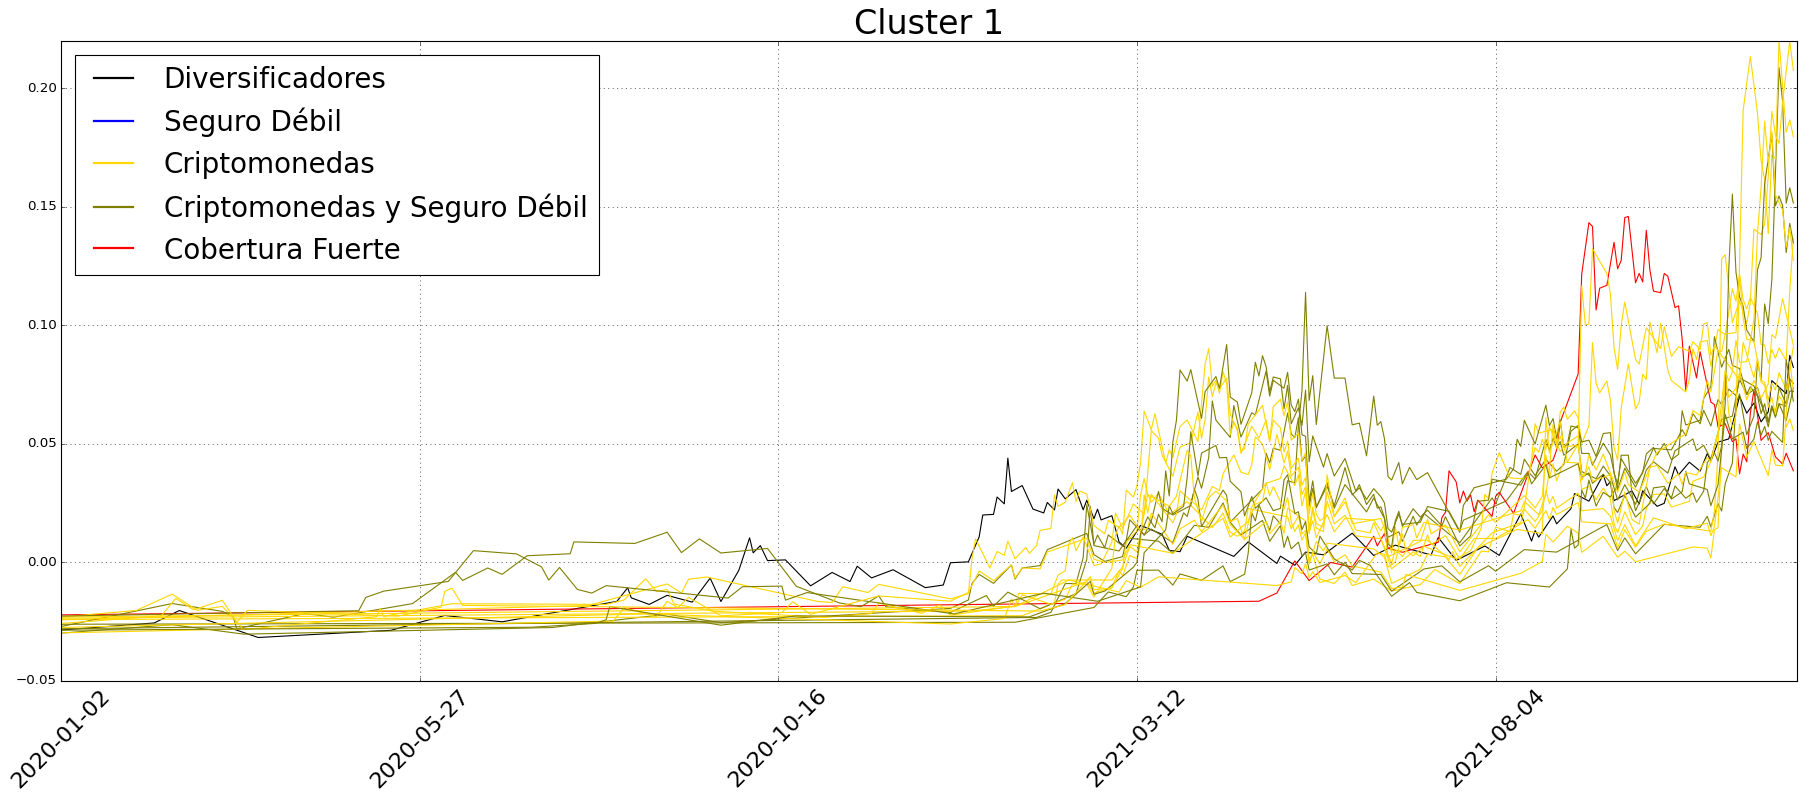

In [ ]:
fig, ax = plt.subplots(figsize = (28,10), facecolor = "white")
for i in range(len(cluster00)):
  #Diversificadores
  if names_cluster0[i] not in criptomonedas and names_cluster0[i] not in seguro_debil and names_cluster0[i] not in cobertura_fuerte:
    plt.plot(xlabel_cluster00[i], cluster00[i], color = "black")
  #Seguro Débil
  if names_cluster0[i] in seguro_debil and names_cluster0[i] not in criptomonedas and names_cluster0[i] not in cobertura_fuerte:
    plt.plot(xlabel_cluster00[i], cluster00[i], color = "blue")
  #Criptomonedas
  if names_cluster0[i] in criptomonedas and names_cluster0[i] not in seguro_debil not in cobertura_fuerte:
    plt.plot(xlabel_cluster00[i], cluster00[i], color = "gold")
  #Criptomonedas y Seguro Débil
  if names_cluster0[i] in criptomonedas and names_cluster0[i] in seguro_debil and names_cluster0[i] not in cobertura_fuerte:
    plt.plot(xlabel_cluster00[i], cluster00[i], color = "olive")
  #Cobertura Fuerte
  if names_cluster0[i] in cobertura_fuerte:
    plt.plot(xlabel_cluster00[i], cluster00[i], color = "red")



lineas =        [Line2D([0], [0], color="black", lw=2),
                Line2D([0], [0], color = "blue", lw=2),
                Line2D([0], [0], color = "gold", lw=2),
                Line2D([0], [0], color = "olive", lw=2),
                Line2D([0], [0], color = "red", lw=2)]

ax.set_xticklabels(log_return.index[::100], rotation=45, fontsize = 20)                        #Para calzar las fechas con el gráfico lo fui comparando con el gráfico original de Yahoo Finance
                                                                                #No calza Exaaaactamente, pero es una aproximación muy cercana a las fechas donde ocurre cada cosa
                                                                                #Al fin y al cabo es para dar una idea de en qué período ocurrió qué
plt.ylim(-0.05,0.22)
plt.xlim(0, 484)
plt.title("Cluster 1", fontsize = 30)
plt.legend(lineas, ['Diversificadores', 'Seguro Débil', 'Criptomonedas', "Criptomonedas y Seguro Débil", "Cobertura Fuerte"],fontsize = 25, loc = "upper left") 
plt.grid()

#plt.savefig("Cluster1_raw_based.png", bbox_inches = "tight")
#files.download("Cluster1_raw_based.png")
plt.show()

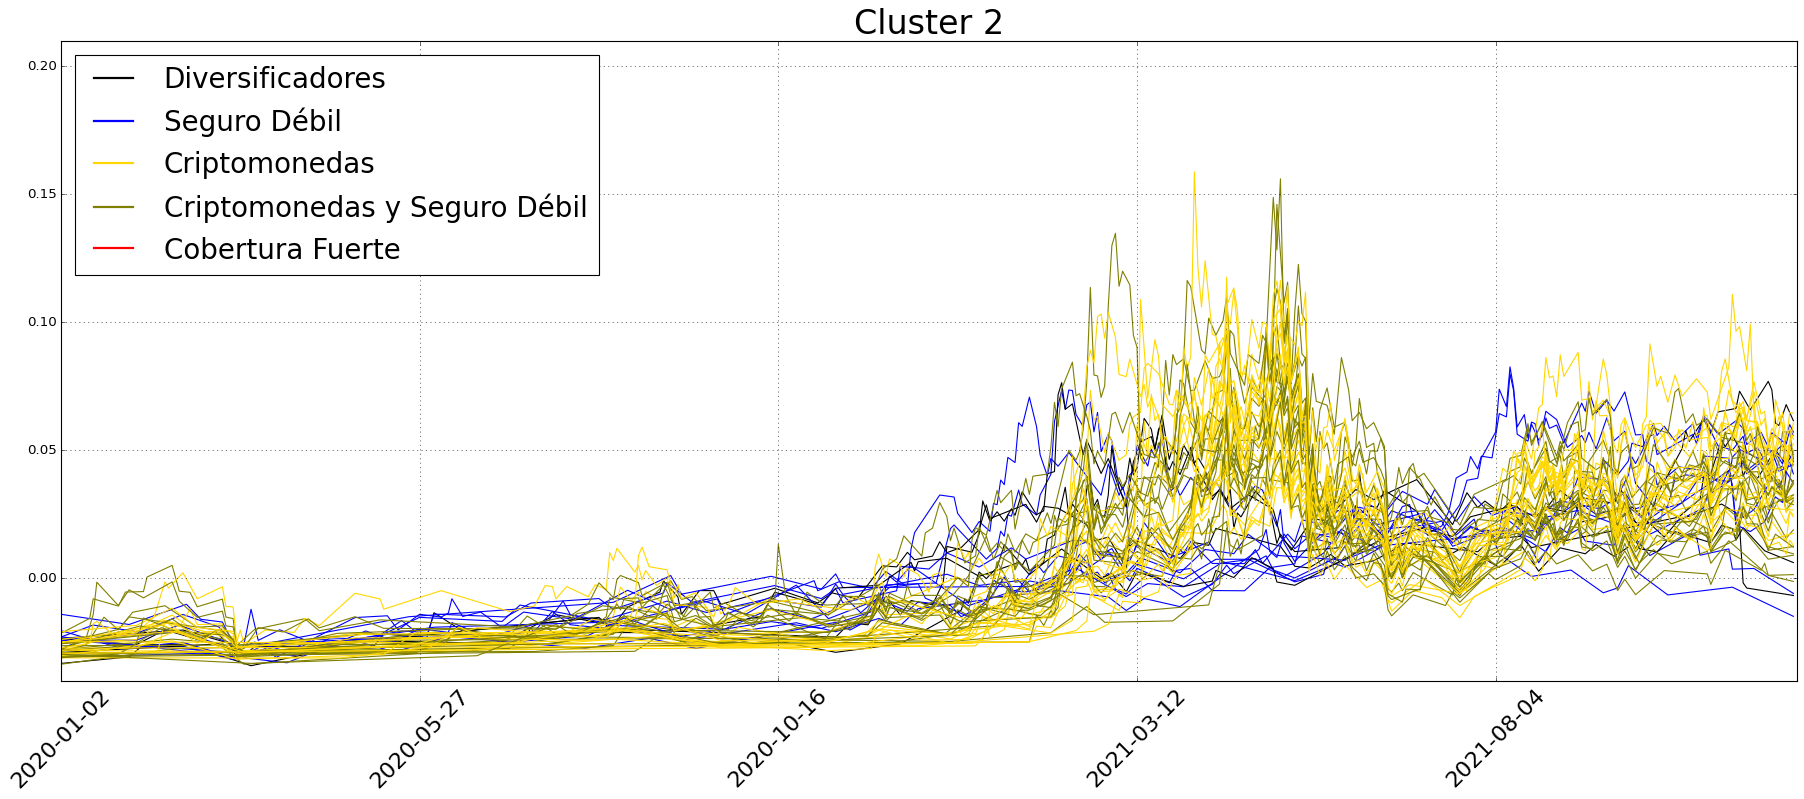

In [ ]:
fig, ax = plt.subplots(figsize = (28,10), facecolor = "white")
for i in range(len(cluster11)):
  #Diversificadores
  if names_cluster1[i] not in criptomonedas and names_cluster1[i] not in seguro_debil and names_cluster1[i] not in cobertura_fuerte:
    plt.plot(xlabel_cluster11[i], cluster11[i], color = "black")
  #Seguro Débil
  if names_cluster1[i] in seguro_debil and names_cluster1[i] not in criptomonedas and names_cluster1[i] not in cobertura_fuerte:
    plt.plot(xlabel_cluster11[i], cluster11[i], color = "blue")
  #Criptomonedas
  if names_cluster1[i] in criptomonedas and names_cluster1[i] not in seguro_debil not in cobertura_fuerte:
    plt.plot(xlabel_cluster11[i], cluster11[i], color = "gold")
  #Criptomonedas y Seguro Débil
  if names_cluster1[i] in criptomonedas and names_cluster1[i] in seguro_debil and names_cluster1[i] not in cobertura_fuerte:
    plt.plot(xlabel_cluster11[i], cluster11[i], color = "olive")
  #Cobertura Fuerte
  if names_cluster1[i] in cobertura_fuerte:
    plt.plot(xlabel_cluster11[i], cluster11[i], color = "red")



lineas =        [Line2D([0], [0], color="black", lw=2),
                Line2D([0], [0], color = "blue", lw=2),
                Line2D([0], [0], color = "gold", lw=2),
                Line2D([0], [0], color = "olive", lw=2),
                Line2D([0], [0], color = "red", lw=2)]


plt.legend(lineas, ['Diversificadores', 'Seguro Débil', 'Criptomonedas', "Criptomonedas y Seguro Débil", "Cobertura Fuerte"], fontsize = 25, loc = "upper left")

ax.set_xticklabels(log_return.index[::100], rotation=45, fontsize = 20)
plt.xlim(0,484)
plt.ylim(-0.04,0.21)
plt.title("Cluster 2", fontsize = 30)
plt.grid()
#plt.savefig("Cluster2_raw_based.png", bbox_inches = "tight")
#files.download("Cluster2_raw_based.png")

plt.show()

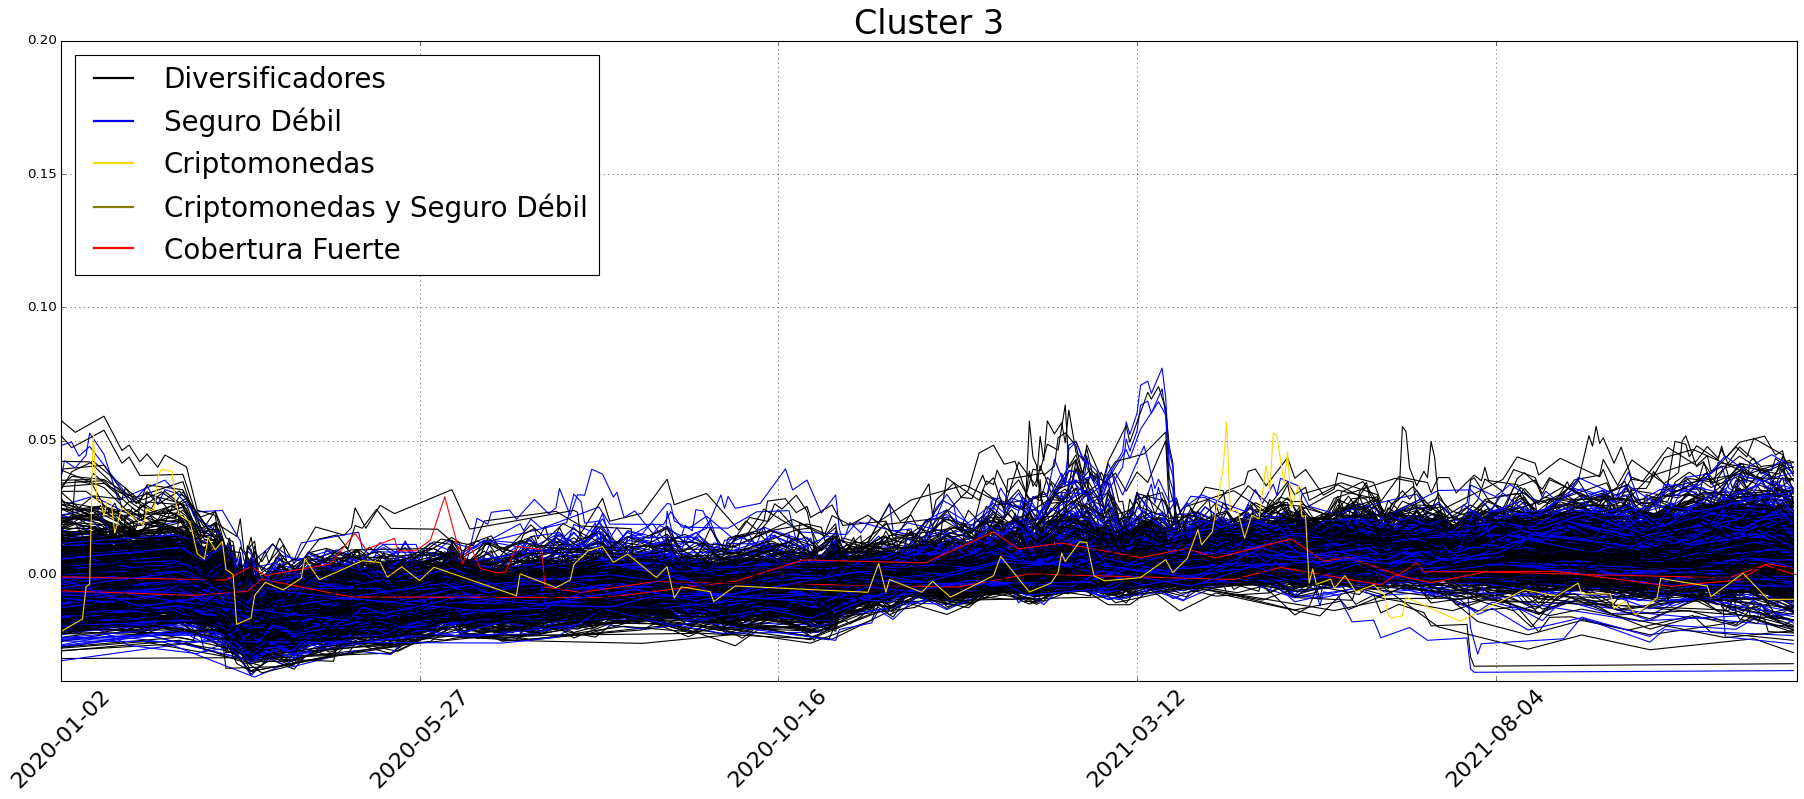

In [ ]:
fig, ax = plt.subplots(figsize = (28,10), facecolor = "white")
for i in range(len(cluster22)):
  #Diversificadores
  if names_cluster2[i] not in criptomonedas and names_cluster2[i] not in seguro_debil and names_cluster2[i] not in cobertura_fuerte:
    plt.plot(xlabel_cluster22[i], cluster22[i], color = "black")
  #Seguro Débil
  if names_cluster2[i] in seguro_debil and names_cluster2[i] not in criptomonedas and names_cluster2[i] not in cobertura_fuerte:
    plt.plot(xlabel_cluster22[i], cluster22[i], color = "blue")
  #Criptomonedas
  if names_cluster2[i] in criptomonedas and names_cluster2[i] not in seguro_debil not in cobertura_fuerte:
    plt.plot(xlabel_cluster22[i], cluster22[i], color = "gold")
  #Criptomonedas y Seguro Débil
  if names_cluster2[i] in criptomonedas and names_cluster2[i] in seguro_debil and names_cluster2[i] not in cobertura_fuerte:
    plt.plot(xlabel_cluster22[i], cluster22[i], color = "olive")
  if names_cluster2[i] in cobertura_fuerte:
    plt.plot(xlabel_cluster22[i], cluster22[i], color = "red")



lineas =        [Line2D([0], [0], color="black", lw=2),
                Line2D([0], [0], color = "blue", lw=2),
                Line2D([0], [0], color = "gold", lw=2),
                Line2D([0], [0], color = "olive", lw=2),
                Line2D([0], [0], color = "red", lw=2)]


plt.legend(lineas, ['Diversificadores', 'Seguro Débil', 'Criptomonedas', "Criptomonedas y Seguro Débil", "Cobertura Fuerte"], fontsize = 25, loc = "upper left")

ax.set_xticklabels(log_return.index[::100], rotation=45, fontsize = 20)
plt.ylim(-0.04, 0.20)
plt.xlim(0, 484)
plt.title("Cluster 3", fontsize = 30)
plt.grid()
#plt.savefig("Cluster3_raw_based.png", bbox_inches = "tight")
#files.download("Cluster3_raw_based.png")
plt.show()

# **MonteCarlo CCPC Dynamic Time Warping**

In [ ]:
def MonteCarlo_DTW(r, download):
  CCPC = []
  for i in range(r):
    
    series_sinteticas = []
    #Crear un dataset sintético 90x963:                                           #Al hacer DTW, se redujo las series a los puntos más importantes, Como aquí estoy creando las series sintéticas, basta con crearlas del largo de las series reducidas
    for j in range(963):                                                          
      serie_random = np.array([np.random.uniform(0, 1) for k in range(90)])
      series_sinteticas.append(serie_random)

    
    #Calcula la matriz de distancias usando dynamic time warping
    ds = dtw.distance_matrix_fast(series_sinteticas)

    #Calcula CCPC
    cdm = squareform(ds)     #Convierte la matriz de distancia en la matriz condensada
    Z = linkage(cdm, method = "complete")
    CCPC_i = cophenet(Z, cdm)[0]            #Calcula el coeficiente de correlación cofenetica (entre la matríz cofenetica y la matriz de distancia)
    CCPC.append(CCPC_i)

  if download == True:
    df = pd.DataFrame()
    df["CCPC"] = CCPC
    df.to_csv("Montecarlo_DTW.csv")
    files.download("Montecarlo_DTW.csv")

  return CCPC

In [ ]:
x = MonteCarlo_DTW(100, True)
df = pd.DataFrame()
df["CCPC"] = x

In [ ]:
plt.subplots(facecolor = "white")
plt.hist(df["CCPC"])
plt.ylabel("Frecuencia", fontsize = 15)
plt.xlabel("CCPC", fontsize = 15)
plt.title("Simulación Monte Carlo: Series Temporales")

#plt.savefig("MonteCarlo_Rawbased.png", bbox_inches = "tight")
#files.download("MonteCarlo_Rawbased.png")

plt.show()

# **1.1 K-MEANS RETORNO MEDIO - VARIANZA**

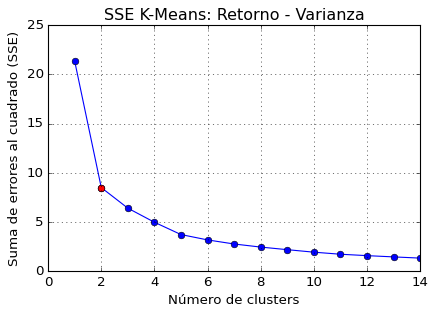

In [ ]:
#Método Elbow para determinar el número óptimo de Clusters
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo_kmeans.fit(ret_var_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84), facecolor = "white")
ax.plot(range_n_clusters, inertias, marker='o')
ax.plot(2,inertias[1], color = "red", marker = "o")
ax.set_title("SSE K-Means: Retorno - Varianza")
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Suma de errores al cuadrado (SSE)');
plt.grid()
#plt.savefig("Elbow_Kmeans_Ret_Var.png", bbox_inches = "tight")
#files.download("Elbow_Kmeans_Ret_Var.png")
plt.show()

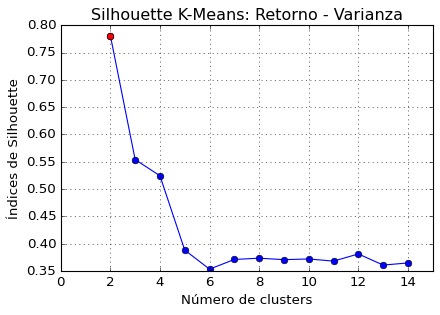

In [ ]:
#Método de Silhouette para determinar el número óptimo de Clusters
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(ret_var_scaled)
    silhouette_avg = silhouette_score(ret_var_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84), facecolor = "white")
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.plot(2,valores_medios_silhouette[0], color = "red", marker = "o")
ax.set_title("Silhouette K-Means: Retorno - Varianza")
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Índices de Silhouette');
plt.xlim(0,15)
plt.grid()
#plt.savefig("Silhouette_Kmeans_Ret_Var.png", bbox_inches = "tight")
#files.download("Silhouette_Kmeans_Ret_Var.png")

plt.show()

In [ ]:
#El método de Elbow muestra que entre 2 y 3 clusters se puede observar el "codo" indicando que ese podría ser el número óptimo de clusters
#En cambio, el método de Silhouette, claramente indica que son 2 los grupos existentes ya que es el valor que maximiza la media de indices silhouette
#NOTA: LO RECIÉN DICHO APLICA UTILIZANDO LOS RETORNOS MEDIOS Y LA VARIANZA DE CADA SERIE COMO LAS VARIABLES PARA EL CLUSTER.
modelo_kmeans2 = KMeans(n_clusters=2, n_init=25, random_state=123)
modelo_kmeans2 = modelo_kmeans2.fit(X = ret_var_scaled)

clusters_kmeans2 = pd.DataFrame()
clusters_kmeans2["clusters"] = modelo_kmeans2.labels_
clusters_kmeans2.index = log_return.columns[1:]
#clusters_kmeans2

cluster0_kmeans2 = []
cluster1_kmeans2 = []


for i in range(len(modelo_kmeans2.labels_)):
  if modelo_kmeans2.labels_[i] == 0:
    cluster0_kmeans2.append(clusters_kmeans2.index[i])

  if modelo_kmeans2.labels_[i] == 1:
    cluster1_kmeans2.append(clusters_kmeans2.index[i])


print(len(cluster0_kmeans2))
print(len(cluster1_kmeans2))

898
65


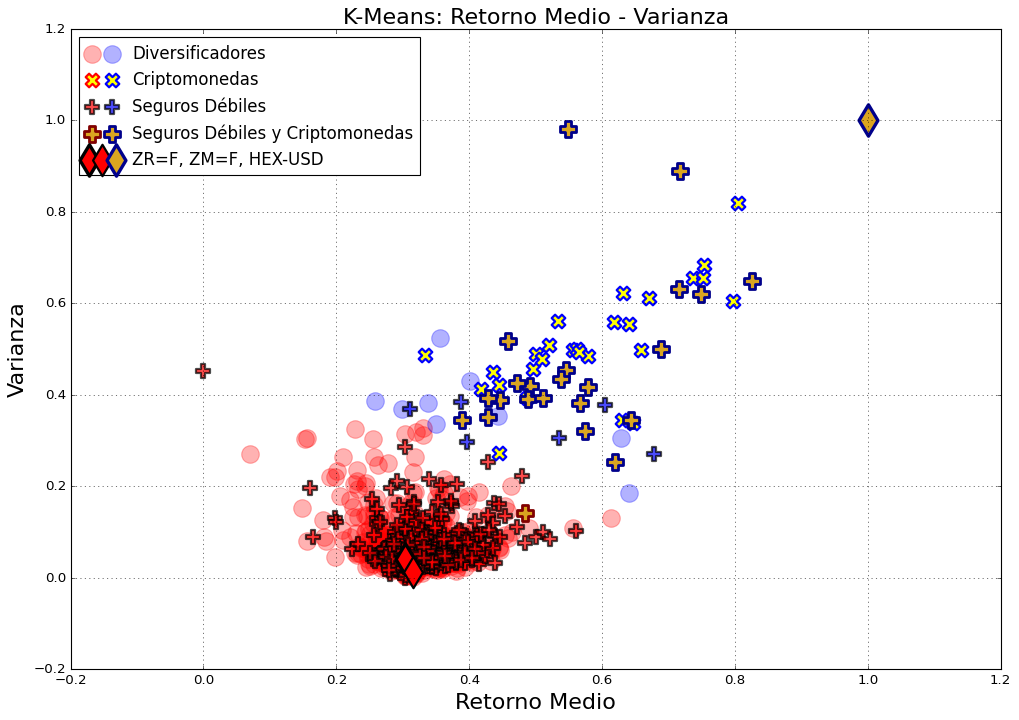

In [ ]:
clusters = [cluster0_kmeans2, cluster1_kmeans2]
colors = ["red", "blue"]
graficos_clusters(ret_var_scaled, "Retorno Medio" , "Varianza", clusters, colors, "K-Means: Retorno Medio - Varianza", "Clusters_Kmeans_ret_var", False)

In [ ]:
lista = [cluster0_kmeans2, cluster1_kmeans2]
Hubert_Normalized(ret_var_scaled, "euclideana", lista)

0.815094678624252

DEJARÉ UNA SECCIÓN CON TODAS LAS SIMULACIONES DE MONTECARLO PARA CADA UNO DE LOS MODELOS Y VARIABLES

# **1.2 DBSCAN RETORNO MEDIO - VARIANZA**

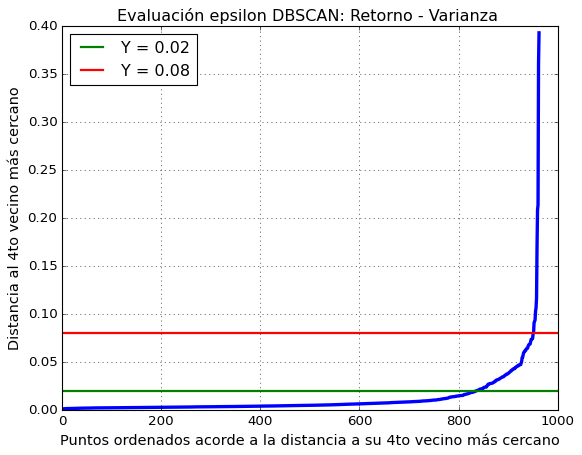

In [ ]:
#Esta sección la saqué de https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(ret_var_scaled)
distances, indices = neighbors_fit.kneighbors(ret_var_scaled)
for i in range(len(distances)):
  distances[i] = np.sort(distances[i])                                          #Cada fila es la distancia del punto a sus 4 vecinos más cercanos, se ordena para tomar el 4to más cercano
distances = distances[:,3]                                                      #Tomo la distancia al 4to vecino más cercano
distances = np.sort(distances)                                                  #Ordeno todos los puntos de menor a mayor distancia al 4to vecino más cercano


#Ploteando las distancias
fig, ax = plt.subplots(facecolor = "white")
plt.plot(distances, linewidth  = 3)
plt.xlabel("Puntos ordenados acorde a la distancia a su 4to vecino más cercano", fontsize = 13)
plt.ylabel("Distancia al 4to vecino más cercano", fontsize = 13)
plt.axhline(y = 0.02, label = "Y = 0.02", color = "green", linewidth = 2)
plt.axhline(y = 0.08, label = "Y = 0.08", color = "red", linewidth = 2)
plt.title("Evaluación epsilon DBSCAN: Retorno - Varianza " )
plt.grid()
plt.legend(loc = "upper left")

#plt.savefig("epsilon_dbscan_retorno_varianza.png", bbox_inches = "tight")
#files.download("epsilon_dbscan_retorno_varianza.png")
plt.show()

In [ ]:
modelo_dbscan = DBSCAN(
                    eps          = 0.05,
                    min_samples  = 4,
                    metric       = 'euclidean',
                )

modelo_dbscan.fit(X=ret_var_scaled)

DBSCAN(eps=0.05, min_samples=4)

In [ ]:
np.unique(modelo_dbscan.labels_)

array([-1,  0,  1])

In [ ]:
clusters_dbscan = pd.DataFrame()
clusters_dbscan["clusters"] = list(modelo_dbscan.labels_)
clusters_dbscan.index = retorno_varianza.index

outliers = []
cluster0_dbscan = []
cluster1_dbscan = []



for i in range(len(modelo_dbscan.labels_)):

  if modelo_dbscan.labels_[i] == -1:
    outliers.append(clusters_dbscan.index[i])
  
  if modelo_dbscan.labels_[i] == 0:
    cluster0_dbscan.append(clusters_dbscan.index[i])  
  
  if modelo_dbscan.labels_[i] == 1:
    cluster1_dbscan.append(clusters_dbscan.index[i])
  

print(len(outliers))
print(len(cluster0_dbscan))
print(len(cluster1_dbscan))

26
931
6


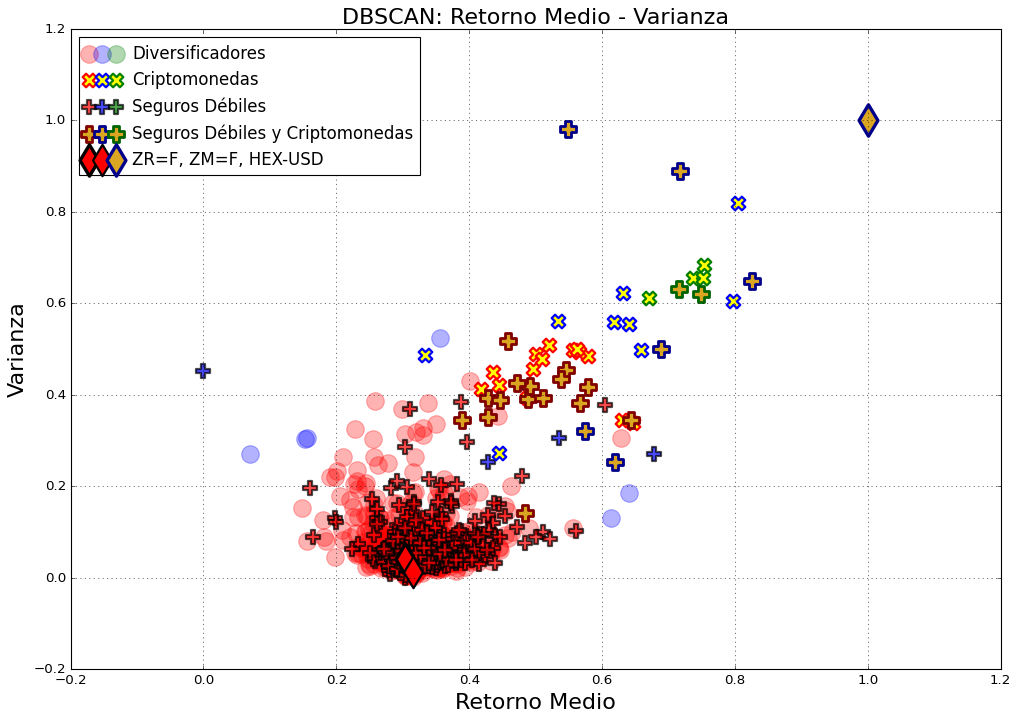

In [ ]:
clusters = [outliers, cluster0_dbscan, cluster1_dbscan]
colors = ["blue", "red", "green"]
graficos_clusters(ret_var_scaled, "Retorno Medio", "Varianza", clusters, colors, "DBSCAN: Retorno Medio - Varianza","Clusters_DBSCAN_ret_var", False)

In [ ]:
clusters = [outliers, cluster0_dbscan, cluster1_dbscan]

In [ ]:
Hubert_Normalized_DBSCAN(ret_var_scaled, "euclideana", clusters)

# **1.3 AGLOMERATIVO COMPLETE: RETORNO MEDIO - VARIANZA**


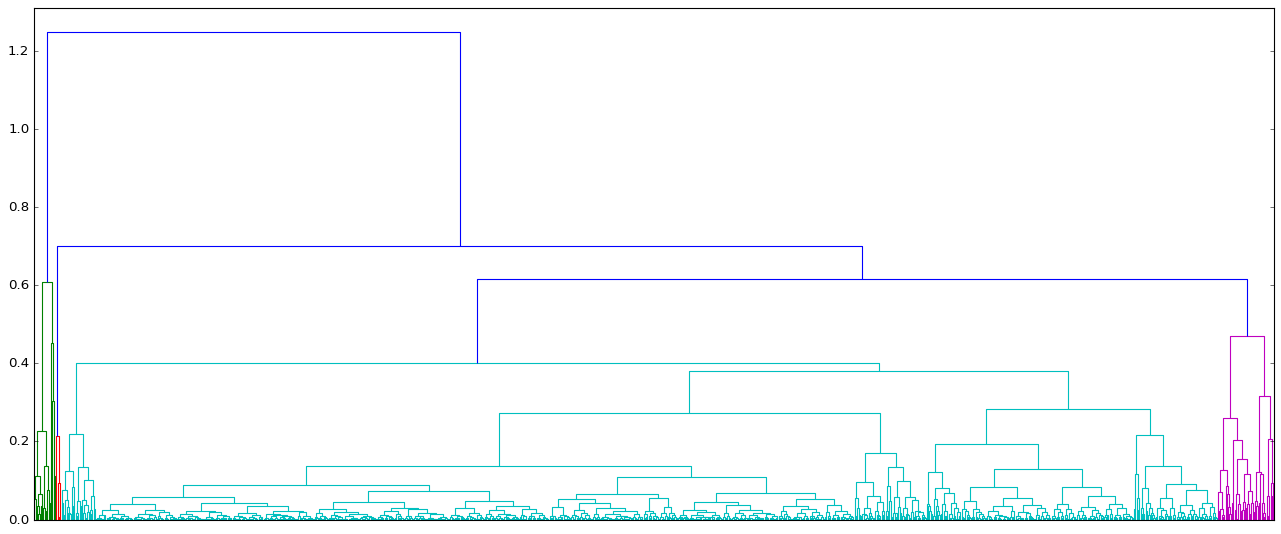

In [ ]:
#Necesito una primera visualización del dendrograma para ver las distancias y luego averiguar donde cortar

agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= 0.61)
agg.fit(ret_var_scaled) 
fig, axs = plt.subplots(figsize=(20, 8), facecolor = "white")
plot_dendrogram(agg, no_labels = True, color_threshold = 0.61)

plt.show()

In [ ]:
#Este código se repite en algunas ocasiones pero no lo quise hacer como función por comodidad
#Ya que se demora en ejecutarse y las listas que obtengo de aquí las necesito para posteriormente graficar

#Esta sección de código es para ejecutar el clustering agglomerativo y cortarlo en distintos puntos.
#La idea es calcular el SSE y el SIlhouette total en base a las distintas cantidades de clusteres que hayan sido generados

SSE_x_clusters = []
Silhouette_x_clusters = []

n_clusters = []
distancia_corte = []

#Necesito un Punto de Partida, Subjetivamente pondré como límite un máximo de 20 clusters para no 


agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= 0.01)       #Punto de partida
agg.fit(ret_var_scaled)
etiquetas = agg.labels_

SSE_x_clusters.append(SSE_euclideana(ret_var_scaled, etiquetas))
Silhouette_x_clusters.append(silhouette_score(ret_var_scaled, etiquetas))


n_clusters_actual = (len(np.unique(etiquetas)))
n_clusters.append(n_clusters_actual) 
distancia_corte.append(0.01)


corte = [*np.arange(0.02, 1.2, 0.01)]       #De aquí es que necesitaba ver el dendrograma
for i in range(len(corte)):
  
  agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= corte[i])       #Punto de partida
  agg.fit(ret_var_scaled)
  etiquetas = list(agg.labels_)
  numero_clusters = len(np.unique(etiquetas))

  if numero_clusters != n_clusters_actual and numero_clusters > 1:
    SSE_x_clusters.append(SSE_euclideana(ret_var_scaled, etiquetas))
    Silhouette_x_clusters.append(silhouette_score(ret_var_scaled, etiquetas))
    
    n_clusters.append(numero_clusters)
    n_clusters_actual = numero_clusters
    distancia_corte.append(corte[i])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

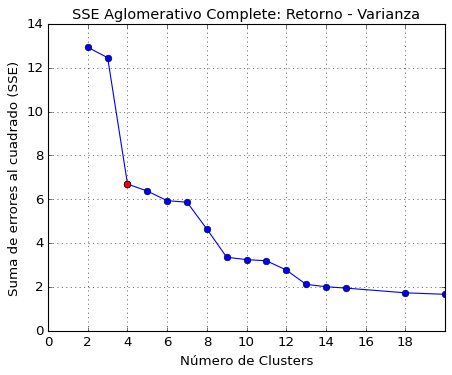

In [ ]:
fig, ax = plt.subplots(figsize = (6.4, 4.8), facecolor = "white")
plt.plot(n_clusters, SSE_x_clusters, marker = "o")
plt.plot(4, SSE_x_clusters[-3], marker = "o", color = "red")
plt.xlabel("Número de Clusters", fontsize = 12)
plt.ylabel("Suma de errores al cuadrado (SSE)", fontsize = 12)
plt.title("SSE Aglomerativo Complete: Retorno - Varianza", fontsize = 13)
plt.grid()

eje_x = [*range(0,20,2)]
ax.set_xticks(eje_x)
plt.xlim(0,20)
#plt.savefig("Elbow_aglomerativo_complete_Ret_Var.png", bbox_inches = "tight")
#files.download("Elbow_aglomerativo_complete_Ret_Var.png")
plt.show()

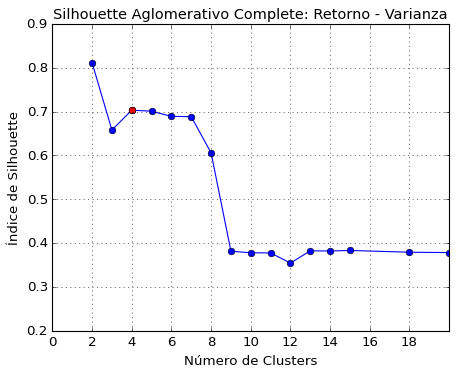

In [ ]:
fig, ax = plt.subplots(figsize = (6.4, 4.8), facecolor = "white")
plt.plot(n_clusters, Silhouette_x_clusters, marker = "o")
plt.plot(4, Silhouette_x_clusters[-3], marker = "o", color = "red")
plt.xlabel("Número de Clusters", fontsize = 12)
plt.ylabel("Índice de Silhouette", fontsize = 12)
plt.title("Silhouette Aglomerativo Complete: Retorno - Varianza", fontsize = 13)
plt.grid()

eje_x = [*range(0,20,2)]
ax.set_xticks(eje_x)
plt.xlim(0,20)
#plt.savefig("Silhouette_aglomerativo_complete_Ret_Var.png", bbox_inches = "tight")
#files.download("Silhouette_aglomerativo_complete_Ret_Var.png")

plt.show()

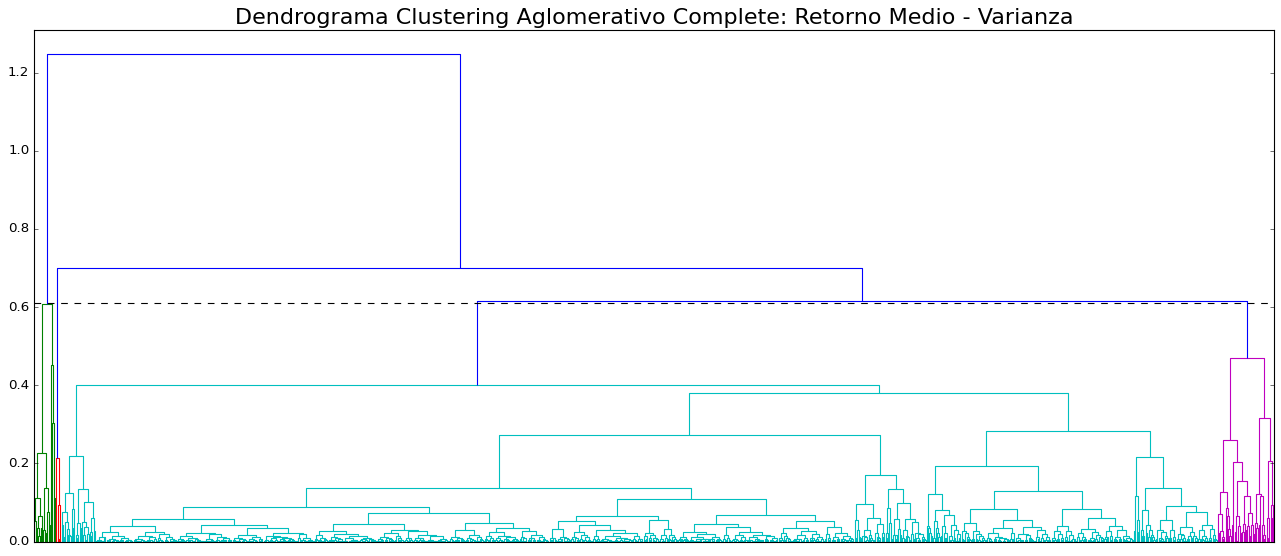

In [ ]:
agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= 0.61)
agg.fit(ret_var_scaled) 



fig, axs = plt.subplots(figsize=(20, 8), facecolor = "white")
plot_dendrogram(agg, no_labels = True, color_threshold = 0.61)
plt.axhline(0.61, color = "black", linewidth = 1, linestyle = "--")
plt.title("Dendrograma Clustering Aglomerativo Complete: Retorno Medio - Varianza", fontsize = 20)
#plt.savefig("Dendrograma_ret_var.png", bbox_inches = "tight")
#files.download("Dendrograma_ret_var.png")

plt.show()

In [ ]:
clusters_aglomerativo_ret_var = pd.DataFrame()
clusters_aglomerativo_ret_var["clusters"] = agg.labels_
clusters_aglomerativo_ret_var.index = log_return.columns[1:]

cluster0_aglomerativo_ret_var = []
cluster1_aglomerativo_ret_var = []
cluster2_aglomerativo_ret_var = []
cluster3_aglomerativo_ret_var = []

for i in range(len(clusters_aglomerativo_ret_var.index)):
  if agg.labels_[i] == 0:
    cluster0_aglomerativo_ret_var.append(clusters_aglomerativo_ret_var.index[i])

  if agg.labels_[i] == 1:
    cluster1_aglomerativo_ret_var.append(clusters_aglomerativo_ret_var.index[i])

  if agg.labels_[i] == 2:
    cluster2_aglomerativo_ret_var.append(clusters_aglomerativo_ret_var.index[i])

  if agg.labels_[i] == 3:
    cluster3_aglomerativo_ret_var.append(clusters_aglomerativo_ret_var.index[i])


print(len(cluster0_aglomerativo_ret_var))
print(len(cluster1_aglomerativo_ret_var))
print(len(cluster2_aglomerativo_ret_var))
print(len(cluster3_aglomerativo_ret_var))

17
44
4
898


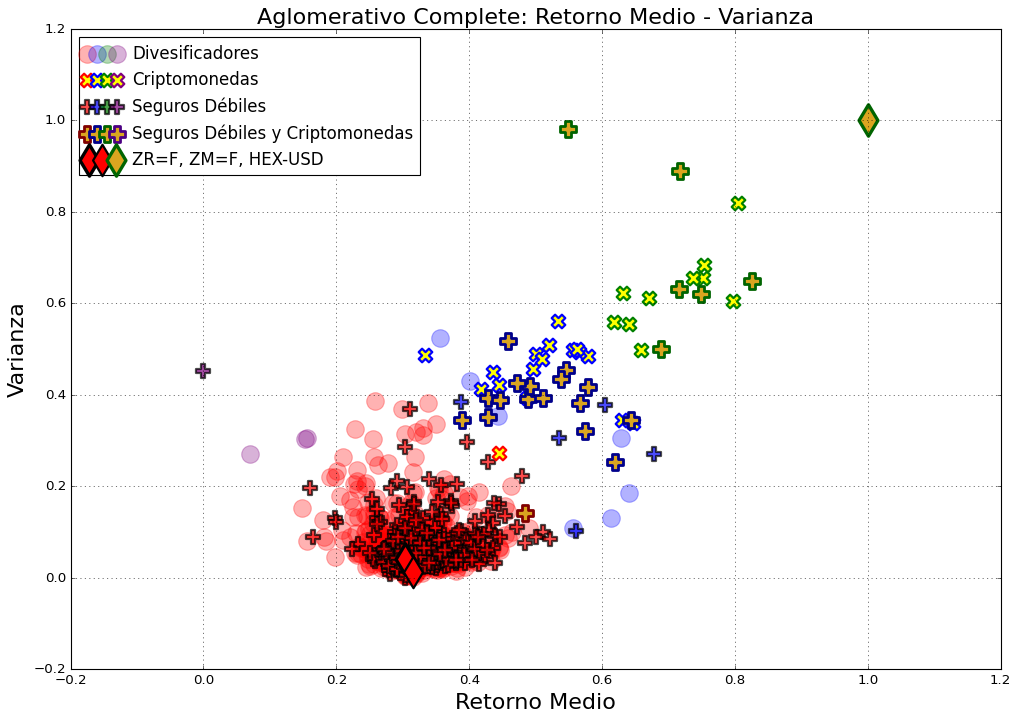

In [ ]:
clusters = [cluster0_aglomerativo_ret_var, cluster1_aglomerativo_ret_var, cluster2_aglomerativo_ret_var, cluster3_aglomerativo_ret_var]
colors = ["green", "blue", "purple", "red"]
graficos_clusters(ret_var_scaled, "Retorno Medio", "Varianza", clusters, colors, "Aglomerativo Complete: Retorno Medio - Varianza" ,"Clusters_aglomerativo_complete_ret_var", False)

In [ ]:
CCPC(ret_var_scaled, "complete", "euclideana")

# **2.1 K-MEANS ASIMETRÍA - CURTOSIS**

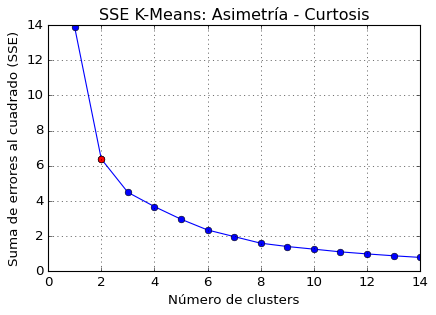

In [ ]:
#Método Elbow para determinar el número óptimo de Clusters
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo_kmeans.fit(skew_kurt_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84), facecolor = "white")
ax.plot(range_n_clusters, inertias, marker='o')
ax.plot(2,inertias[1], color = "red", marker = "o")
ax.set_title("SSE K-Means: Asimetría - Curtosis")
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Suma de errores al cuadrado (SSE)');
plt.grid()
#plt.savefig("Elbow_Kmeans_Skew_Kurt.png", bbox_inches = "tight")
#files.download("Elbow_Kmeans_Skew_Kurt.png")
plt.show()

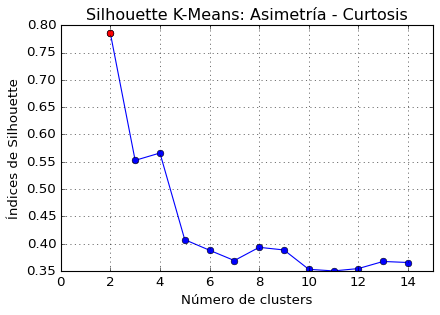

In [ ]:
#Método de Silhouette para determinar el número óptimo de Clusters
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(skew_kurt_scaled)
    silhouette_avg = silhouette_score(skew_kurt_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84), facecolor = "white")
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.plot(2,valores_medios_silhouette[0], color = "red", marker = "o")
ax.set_title("Silhouette K-Means: Asimetría - Curtosis")
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Índices de Silhouette');
plt.grid()
plt.xlim(0,15)

#plt.savefig("Sillhouette_skew_kurt.png", bbox_inches = "tight")
#files.download("Sillhouette_skew_kurt.png")
plt.show()

In [ ]:
#El método de Elbow muestra que entre 2 y 3 clusters se puede observar el "codo" indicando que ese podría ser el número óptimo de clusters
#En cambio, el método de Silhouette, claramente indica que son 2 los grupos existentes ya que es el valor que maximiza la media de indices silhouette
#NOTA: LO RECIÉN DICHO APLICA UTILIZANDO LOS RETORNOS MEDIOS Y LA VARIANZA DE CADA SERIE COMO LAS VARIABLES PARA EL CLUSTER.
modelo_kmeans3 = KMeans(n_clusters=2, n_init=25, random_state=123)
modelo_kmeans3 = modelo_kmeans3.fit(X = skew_kurt_scaled)

clusters_kmeans3 = pd.DataFrame()
clusters_kmeans3["clusters"] = modelo_kmeans3.labels_
clusters_kmeans3.index = log_return.columns[1:]
#clusters_kmeans3

cluster0_kmeans3 = []
cluster1_kmeans3 = []


for i in range(len(modelo_kmeans3.labels_)):
  if modelo_kmeans3.labels_[i] == 0:
    cluster0_kmeans3.append(clusters_kmeans3.index[i])

  if modelo_kmeans3.labels_[i] == 1:
    cluster1_kmeans3.append(clusters_kmeans3.index[i])

print(len(cluster0_kmeans3))
print(len(cluster1_kmeans3))

912
51


In [ ]:
clusters = [cluster0_kmeans3, cluster1_kmeans3]

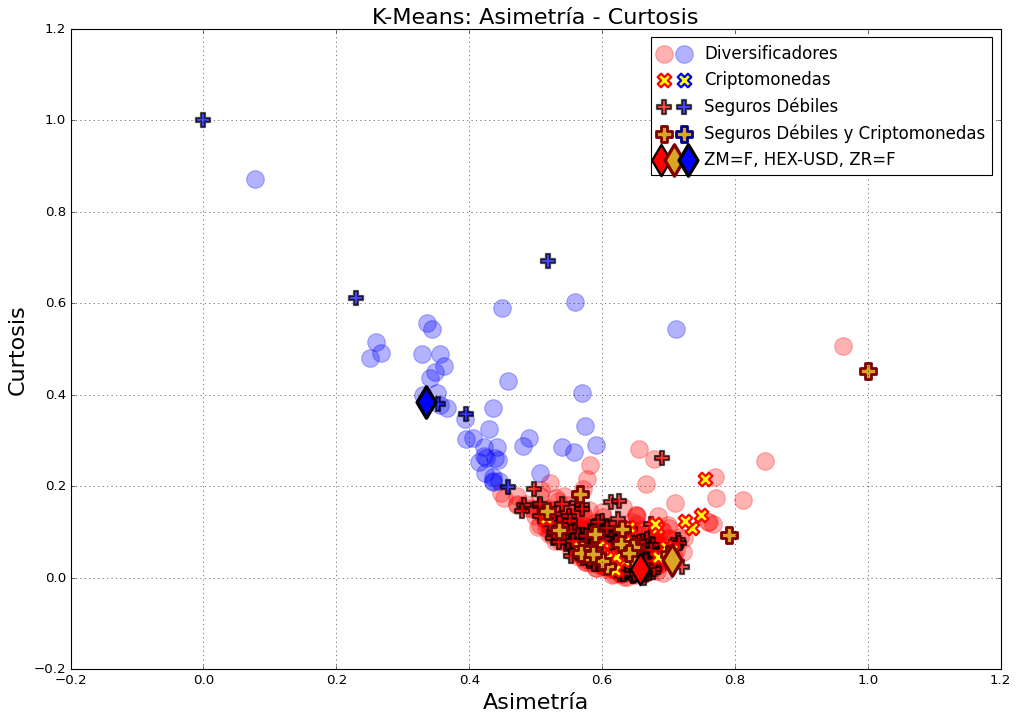

In [ ]:
clusters = [cluster0_kmeans3, cluster1_kmeans3]
colors = ["red", "blue"]
graficos_clusters(skew_kurt_scaled, "Asimetría", "Curtosis", clusters, colors, "K-Means: Asimetría - Curtosis", "Clusters_Kmeans_skew_kurt", False)

In [ ]:
Hubert_Normalized(skew_kurt_scaled, "euclideana", clusters)

# **2.2 DBSCAN ASIMETRÍA CURTOSIS**

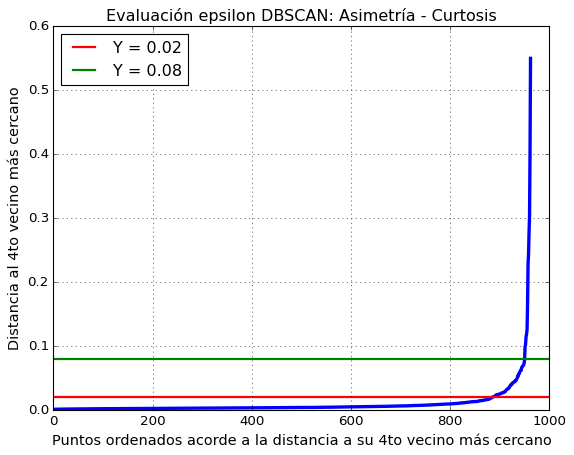

In [ ]:
#Esta sección la saqué de https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(skew_kurt_scaled)
distances, indices = neighbors_fit.kneighbors(skew_kurt_scaled)
for i in range(len(distances)):
  distances[i] = np.sort(distances[i])                                          #Cada fila es la distancia del punto a sus 4 vecinos más cercanos, se ordena para tomar el 4to más cercano
distances = distances[:,3]                                                      #Tomo la distancia al 4to vecino más cercano
distances = np.sort(distances)                                                  #Ordeno todos los puntos de menor a mayor distancia al 4to vecino más cercano

#Ploteando las distancias
fig, ax = plt.subplots(facecolor = "white")
plt.plot(distances, linewidth  = 3)
plt.xlabel("Puntos ordenados acorde a la distancia a su 4to vecino más cercano", fontsize = 13)
plt.ylabel("Distancia al 4to vecino más cercano", fontsize = 13)
plt.axhline(y = 0.02, label = "Y = 0.02", color = "red", linewidth = 2)
plt.axhline(y = 0.08, label = "Y = 0.08", color = "green", linewidth = 2)
plt.title("Evaluación epsilon DBSCAN: Asimetría - Curtosis" )
plt.grid()
plt.legend(loc = "upper left")

#plt.savefig("epsilon_dbscan_asimetria_curtosis.png", bbox_inches = "tight")
#files.download("epsilon_dbscan_asimetria_curtosis.png")
plt.show()

In [ ]:
modelo_dbscan2 = DBSCAN(
                    eps          = 0.05,
                    min_samples  = 4,
                    metric       = 'euclidean',
                )

modelo_dbscan2.fit(X=skew_kurt_scaled)

DBSCAN(eps=0.05, min_samples=4)

In [ ]:
clusters_dbscan2 = pd.DataFrame()
clusters_dbscan2["clusters"] = list(modelo_dbscan2.labels_)
clusters_dbscan2.index = skew_kurt.index

outliers2 = []
cluster0_dbscan2 = []

for i in range(len(modelo_dbscan2.labels_)):

  if modelo_dbscan2.labels_[i] == -1:
    outliers2.append(clusters_dbscan2.index[i])
  
  if modelo_dbscan2.labels_[i] == 0:
    cluster0_dbscan2.append(clusters_dbscan2.index[i])  
  

print(len(outliers2))
print(len(cluster0_dbscan2))


21
942


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

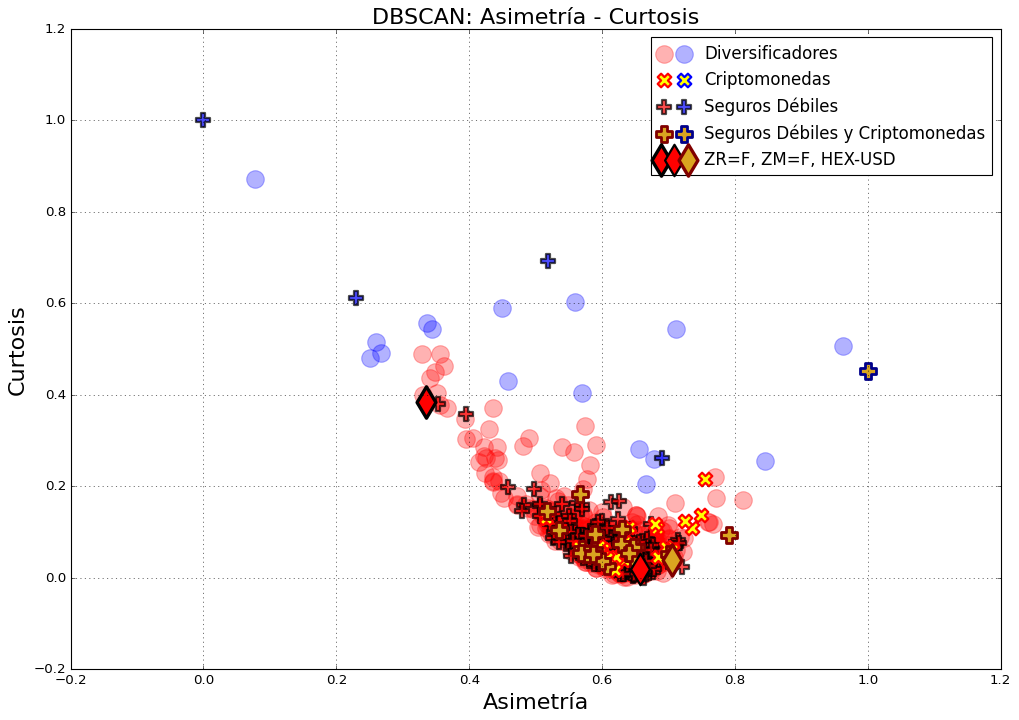

In [ ]:
clusters = [outliers2 ,cluster0_dbscan2]
colors = ["blue", "red"]
graficos_clusters(skew_kurt_scaled, "Asimetría", "Curtosis", clusters, colors, "DBSCAN: Asimetría - Curtosis","DBSCAN_skew_kurt", False)

In [ ]:
Hubert_Normalized_DBSCAN(skew_kurt_scaled, "euclideana", clusters)

# **2.3 AGLOMERATIVO COMPLETE ASIMETRÍA CURTOSIS**

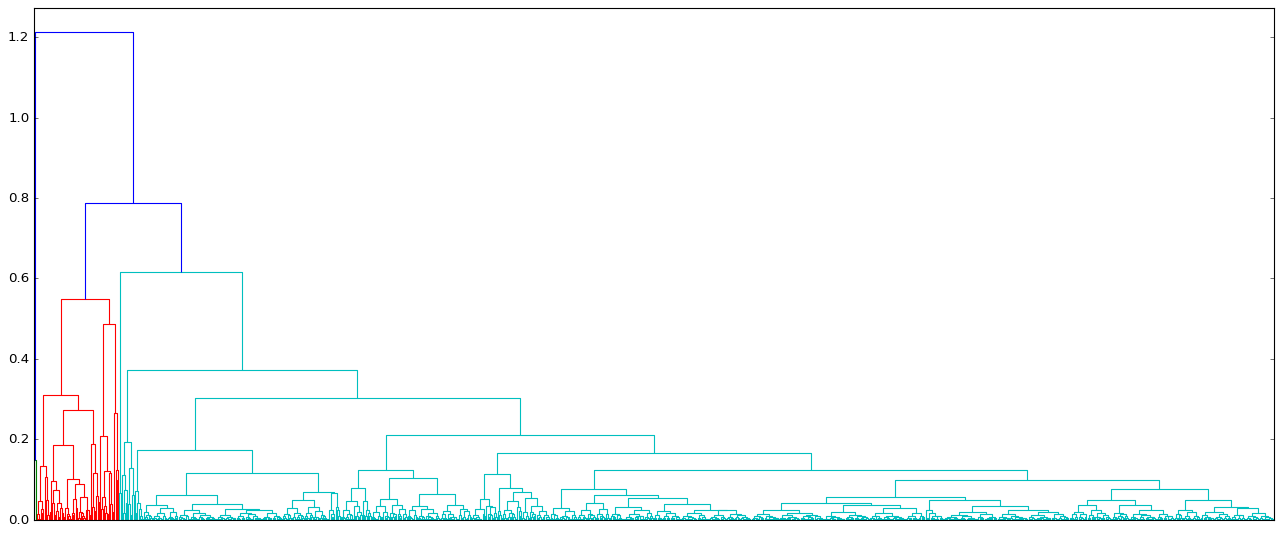

In [ ]:
#PRIMERA VISUALIZACIÓN DEL DENDROGRAMA
agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= 0.62)
agg.fit(skew_kurt_scaled) 
fig, axs = plt.subplots(figsize=(20, 8), facecolor = "white")
plot_dendrogram(agg, no_labels = True, color_threshold = 0.62)
plt.show()

In [ ]:
#Esta sección de código es para ejecutar el clustering agglomerativo y cortarlo en distintos puntos.
#La idea es calcular el SSE y el SIlhouette total en base a las distintas cantidades de clusteres que hayan sido generados

SSE_x_clusters = []
Silhouette_x_clusters = []

n_clusters = []
distancia_corte = []

agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= 0.01)       #Punto de partida
agg.fit(skew_kurt_scaled)
etiquetas = agg.labels_

SSE_x_clusters.append(SSE_euclideana(skew_kurt_scaled, etiquetas))
Silhouette_x_clusters.append(silhouette_score(skew_kurt_scaled, etiquetas))


n_clusters_actual = (len(np.unique(etiquetas)))
n_clusters.append(n_clusters_actual) 
distancia_corte.append(0.01)


corte = [*np.arange(0.02, 1.2, 0.01)]
for i in range(len(corte)):
  
  agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= corte[i])       #Punto de partida
  agg.fit(skew_kurt_scaled)
  etiquetas = list(agg.labels_)
  numero_clusters = len(np.unique(etiquetas))

  if numero_clusters != n_clusters_actual and numero_clusters > 1:
    SSE_x_clusters.append(SSE_euclideana(skew_kurt_scaled, etiquetas))
    Silhouette_x_clusters.append(silhouette_score(skew_kurt_scaled, etiquetas))
    
    n_clusters.append(numero_clusters)
    n_clusters_actual = numero_clusters
    distancia_corte.append(corte[i])

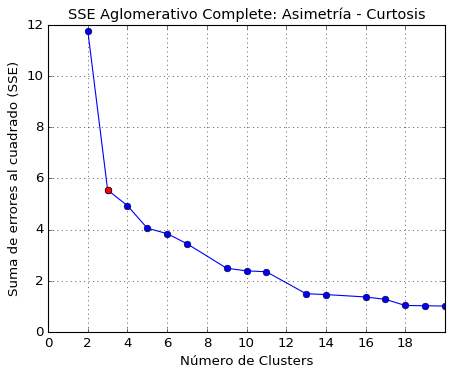

In [ ]:
fig, ax = plt.subplots(figsize = (6.4, 4.8), facecolor = "white")
plt.plot(n_clusters, SSE_x_clusters, marker = "o")
plt.plot(3, SSE_x_clusters[-2], marker = "o", color = "red")
plt.xlabel("Número de Clusters", fontsize = 12)
plt.ylabel("Suma de errores al cuadrado (SSE)", fontsize = 12)
plt.title("SSE Aglomerativo Complete: Asimetría - Curtosis", fontsize = 13)
plt.grid()

eje_x = [*range(0,20,2)]
ax.set_xticks(eje_x)
plt.xlim(0,20)

#plt.savefig("Elbow_aglomerativo_complete_skew_kurt.png", bbox_inches = "tight")
#files.download("Elbow_aglomerativo_complete_skew_kurt.png")
plt.show()

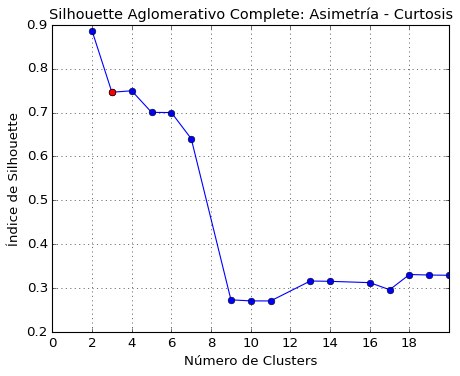

In [ ]:
fig, ax = plt.subplots(figsize = (6.4, 4.8), facecolor = "white")
plt.plot(n_clusters, Silhouette_x_clusters, marker = "o")
plt.plot(3, Silhouette_x_clusters[-2], marker = "o", color = "red")
plt.xlabel("Número de Clusters", fontsize = 12)
plt.ylabel("Índice de Silhouette", fontsize = 12)
plt.title("Silhouette Aglomerativo Complete: Asimetría - Curtosis", fontsize = 13)
plt.grid()

eje_x = [*range(0,20,2)]
ax.set_xticks(eje_x)
plt.xlim(0,20)

#plt.savefig("Silhouette_aglomerativo_complete_skew_kurt.png", bbox_inches = "tight")
#files.download("Silhouette_aglomerativo_complete_skew_kurt.png")

plt.show()

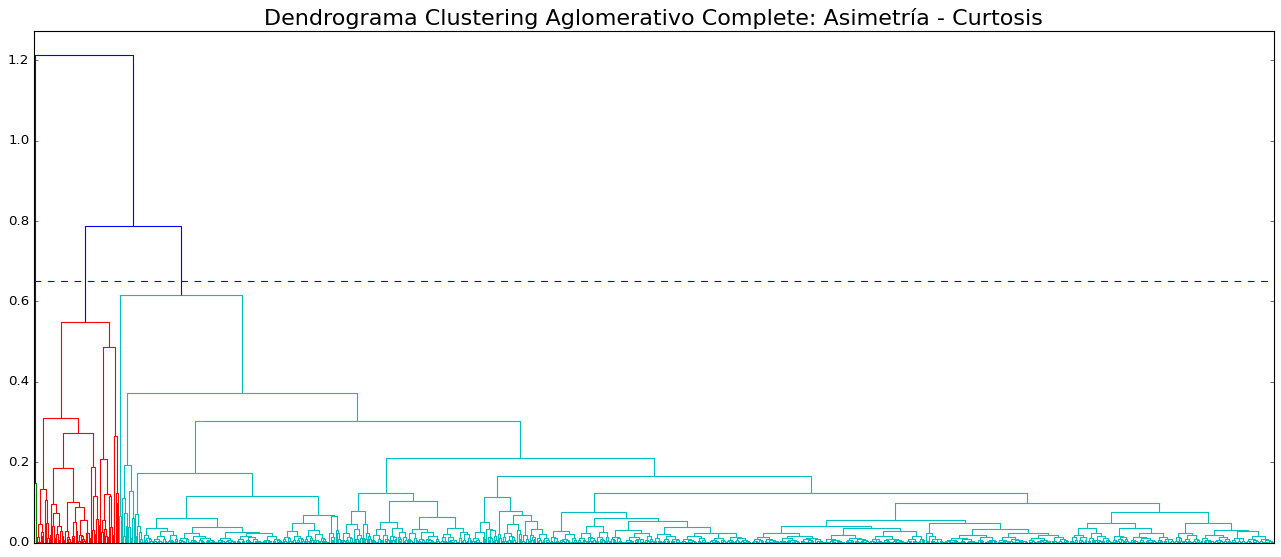

In [ ]:
agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= 0.62)
agg.fit(skew_kurt_scaled) 

fig, axs = plt.subplots(figsize=(20, 8), facecolor = "white")
plot_dendrogram(agg, no_labels = True, color_threshold = 0.62)
plt.axhline(0.65, linestyle = "--", linewidth = 1)
plt.title("Dendrograma Clustering Aglomerativo Complete: Asimetría - Curtosis", fontsize = 20)
#plt.savefig("Dendrograma_aglomerativo_complete_skew_kurt.png", bbox_inches = "tight")
#files.download("Dendrograma_aglomerativo_complete_skew_kurt.png")
plt.show()

In [ ]:
clusters_aglomerativo_skew_kurt = pd.DataFrame()
clusters_aglomerativo_skew_kurt["clusters"] = agg.labels_
clusters_aglomerativo_skew_kurt.index = log_return.columns[1:]

cluster0_aglomerativo_skew_kurt = []
cluster1_aglomerativo_skew_kurt = []
cluster2_aglomerativo_skew_kurt = []

for i in range(len(clusters_aglomerativo_skew_kurt.index)):
  if agg.labels_[i] == 0:
    cluster0_aglomerativo_skew_kurt.append(clusters_aglomerativo_skew_kurt.index[i])

  if agg.labels_[i] == 1:
    cluster1_aglomerativo_skew_kurt.append(clusters_aglomerativo_skew_kurt.index[i])

  if agg.labels_[i] == 2:
    cluster2_aglomerativo_skew_kurt.append(clusters_aglomerativo_skew_kurt.index[i])

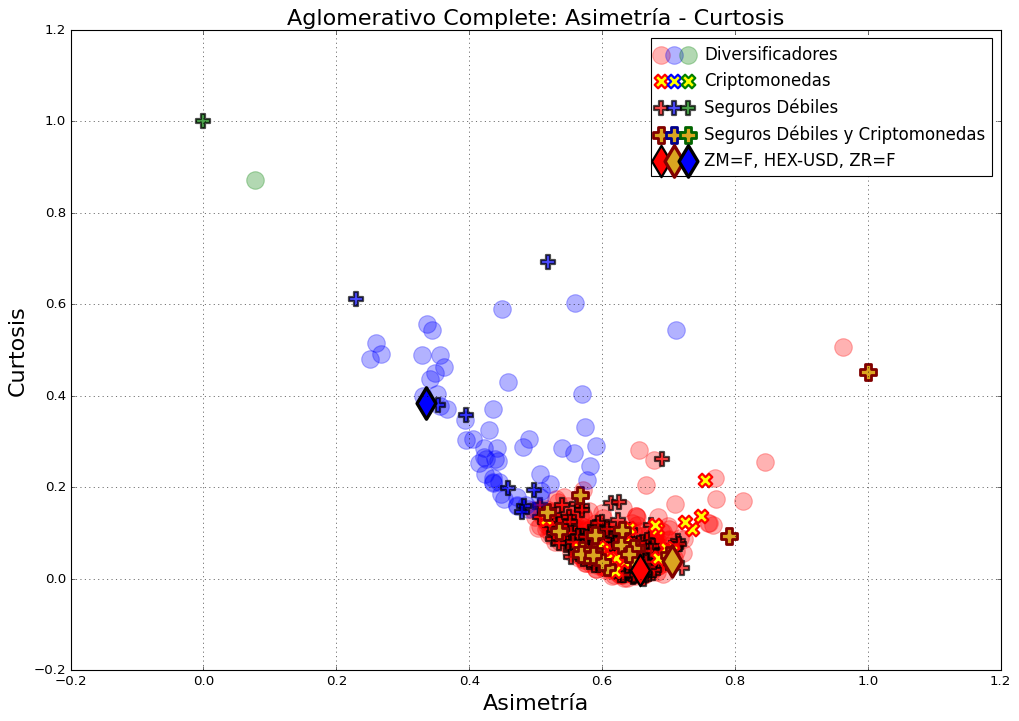

In [ ]:
clusters = [cluster0_aglomerativo_skew_kurt, cluster1_aglomerativo_skew_kurt, cluster2_aglomerativo_skew_kurt]
colors = ["red", "green", "blue"]
graficos_clusters(skew_kurt_scaled, "Asimetría", "Curtosis", clusters, colors, "Aglomerativo Complete: Asimetría - Curtosis", "Aglomerativo_complete_skew_kurt", False)

In [ ]:
CCPC(skew_kurt_scaled, "complete", "euclideana")

# **3.1 K-MEANS TENDENCIA - ESTACIONALIDAD (PRESENCIA)**

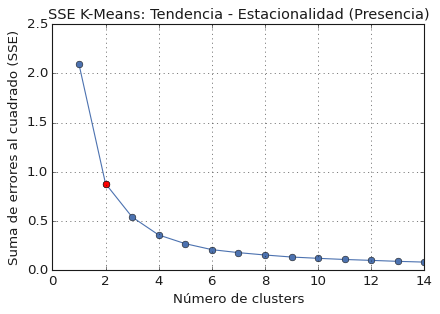

In [ ]:
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo_kmeans.fit(trend_season)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84), facecolor = "white")
ax.plot(range_n_clusters, inertias, marker='o')
plt.plot(2, inertias[1], marker = "o", color = "red")
plt.plot()
ax.set_title("SSE K-Means: Tendencia - Estacionalidad (Presencia)", fontsize = 13)
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Suma de errores al cuadrado (SSE)');

plt.grid()
#plt.savefig("Elbow_Kmeans_trend_season.png", bbox_inches = "tight")
#files.download("Elbow_Kmeans_trend_season.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

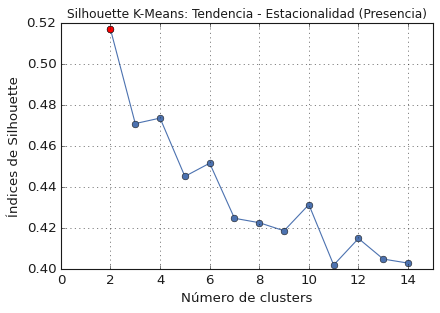

In [ ]:
#Método de Silhouette para determinar el número óptimo de Clusters
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(trend_season)
    silhouette_avg = silhouette_score(trend_season, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84), facecolor = "white")
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
plt.plot(2, valores_medios_silhouette[0], marker = "o", color = "red")
ax.set_title("Silhouette K-Means: Tendencia - Estacionalidad (Presencia)", fontsize = 11)
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Índices de Silhouette');
plt.xlim(0,15)
plt.grid()
#plt.savefig("Silhouette_Kmeans_Ret_Var.png", bbox_inches = "tight")
#files.download("Silhouette_Kmeans_Ret_Var.png")

plt.show()

In [ ]:
#El método de Elbow muestra que entre 2 y 3 clusters se puede observar el "codo" indicando que ese podría ser el número óptimo de clusters
#En cambio, el método de Silhouette, claramente indica que son 2 los grupos existentes ya que es el valor que maximiza la media de indices silhouette
#NOTA: LO RECIÉN DICHO APLICA UTILIZANDO LOS RETORNOS MEDIOS Y LA VARIANZA DE CADA SERIE COMO LAS VARIABLES PARA EL CLUSTER.
modelo_kmeans4 = KMeans(n_clusters=2, n_init=25, random_state=123)
modelo_kmeans4 = modelo_kmeans4.fit(X = trend_season)

clusters_kmeans4 = pd.DataFrame()
clusters_kmeans4["clusters"] = modelo_kmeans4.labels_
clusters_kmeans4.index = trend_season.index


cluster0_kmeans4 = []
cluster1_kmeans4 = []



for i in range(len(modelo_kmeans4.labels_)):
  if modelo_kmeans4.labels_[i] == 0:
    cluster0_kmeans4.append(clusters_kmeans4.index[i])

  if modelo_kmeans4.labels_[i] == 1:
    cluster1_kmeans4.append(clusters_kmeans4.index[i])



print(len(cluster0_kmeans4))
print(len(cluster1_kmeans4))

511
452


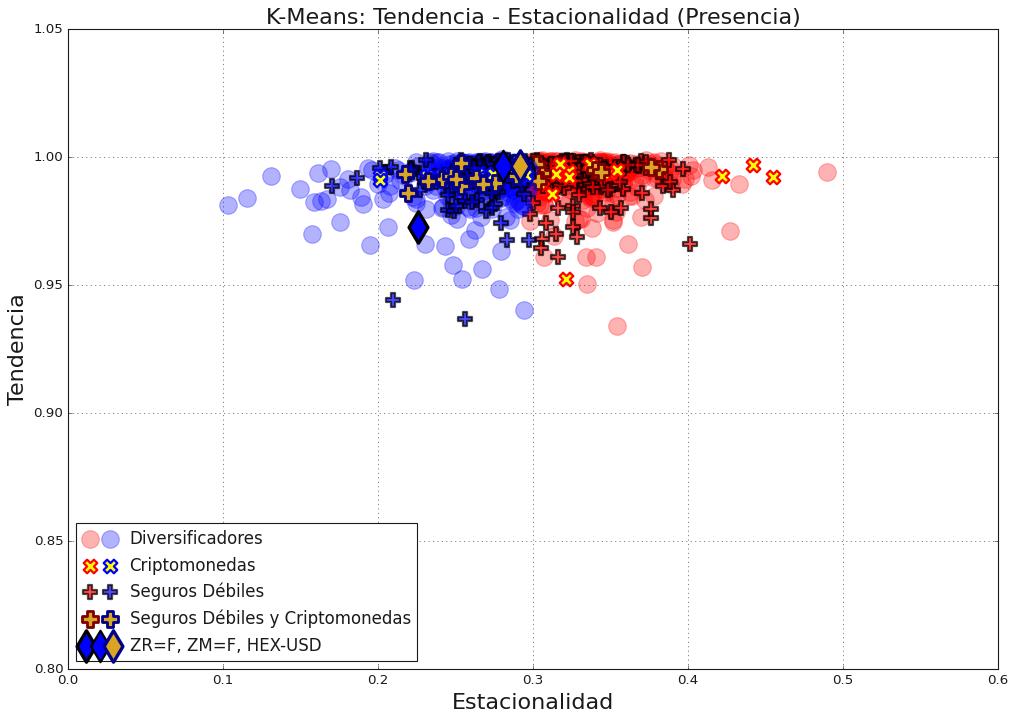

In [ ]:
clusters = [cluster0_kmeans4, cluster1_kmeans4]
colors = ["red", "blue"]
graficos_clusters(trend_season, "Estacionalidad", "Tendencia", clusters, colors, "K-Means: Tendencia - Estacionalidad (Presencia)" ,"Clusters_Kmeans_trend_season", False)

In [ ]:
clusters = [cluster0_kmeans4, cluster1_kmeans4]
Hubert_Normalized(trend_season, "euclideana", clusters)

0.4932677483313121

# **3.2 DBSCAN TENDENCIA - ESTACIONALIDAD (PRESENCIA)**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

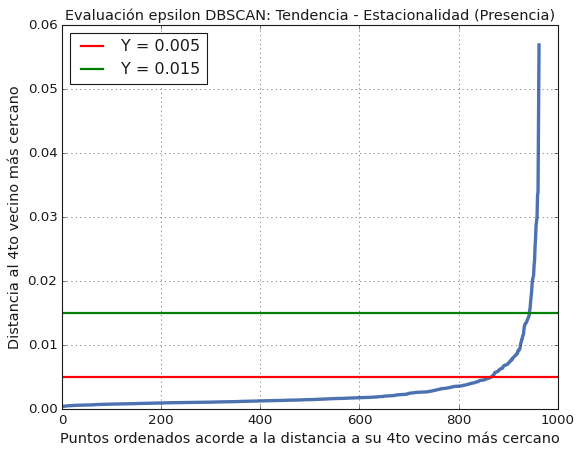

In [ ]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(trend_season)
distances, indices = neighbors_fit.kneighbors(trend_season)
for i in range(len(distances)):
  distances[i] = np.sort(distances[i])                                          #Cada fila es la distancia del punto a sus 4 vecinos más cercanos, se ordena para tomar el 4to más cercano
distances = distances[:,3]                                                      #Tomo la distancia al 4to vecino más cercano
distances = np.sort(distances)                                                  #Ordeno todos los puntos de menor a mayor distancia al 4to vecino más cercano

#Ploteando las distancias
fig, ax = plt.subplots(facecolor = "white")
plt.plot(distances, linewidth  = 3)
plt.xlabel("Puntos ordenados acorde a la distancia a su 4to vecino más cercano", fontsize = 13)
plt.ylabel("Distancia al 4to vecino más cercano", fontsize = 13)
plt.axhline(y = 0.005, label = "Y = 0.005", color = "red", linewidth = 2)
plt.axhline(y = 0.015, label = "Y = 0.015", color = "green", linewidth = 2)


plt.title("Evaluación epsilon DBSCAN: Tendencia - Estacionalidad (Presencia)", fontsize = 13 )
plt.grid()
plt.legend(loc = "upper left")

#plt.savefig("epsilon_dbscan_trend_season.png", bbox_inches = "tight")
#files.download("epsilon_dbscan_trend_season.png")
plt.show()

In [ ]:
modelo_dbscan3 = DBSCAN(
                    eps          = 0.01,
                    min_samples  = 4,
                    metric       = 'euclidean',
                )

modelo_dbscan3.fit(X=trend_season)
np.unique(modelo_dbscan3.labels_)

array([-1,  0])

In [ ]:
clusters_dbscan3 = pd.DataFrame()
clusters_dbscan3["clusters"] = list(modelo_dbscan3.labels_)
clusters_dbscan3.index = skew_kurt.index

outliers3 = []
cluster0_dbscan3 = []



for i in range(len(modelo_dbscan3.labels_)):

  if modelo_dbscan3.labels_[i] == -1:
    outliers3.append(clusters_dbscan3.index[i])
  
  if modelo_dbscan3.labels_[i] == 0:
    cluster0_dbscan3.append(clusters_dbscan3.index[i])  

print(len(outliers3))
print(len(cluster0_dbscan3))


29
934


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

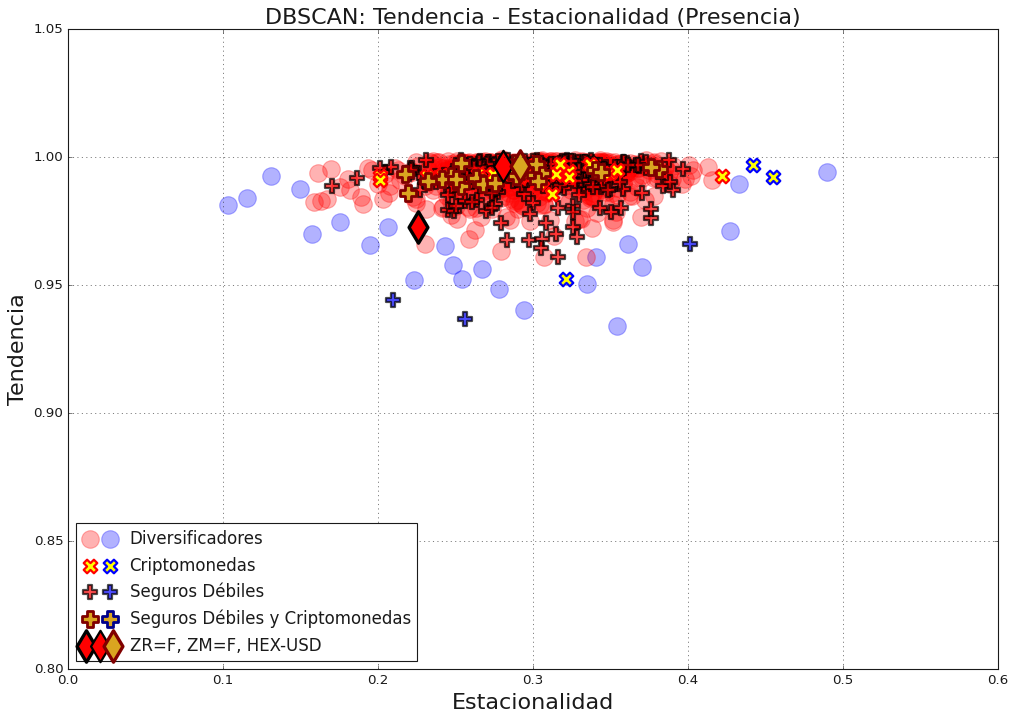

In [ ]:
clusters = [outliers3 ,cluster0_dbscan3]
colors = ["blue", "red"]
graficos_clusters(trend_season, "Estacionalidad", "Tendencia", clusters, colors, "DBSCAN: Tendencia - Estacionalidad (Presencia)", "DBSCAN_trend_Season", False)

In [ ]:
Hubert_Normalized_DBSCAN(trend_season, "euclideana", clusters)

0.34628273064361453

# **3.3 AGLOMERATIVO COMPLETE: TENDENCIA - ESTACIONALIDAD (PRESENCIA)**

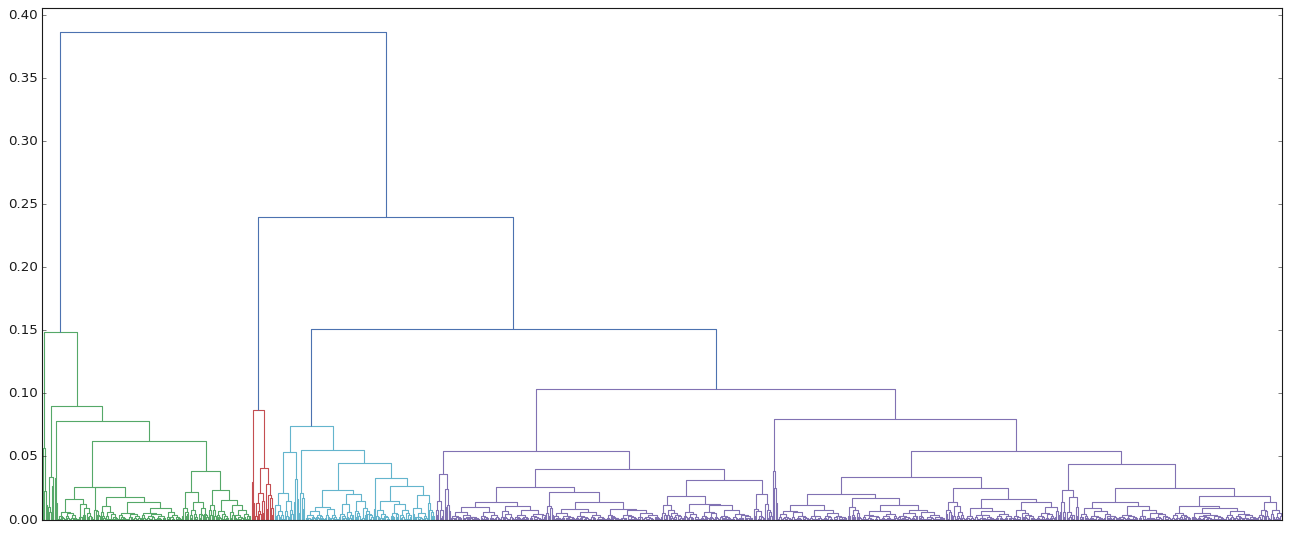

In [ ]:
# PARA VISUALIZAR EL DENDROGRAMA
agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= 0.14)
agg.fit(trend_season) 
fig, axs = plt.subplots(figsize=(20, 8), facecolor = "white")
plot_dendrogram(agg, no_labels = True, color_threshold = 0.15)
plt.show()

In [ ]:
#Esta sección de código es para ejecutar el clustering agglomerativo y cortarlo en distintos puntos.
#La idea es calcular el SSE y el SIlhouette total en base a las distintas cantidades de clusteres que hayan sido generados

SSE_x_clusters = []
Silhouette_x_clusters = []

n_clusters = []
distancia_corte = []

agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= 0.01)       #Punto de partida
agg.fit(trend_season)
etiquetas = agg.labels_

SSE_x_clusters.append(SSE_euclideana(trend_season, etiquetas))
Silhouette_x_clusters.append(silhouette_score(trend_season, etiquetas))


n_clusters_actual = (len(np.unique(etiquetas)))
n_clusters.append(n_clusters_actual) 
distancia_corte.append(0.01)


corte = [*np.arange(0.02, 0.4, 0.01)]
for i in range(len(corte)):
  
  agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= corte[i])       #Punto de partida
  agg.fit(trend_season)
  etiquetas = list(agg.labels_)
  numero_clusters = len(np.unique(etiquetas))

  if numero_clusters != n_clusters_actual and numero_clusters > 1:
    SSE_x_clusters.append(SSE_euclideana(trend_season, etiquetas))
    Silhouette_x_clusters.append(silhouette_score(trend_season, etiquetas))
    
    n_clusters.append(numero_clusters)
    n_clusters_actual = numero_clusters
    distancia_corte.append(corte[i])

In [ ]:
distancia_corte

[0.01,
 0.02,
 0.03,
 0.039999999999999994,
 0.049999999999999996,
 0.06,
 0.06999999999999999,
 0.07999999999999999,
 0.09,
 0.10999999999999999,
 0.14999999999999997,
 0.15999999999999998,
 0.23999999999999996]

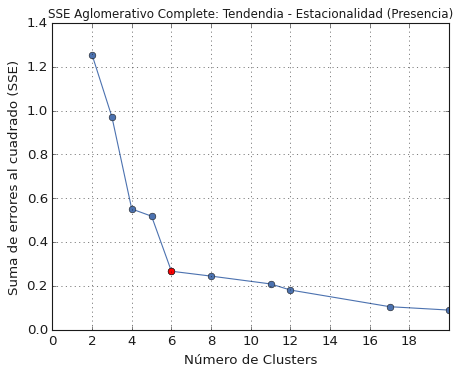

In [ ]:
fig, ax = plt.subplots(figsize = (6.4, 4.8), facecolor = "white")
plt.plot(n_clusters, SSE_x_clusters, marker = "o")
plt.plot(6, SSE_x_clusters[-5], marker = "o", color = "red")
plt.xlabel("Número de Clusters", fontsize = 12)
plt.ylabel("Suma de errores al cuadrado (SSE)", fontsize = 12)
plt.title("SSE Aglomerativo Complete: Tendendia - Estacionalidad (Presencia)", fontsize = 10.7)
plt.grid()

eje_x = [*range(0,20,2)]
ax.set_xticks(eje_x)
plt.xlim(0,20)

#plt.savefig("Elbow_aglomerativo_complete_trend_season.png", bbox_inches = "tight")
#files.download("Elbow_aglomerativo_complete_trend_season.png")
plt.show()

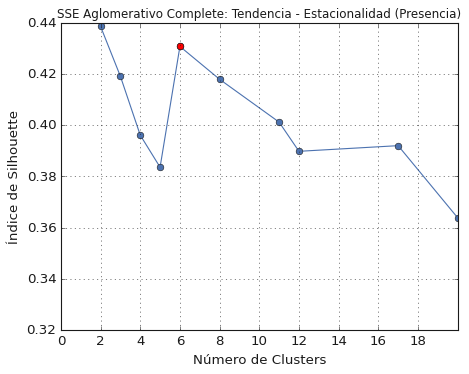

In [ ]:
fig, ax = plt.subplots(figsize = (6.4, 4.8), facecolor = "white")
plt.plot(n_clusters, Silhouette_x_clusters, marker = "o")
plt.plot(6, Silhouette_x_clusters[-5], marker = "o", color = "red")
plt.xlabel("Número de Clusters", fontsize = 12)
plt.ylabel("Índice de Silhouette", fontsize = 12)
plt.title("SSE Aglomerativo Complete: Tendencia - Estacionalidad (Presencia)", fontsize = 10.7)
plt.grid()

eje_x = [*range(0,20,2)]
ax.set_xticks(eje_x)
plt.xlim(0,20)

#plt.savefig("Silhouette_aglomerativo_complete_trend_season.png", bbox_inches = "tight")
#files.download("Silhouette_aglomerativo_complete_trend_season.png")

plt.show()

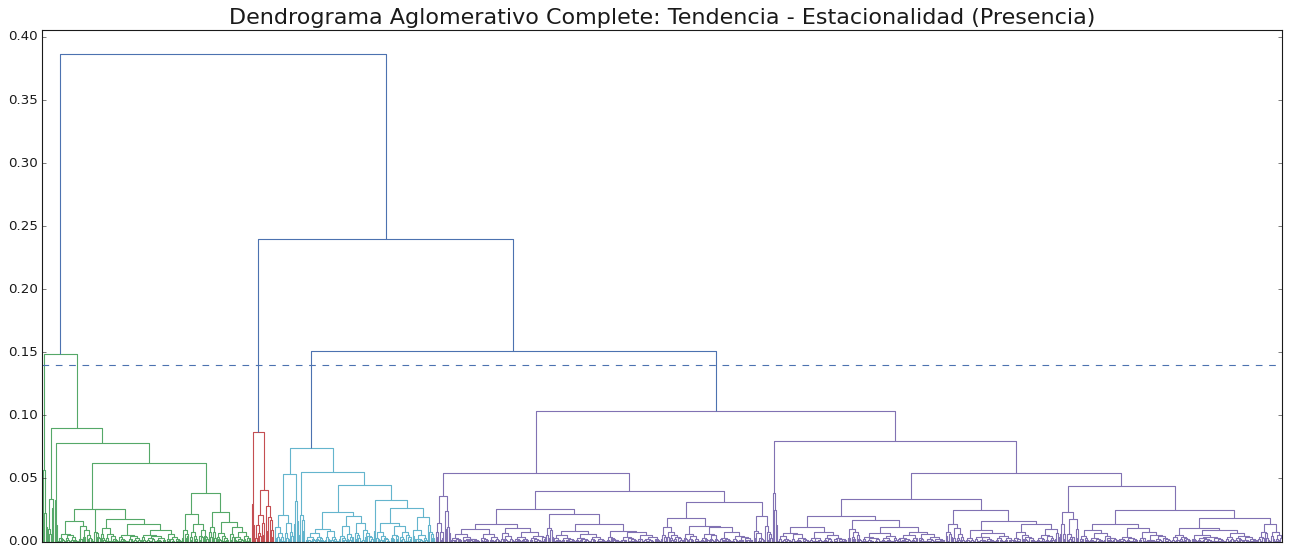

In [ ]:
agg = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage = 'complete', distance_threshold= 0.09)
agg.fit(trend_season) 

fig, axs = plt.subplots(figsize=(20, 8), facecolor = "white")
plot_dendrogram(agg, no_labels = True, color_threshold = 0.15)
plt.axhline(0.14, linestyle = "--", linewidth = 1)
plt.title("Dendrograma Aglomerativo Complete: Tendencia - Estacionalidad (Presencia)", fontsize = 20)
#plt.savefig("Dendrograma_aglomerativo_complete_skew_kurt.png", bbox_inches = "tight")
#files.download("Dendrograma_aglomerativo_complete_skew_kurt.png")
plt.show()

In [ ]:
clusters_aglomerativo_trend_season = pd.DataFrame()
clusters_aglomerativo_trend_season["clusters"] = agg.labels_
clusters_aglomerativo_trend_season.index = log_return.columns[1:]

cluster0_aglomerativo_trend_season = []
cluster1_aglomerativo_trend_season = []
cluster2_aglomerativo_trend_season = []
cluster3_aglomerativo_trend_season = []
cluster4_aglomerativo_trend_season = []
cluster5_aglomerativo_trend_season = []

for i in range(len(clusters_aglomerativo_trend_season.index)):
  if agg.labels_[i] == 0:
    cluster0_aglomerativo_trend_season.append(clusters_aglomerativo_trend_season.index[i])

  if agg.labels_[i] == 1:
    cluster1_aglomerativo_trend_season.append(clusters_aglomerativo_trend_season.index[i])

  if agg.labels_[i] == 2:
    cluster2_aglomerativo_trend_season.append(clusters_aglomerativo_trend_season.index[i])

  if agg.labels_[i] == 3:
    cluster3_aglomerativo_trend_season.append(clusters_aglomerativo_trend_season.index[i])

  if agg.labels_[i] == 4:
    cluster4_aglomerativo_trend_season.append(clusters_aglomerativo_trend_season.index[i])

  if agg.labels_[i] == 5:
    cluster5_aglomerativo_trend_season.append(clusters_aglomerativo_trend_season.index[i])

print(len(cluster0_aglomerativo_trend_season))
print(len(cluster1_aglomerativo_trend_season))
print(len(cluster2_aglomerativo_trend_season))
print(len(cluster3_aglomerativo_trend_season))
print(len(cluster4_aglomerativo_trend_season))
print(len(cluster5_aglomerativo_trend_season))

158
396
18
125
4
262


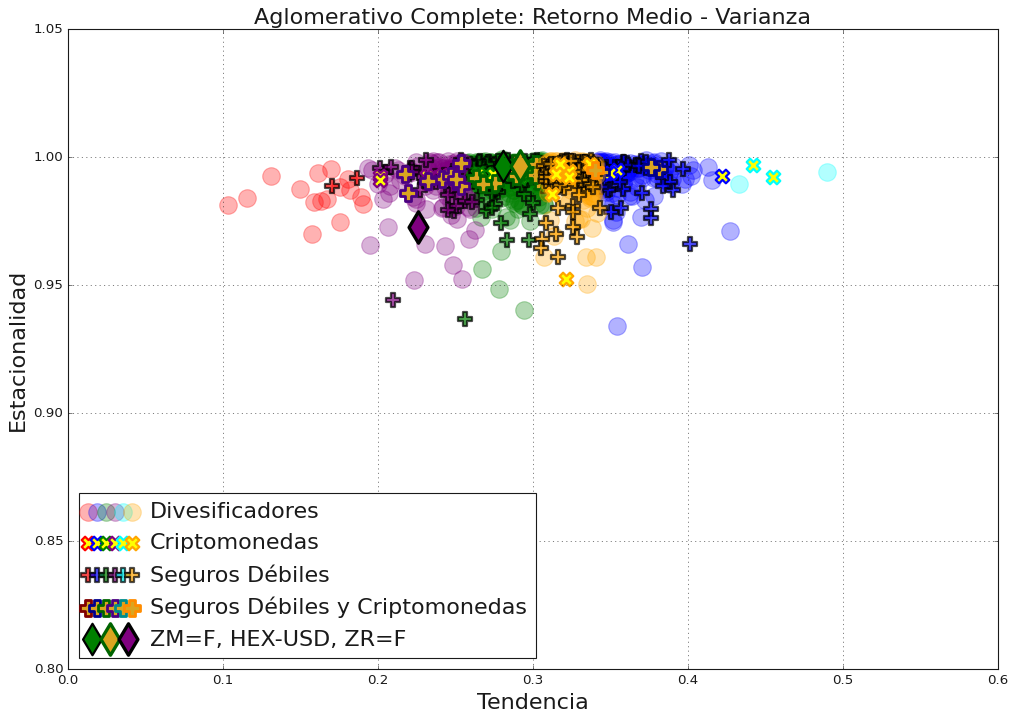

In [ ]:
clusters = [cluster0_aglomerativo_trend_season, cluster1_aglomerativo_trend_season, cluster2_aglomerativo_trend_season, cluster3_aglomerativo_trend_season, cluster4_aglomerativo_trend_season, cluster5_aglomerativo_trend_season]
colors = ["blue", "green", "red", "purple", "aqua", "orange"]
graficos_clusters(trend_season, "Tendencia", "Estacionalidad", clusters, colors, "Aglomerativo Complete: Retorno Medio - Varianza" ,"Clusters_aglomerativo_complete_trend_Season", False)

In [ ]:
CCPC(trend_season, "complete", "euclideana")

0.5901415560329001

# **4.1 AGLOMERATIVO COMPLETE: ALFA - BETA**

In [ ]:
#CALCULA LA MATRIZ DE DISTANCIAS PARA TODOS LOS PUNTOS
#Y LUEGO HACER EL CLUSTER AGLOMERATIVO (TIRANDO AFFINITY = "PRECOMPUTED" Y FITEANDO CON LA MATRIZ DE DISTANCIA)

distance_matrix = []

for i in range(len(alfa_beta)):
  distance_list = []
  for j in range(len(alfa_beta)):
    serie1 = list(alfa_beta.iloc[i])
    serie2 = list(alfa_beta.iloc[j])
    distance = distancia_garch(serie1, serie2)
    distance_list.append(distance)
  
  distance_matrix.append(distance_list)

In [ ]:
#CÁLCULO DE SSE PERO MODIFICADO PARA UTILIZAR LA DISTANCIA REQUERIDA PARA COMPARAR MODELOS GARCH
#labels: lista que indica a qué cluster pertenece cada punto
#corte: punto en el que se corta el dendrograma --> cantidad de clusters generados

#NOTA: comprobé que el código estuviese bien implementado modificándolo para la distancia euclideana y comparándolo con la funcion Kmeans.inertia_ ... Me dió exactamente el mismo resultado :)
def SSE(data, labels):

  n_clusters = np.unique(labels)                                                #Lista que contiene la cantidad de clusters que hay, ej [0,1,2,3,4,5,6] (7 clusters)
  clusters = []                                                                 #Lista de listas. Cada una de las listas que la conforman consiste en los activos que pertenecen a ese cluster
  
  for i in n_clusters:                                                          #Para cada uno de los clusters que hay...
    cluster_k = []                                                              #Guardar en esta lista...
    for j in range(len(labels)):                                                #Aquellos activos que pertenezcan a dicho cluster
      if labels[j] == i:
        cluster_k.append(j)                                                     #Lo que guardo en la lista es el índice de aquellos activos que pertenecen al mismo cluster

    clusters.append(cluster_k)

  #Ahora para cada cluster se calcula la suma de la distancia al cuadrado del punto al centroide
  
  SSE = []                                                                      #Calcular el SSE para cada cluster, guardar en esta lista y el SSE total será la suma de esta lista
  for i in range(len(clusters)):
    
    df = data.iloc[clusters[i]]                                                 #Toma los datos de aquellos que pertenecen al mismo cluster
    
    #Calcula el centroide del cluster
    centroide_x = sum(df[df.columns[0]])/len(df)
    centroide_y = sum(df[df.columns[1]])/len(df)
    centroide = [centroide_x, centroide_y]

    
    #Calcular la distancia de cada punto del cluster a su centroide al cuadrado
    SSE_cluster = 0
    for j in range(len(df)):
      SSE_cluster = SSE_cluster + (distancia_garch(centroide, list(df.iloc[j])))**2
                          #Ahí está la gracia ^^^ (Es necesario tener la función de distancia GARCH, disponible en la sección de funciones) 

    SSE.append(SSE_cluster)

  SSE_total = sum(SSE)

  return SSE_total

In [ ]:
#Same para Silhouette, adaptandolo para utilizar la distancia definida
#NOTA: comprobé que el código estuviese bien implementado modificándolo para la distancia euclideana y comparándolo con la funcion Silhouette_score ... Me dió exactamente el mismo resultado :) 

def coeficiente_silhouette(data, labels):
  sil_score = []                                                                #Lista que contiene el coeficiente de Silhouette de cada punto, al final, basta con hacer la suma de esta lista
  n_clusters = np.unique(labels)
  clusters = []                                                                 #Lista de listas, cada lista contiene los índices (del df alfa_beta) de aquellos activos que pertenecen al mismo cluster

  #Ordenando los datos. Busca aquellos que pertenezcan al mismo cluster y se guardan en una lista. Esa lista se agrega a "clusters"
  for i in n_clusters:
    cluster_k = []
    for j in range(len(labels)):
      if labels[j] == i:
        cluster_k.append(j)
    clusters.append(cluster_k)

  #Para cada uno de los puntos, calcular ai, bij, bi
  for i in range(len(labels)):
    
    
    #---------------------------------------------------------------------------Cálculo del "ai"----------------------------------------------------------------------------------------------------
    if len(clusters[labels[i]]) == 1:                                           #Caso específico... si el cluster está formado solo por el mismo punto, ai = 0, sino, calcúlaloooooo
      ai = 0
    else:     
      df = data.iloc[clusters[labels[i]]]                                       #Toma los datos del cluster al que pertenece el punto que estoy analizando (ESTE DF CONTIENE AL MISMO PUNTO... OJO!)
      serie1 = list(data.iloc[i])
      distancia_intra_cluster = []
      
      #Calcula la distancia entre el punto y los demas puntos que pertenecen a su mismo cluster (OJO, VA A CONSIDERAR LA DISTANCIA HACIA SÍ MISMO, TENERLO EN CUENTA A LA HORA DE SACAR EL PROMEDIO)
      for j in range(len(df)):
        serie2 = list(df.iloc[j])
        distancia_intra_cluster.append(distancia_garch(serie1, serie2))     
      ai = sum(distancia_intra_cluster)/(len(df)-1)                             #Menos 1 para no considerar la distancia = "0" producto de la distancia hacia sí mismo
       
    
    #---------------------------------------------------------------------------Cálculo del "bij"-----------------------------------------------------------------------------------------------------
    bij = []
    for k in range(len(clusters)):   
      if labels[i] != k:                                                        #Esta condición es para no considerar el clusters al que pertenece el punto (se calcula la distancia promedio hacia los demás clusters)        
        df_cluster_k = data.iloc[clusters[k]]
        distancias = []         
        for l in range(len(df_cluster_k)):
          serie2 = list(df_cluster_k.iloc[l])
          distancias.append(distancia_garch(serie1, serie2))
        bij.append(sum(distancias)/len(distancias))

    #---------------------------------------------------------------------------Cálculo del Silhouette Score

    bi = min(bij)
    Si = (bi-ai)/max(ai,bi)
    sil_score.append(Si)

  
  Silhouette_total = sum(sil_score)/len(sil_score)


  return Silhouette_total

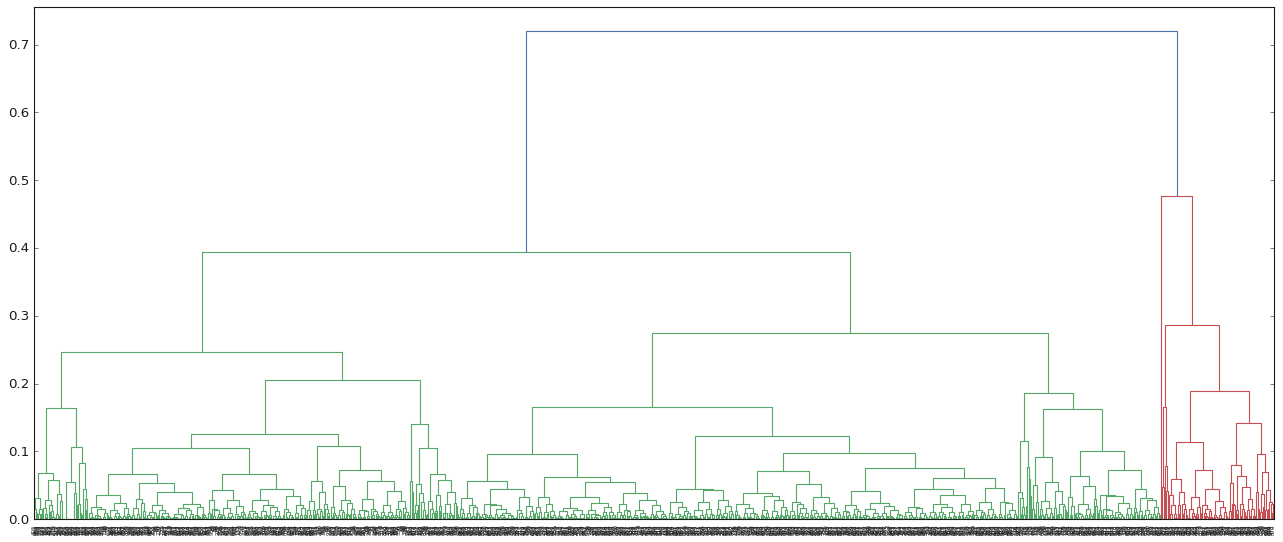

In [ ]:
#VISUALIZANDO EL DENDROGRAMA
agg = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage = 'complete', distance_threshold= 0.9)
agg.fit(distance_matrix) 
fig, axs = plt.subplots(figsize=(20, 8), facecolor = "white")
plot_dendrogram(agg)
plt.show()

In [ ]:
#Esta sección de código es para ejecutar el clustering agglomerativo y cortarlo en distintos puntos.
#La idea es calcular el SSE total en base a las distintas cantidades de clusteres que hayan sido generados
#Luego se selecciona la cantidad de clusters en base al método del codo, es decir, la cantidad de clusters en donde el SSE total sea bajo y a partir del cual generar más clusters no cambia significativamente

SSE_x_clusters2 = []
Silhouette_x_clusters2 = []

n_clusters2 = []
distancia_corte2 = []

agg = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage = 'complete', distance_threshold= 0.11)       #Punto de partida
agg.fit(distance_matrix)
etiquetas = agg.labels_

SSE_x_clusters2.append(SSE(alfa_beta, etiquetas))
Silhouette_x_clusters2.append(coeficiente_silhouette(alfa_beta, etiquetas))


n_clusters_actual = (len(np.unique(etiquetas)))
n_clusters2.append(n_clusters_actual) 
distancia_corte2.append(0.01)


corte = [*np.arange(0.12, 0.6, 0.01)]
for i in range(len(corte)):
  
  agg = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage = 'complete', distance_threshold= corte[i])       #Punto de partida
  agg.fit(distance_matrix)
  etiquetas = list(agg.labels_)
  numero_clusters = len(np.unique(etiquetas))

  if numero_clusters != n_clusters_actual:
    SSE_x_clusters2.append(SSE(alfa_beta, etiquetas))
    Silhouette_x_clusters2.append(coeficiente_silhouette(alfa_beta, etiquetas))
    
    n_clusters2.append(numero_clusters)
    n_clusters_actual = numero_clusters
    distancia_corte2.append(corte[i])

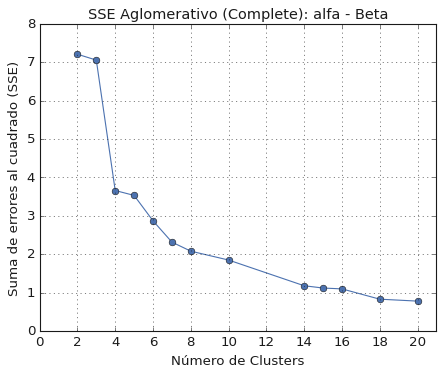

In [ ]:
fig, ax = plt.subplots(figsize = (6.4, 4.8), facecolor = "white")
plt.plot(n_clusters2, SSE_x_clusters2, marker = "o")
plt.xlabel("Número de Clusters", fontsize = 12)
plt.ylabel("Suma de errores al cuadrado (SSE)", fontsize = 12)
plt.title("SSE Aglomerativo (Complete): alfa - Beta", fontsize = 13)
plt.grid()

eje_x = [*range(0,22,2)]
ax.set_xticks(eje_x)
plt.xlim(0,21)

#plt.savefig("Elbow_aglomerativo_complete_alfa_beta.png", bbox_inches = "tight")
#files.download("Elbow_aglomerativo_complete_alfa_beta.png")
plt.show()

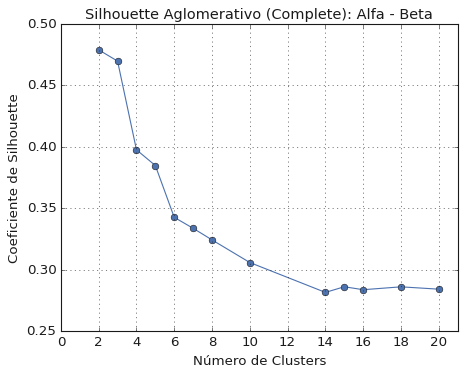

In [ ]:
fig, ax = plt.subplots(figsize = (6.4,4.8), facecolor = "white")
plt.plot(n_clusters2, Silhouette_x_clusters2, marker = "o")
plt.xlabel("Número de Clusters", fontsize = 12)
plt.ylabel("Coeficiente de Silhouette", fontsize = 12)
plt.title("Silhouette Aglomerativo (Complete): Alfa - Beta", fontsize = 13)
plt.grid()

eje_x = [*range(0,22,2)]
ax.set_xticks(eje_x)
plt.xlim(0,21)

#plt.savefig("Silhouette_aglomerativo_complete_alfa_beta.png", bbox_inches = "tight")
#files.download("Silhouette_aglomerativo_complete_alfa_beta.png")

plt.show()

In [ ]:
CCPC(alfa_beta, "complete", "GARCH")

0.6728520430859551

# **SIMULACIONES MONTECARLO: CCPC (AGLOMERATIVOS)**

In [ ]:
rv = MonteCarlo_CCPC(ret_var_scaled, 100, "complete", "euclideana")
mc_ret_var_complete = pd.DataFrame()
mc_ret_var_complete["CCPC"] = rv
mc_ret_var_complete.to_csv("mc_ret_var_complete.csv")
#files.download("mc_ret_var_complete.csv")

In [ ]:
sk = MonteCarlo_CCPC(skew_kurt_scaled, 100, "complete", "euclideana")
mc_skew_kurt_complete = pd.DataFrame()
mc_skew_kurt_complete["CCPC"] = sk
mc_skew_kurt_complete.to_csv("mc_skew_kurt_complete.csv")
#files.download("mc_skew_kurt_complete.csv")

In [ ]:
ab = MonteCarlo_CCPC(alfa_beta, 100, "complete", "GARCH")
mc_alfa_beta_complete = pd.DataFrame()
mc_alfa_beta_complete["CCPC"] = ab
mc_alfa_beta_complete.to_csv("mc_alfa_beta_complete.csv")
#files.download("mc_alfa_beta_complete.csv")

In [ ]:
ts = MonteCarlo_CCPC(trend_season, 100, "complete", "euclideana")
mc_trend_season_complete = pd.DataFrame()
mc_trend_season_complete["CCPC"] = ts
mc_trend_season_complete.to_csv("mc_trend_season_complete.csv")
#files.download("mc_trend_season_complete.csv")

NOTA: LAS SIMULACIONES TARDAN COMO MÍNIMO 6 HORAS (CADA CELDA). EN MI CASO, LAS DEJÉ EJECUTANDO Y LAS GUARDÉ EN UN CSV PARA LUEGO VISUALIZARLAS

In [ ]:
files.upload()

In [ ]:
mc_ret_var = pd.read_csv("mc_ret_var_complete.csv").drop("Unnamed: 0", axis = 1)
mc_skew_kurt = pd.read_csv("mc_skew_kurt_complete.csv").drop("Unnamed: 0", axis = 1)
mc_trend_season = pd.read_csv("mc_trend_season_complete.csv").drop("Unnamed: 0", axis = 1)
mc_alfa_beta = pd.read_csv("mc_alfa_beta_complete.csv").drop("Unnamed: 0", axis = 1)

In [ ]:
#data: Data de las simulaciones de montecarlo
#titulo: Título del gráfico
#namefile: Nombre del archivo a descargar (SIN agregar ".png")
#download: Si se desea descargar la imagen... True or False

def histograma_ccpc(data, titulo, namefile, download):

  plt.subplots(facecolor = "white")
  plt.hist(data[data.columns[0]])
  plt.ylabel("Frecuencia", fontsize = 15)
  plt.xlabel("CCPC", fontsize = 15)
  plt.title(titulo)

  if download == True:
    plt.savefig(namefile + ".png", bbox_inches = "tight")
    files.download(namefile + ".png")

  plt.show()

In [ ]:
histograma_ccpc(mc_alfa_beta, "Simulación MonteCarlo: Alfa - Beta (GARCH)", "histograma_ccpc_alfa_beta", True)

# **SIMULACIONES DE MONTECARLO: ESTADÍSTICO DE HUBERT'S (SÓLO K-MEANS)**

NOTA: SE SEPARÓ ENTRE LAS SIMULACIONES QUE UTILIZAN K-MEANS Y DBSCAN. ESTO PORQUE DBSCAN REQUIERE DE CIERTO TRATO ESPECIAL DEBIDO AL CONCEPTO DE "OUTLIERS"

In [ ]:
mchrvk = MonteCarlo_Hubert_Kmeans(ret_var_scaled, 100, 2)
mc_hubert_ret_var_scaled_kmeans = pd.DataFrame()
mc_hubert_ret_var_scaled_kmeans["Hubert"] = mchrvk
mc_hubert_ret_var_scaled_kmeans.to_csv("mc_hubert_ret_var_scaled_kmeans.csv")
#files.download("mc_hubert_ret_var_scaled_kmeans.csv")

In [ ]:
mchskk = MonteCarlo_Hubert_Kmeans(skew_kurt_scaled, 50, 2)
mc_hubert_skew_kurt_scaled_kmeans = pd.DataFrame()
mc_hubert_skew_kurt_scaled_kmeans["Hubert"] = mchskk
mc_hubert_skew_kurt_scaled_kmeans.to_csv("mc_hubert_skew_kurt_scaled_kmeans.csv")
#files.download("mc_hubert_skew_kurt_scaled_kmeans.csv")

In [ ]:
mchtsk = MonteCarlo_Hubert_Kmeans(trend_season, 50, 2)
mc_hubert_trend_season_kmeans = pd.DataFrame()
mc_hubert_trend_season_kmeans["Hubert"] = mchtsk
mc_hubert_trend_season_kmeans.to_csv("mc_hubert_trend_season_kmeans.csv")
#files.download("mc_hubert_trend_season_kmeans.csv")

NOTA: SAME AS ANTERIORMENTE, SE DEJÓ EJECUTANDO Y SE GUARDÓ EN UN CSV. AHORA SE VISUALIZA

In [ ]:
mc_hubert_ret_var = pd.read_csv("mc_hubert_ret_var_kmeans.csv").drop("Unnamed: 0", axis = 1)
mc_hubert_skew_kurt = pd.read_csv("mc_hubert_skew_kurt.csv").drop("Unnamed: 0", axis = 1)
mc_hubert_trend_season = pd.read_csv("mc_hubert_trend_season.csv").drop("Unnamed: 0", axis = 1)

In [ ]:
#NO QUERÍA QUE LA FUNCIÓN RECIBIERA TANTOS ARGUMENTOS ASIQUE ES LA MISMA FUNCIÓN QUE EN CCPC, PERO YA SE ESPECIFÍCA LOS NOMBRES DE LOS EJES
#ADEMÁS HAY UN TEMA DE COMODIDAD DE TENER AQUÍ MISMO LA FUNCIÓN QUE REALIZA ESTO.
def histograma_hubert(data, titulo, namefile, download):

  plt.subplots(facecolor = "white")
  plt.hist(data[data.columns[0]])
  plt.ylabel("Frecuencia", fontsize = 15)
  plt.xlabel("Estadistico Normalizado de Hubert's", fontsize = 15)
  plt.title(titulo)

  if download == True:
    plt.savefig(namefile + ".png", bbox_inches = "tight")
    files.download(namefile + ".png")

  plt.show()

In [ ]:
histograma_hubert(mc_hubert_ret_var, "Simulación Montecarlo K-Means: Retorno Medio - Varianza", "histograma_montecarlo_hubert_ret_var", False)

# **SIMULACIONES DE MONTECARLO: ESTADÍSTICO DE HUBERT'S (SÓLO DBSCAN)**

In [ ]:
mchrv_dbscan = MonteCarlo_Hubert_DBSCAN(ret_var_scaled, 50, 0.05)
mc_hubert_ret_var_dbscan = pd.DataFrame()
mc_hubert_ret_var_dbscan["Hubert"] = mchrv_dbscan
mc_hubert_ret_var_dbscan.to_csv("mc_hubert_ret_var_DBSCAN_part2.csv")
#files.download("mc_hubert_ret_var_DBSCAN_part2.csv")

In [ ]:
mchsk_dbscan = MonteCarlo_Hubert_DBSCAN(skew_kurt_scaled, 2, 0.05)
mc_hubert_skew_kurt_dbscan = pd.DataFrame()
mc_hubert_skew_kurt_dbscan["Hubert"] = mchsk_dbscan
mc_hubert_skew_kurt_dbscan.to_csv("mc_hubert_skew_kurt_DBSCAN_part2.csv")
#files.download("mc_hubert_skew_kurt_DBSCAN_part2.csv")

In [ ]:
mchts_dbscan = MonteCarlo_Hubert_DBSCAN(skew_kurt_scaled, 2, 0.05)
mc_hubert_trend_season_dbscan = pd.DataFrame()
mc_hubert_trend_season_dbscan["Hubert"] = mchts_dbscan
mc_hubert_trend_season_dbscan.to_csv("mc_hubert_trend_season_DBSCAN_part6.csv")
files.download("mc_hubert_trend_season_DBSCAN_part6.csv")

VISUALIZACIÓN

In [ ]:
mc_hubert_dbscan_ret_var = pd.read_csv("mc_hubert_ret_var_DBSCAN.csv").drop("Unnamed: 0", axis = 1)
mc_hubert_dbscan_skew_kurt = pd.read_csv("mc_hubert_skew_kurt_DBSCAN.csv").drop("Unnamed: 0", axis = 1)
mc_hubert_dbscan_trend_season = pd.read_csv("mc_hubert_trend_season_DBSCAN.csv").drop("Unnamed: 0", axis = 1)

In [ ]:
#REPITO SOLO POR COMODIDAD :)
def histograma_hubert(data, titulo, namefile, download):

  plt.subplots(facecolor = "white")
  plt.hist(data[data.columns[0]])
  plt.ylabel("Frecuencia", fontsize = 15)
  plt.xlabel("Estadistico Normalizado de Hubert's", fontsize = 15)
  plt.title(titulo)

  if download == True:
    plt.savefig(namefile + ".png", bbox_inches = "tight")
    files.download(namefile + ".png")

  plt.show()

In [ ]:
histograma_hubert(mc_hubert_dbscan_ret_var, "Simulación MonteCarlo DBSCAN: Retorno Medio - Varianza", "histograma_montecarlo_hubert_ret_var_DBSCAN", False)

# **OTROS (Visualización hipótesis, tablas)**

In [ ]:
lista1 = [np.random.uniform(50, 80) for i in range(40)]
lista2 = [np.random.uniform(10, 40) for i in range(40)]

lista3 = [np.random.uniform(30, 55) for i in range(40)]
lista4 = [np.random.uniform(35, 66) for i in range(40)]

lista5 = [np.random.uniform(70, 95) for i in range(40)]
lista6 = [np.random.uniform(35, 80) for i in range(40)]

fig, ax = plt.subplots(figsize = (15,10), facecolor = "white")
plt.scatter(lista1, lista2, marker = "o", alpha = 0.3, s = 250, color = "blue", label = "Diversificadores")
plt.scatter(lista3, lista4, marker = "P", s = 200, edgecolor = "black", color = "red", linewidth = 2.5, alpha = 0.7, label = "Refugios Seguros y/o coberturas")
plt.scatter(lista5, lista6, marker = "X", s = 150, edgecolor = "darkgreen", color = "yellow", linewidth = 2, alpha = 1, label = "Criptomonedas")

plt.xlabel("Variable 1", fontsize = 20)
plt.ylabel("Variable 2", fontsize = 20)
plt.title("Hipótesis 1", fontsize = 20)
plt.legend(loc = "upper left")
plt.grid()

#plt.savefig("Hipotesis1.png", bbox_inches = "tight")
#files.download("Hipotesis1.png")
plt.show()

In [ ]:
lista1 = [np.random.uniform(55, 90) for i in range(40)]
lista2 = [np.random.uniform(10, 30) for i in range(40)]

lista3 = [np.random.uniform(80, 105) for i in range(20)]
lista4 = [np.random.uniform(40, 70) for i in range(20)]

lista5 = [np.random.uniform(80, 105) for i in range(20)]
lista6 = [np.random.uniform(40, 70) for i in range(20)]



fig, ax = plt.subplots(figsize = (15,10), facecolor = "white")
plt.scatter(lista1, lista2, marker = "o", alpha = 0.3, s = 250, color = "blue", label = "Diversificadores")
plt.scatter(lista3, lista4, marker = "P", s = 200, edgecolor = "black", color = "red", linewidth = 2.5, alpha = 0.7, label = "Refugios Seguros y/o coberturas")
plt.scatter(lista5, lista6, marker = "X", s = 150, edgecolor = "red", color = "yellow", linewidth = 2, alpha = 1, label = "Criptomonedas")

plt.xlabel("Variable 1", fontsize = 20)
plt.ylabel("Variable 2", fontsize = 20)
plt.title("Hipótesis 2", fontsize = 20)
plt.legend(loc = "upper left")
plt.grid()

#plt.savefig("Hipotesis1.png", bbox_inches = "tight")
#files.download("Hipotesis1.png")
plt.show()

In [ ]:
clase_sector = [seguro_debil, seguro_fuerte, cobertura_debil, cobertura_fuerte]
coincidencias_suprema = []
porcentajes_suprema = []


for i in range(len(clase_sector)): 
  lista_coincidencias = []
  lista_porcentajes = []
  for j in range(len(df_sector)):
    x = len(list(set(clase_sector[i])&set(df_sector[j].columns)))
    y = round(x*100/len(df_sector[j].columns),2)
    y = str(y) + "%"
    x = str(x) + "/" + str(len(df_sector[j].columns))
    
    
    lista_coincidencias.append(x)
    lista_porcentajes.append(y)

  coincidencias_suprema.append(lista_coincidencias)
  porcentajes_suprema.append(lista_porcentajes)

In [ ]:
clase_sector = pd.DataFrame()


clase_sector["Seguros Débiles"] = coincidencias_suprema[0]
clase_sector["SD%"] = porcentajes_suprema[0]
clase_sector["Seguros Fuertes"] = coincidencias_suprema[1]
clase_sector["SF%"] = porcentajes_suprema[1]
clase_sector["Coberturas Débiles"] = coincidencias_suprema[2]
clase_sector["CD%"] = porcentajes_suprema[2]
clase_sector["Coberturas Fuertes"] = coincidencias_suprema[3]
clase_sector["CF%"] = porcentajes_suprema[3]
clase_sector.index = ["Materiales Básicos", "Servicios de Comunicación", "Consumidor Cíclico", "Consumidor Defensivo", "Servicios de Energía", "Servicios Financieros", "Cuidado de Salud",
                      "Servicios Industriales", "Bienes Raíces", "Tecnologías", "Utilidades", "Futuros" ,"Bonos", "Criptomonedas"]
clase_sector.loc["Total"] = ["299/963", "31.05%", "0/963", "0%", "0/963", "0%", "3/963", "0.32%"]

clase_sector.to_latex()

In [ ]:
serie_1 = [np.random.uniform(1000,2000)]
serie_2 = [np.random.uniform(1000,2000)]

for i in range(483):

  if i > 200 and i < 210:
    x = serie_1[i] + np.random.uniform(-30, -25)
    y = serie_2[i] + np.random.uniform(-10, 10)

  elif i > 210 and i < 230:
    x = serie_1[i] + np.random.uniform(10, 20)
    y = serie_2[i] + np.random.uniform(-10, 10)

  elif i > 225 and i < 245:
    x = serie_1[i] + np.random.uniform(-10, 10)
    y = serie_2[i] + np.random.uniform(-30, -25)

  elif i > 245 and i < 265:
    x = serie_1[i] + np.random.uniform(-10, 10)
    y = serie_2[i] + np.random.uniform(10, 20)

  else:
    x = serie_1[i] + np.random.uniform(-10, 10)
    y = serie_2[i] + np.random.uniform(-10, 10)

  serie_1.append(x)
  serie_2.append(y)

  
fig, ax = plt.subplots(2,1, figsize = (15,5), facecolor = "white")
ax[0].plot(serie_1, label = "Activo A", color = "blue")
ax[0].legend()
ax[1].plot(serie_2, label = "Activo B", color = "red")
ax[1].legend()

plt.show()

In [ ]:
df = pd.DataFrame()
df["Serie_A"] = serie_1
df["Serie_B"] = serie_2

df.to_csv("precios_simulacion_1.csv")
#files.download("precios_simulacion_1.csv")

simulacion_retornos = pd.DataFrame()
a = list(np.log(df["Serie_A"]).diff().dropna())
b = list(np.log(df["Serie_B"]).diff().dropna())

a = [i*100 for i in a]
b = [i*100 for i in b]

simulacion_retornos["retornos_A"] = a
simulacion_retornos["retornos_B"] = b
simuacion_retornos = simulacion_retornos
simulacion_retornos.to_csv("caso_1.csv")
#files.download("caso_1.csv")

In [ ]:
serie_1 = [np.random.uniform(1000,2000)]
serie_2 = [np.random.uniform(1000,2000)]

for i in range(483):

  if i > 200 and i < 210:
    x = serie_1[i] + np.random.uniform(-30, -25)
    y = serie_2[i] + np.random.uniform(-30, -25)

  elif i > 210 and i < 230:
    x = serie_1[i] + np.random.uniform(10, 20)
    y = serie_2[i] + np.random.uniform(10, 20)

  else:
    x = serie_1[i] + np.random.uniform(-10, 10)
    y = serie_2[i] + np.random.uniform(-10, 10)

  serie_1.append(x)
  serie_2.append(y)

  
fig, ax = plt.subplots(2,1, figsize = (15,5), facecolor = "white")
ax[0].plot(serie_1, label = "Activo A", color = "blue")
ax[0].legend()
ax[1].plot(serie_2, label = "Activo B", color = "red")
ax[1].legend()

plt.show()

In [ ]:
df = pd.DataFrame()
df["Serie_A"] = serie_1
df["Serie_B"] = serie_2
df.to_csv("precios_simulacion_2.csv")
#files.download("precios_simulacion_2.csv")


simulacion_retornos = pd.DataFrame()
a = list(np.log(df["Serie_A"]).diff().dropna())
b = list(np.log(df["Serie_B"]).diff().dropna())

a = [i*100 for i in a]
b = [i*100 for i in b]

simulacion_retornos["retornos_A"] = a
simulacion_retornos["retornos_B"] = b
simuacion_retornos = simulacion_retornos
simulacion_retornos.to_csv("caso_2.csv")
#files.download("caso_2.csv")

In [ ]:
files.upload()

In [ ]:
precios_caso1 = pd.read_csv("precios_simulacion_1.csv").drop("Unnamed: 0", axis = 1)
precios_caso2 = pd.read_csv("precios_simulacion_2.csv").drop("Unnamed: 0", axis = 1)

correlaciones_caso1 = pd.read_csv("correlaciones_caso_1.csv").drop("Unnamed: 0", axis = 1)
correlaciones_caso2 = pd.read_csv("correlaciones_caso_2.csv").drop("Unnamed: 0", axis = 1)

In [ ]:
serie_1 = list(precios_caso1["Serie_A"])
serie_2 = list(precios_caso1["Serie_B"])


serie_3 = list(precios_caso2["Serie_A"])
serie_4 = list(precios_caso2["Serie_B"])


lista_total = [serie_1, serie_2, serie_3, serie_4]

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (15,5), facecolor = "white")
ax[0].plot(serie_1, color = "blue", label = "Serie A")
ax[0].set_title("Caso 1: Misma caída en períodos desfasados")
ax[0].plot(serie_2, color = "red", label = "Serie B")
ax[0].legend()
ax[1].plot(correlaciones_caso1["x"], color = "black", label = "Correlación Dinámica")
ax[1].legend()

#plt.savefig("caso1.png", bbox_inches = "tight")
#files.download("caso1.png")

plt.show()

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (15,5), facecolor = "white")
ax[0].plot(serie_3, color = "blue", label = "Serie A")
ax[0].plot(serie_4, color = "red", label = "Serie B")
ax[0].set_title("Caso 2: Misma caída en períodos sincronizados")
ax[0].legend()
ax[1].plot(correlaciones_caso2["x"], color = "black", label = "Correlación Dinámica")
ax[1].legend()

#plt.savefig("caso2.png", bbox_inches = "tight")
#files.download("caso2.png")
plt.show()